For Dataset 90:10 Split

In [1]:
import sys
sys.path.append("..")

import numpy as np
from train_utils import Trainer, Evaluator, train, train_certified_wm

import torchvision
from PIL import Image
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms

In [2]:
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


==> Preparing data..


In [3]:
def watermark_unrelated(new_label=4, count=100):
    np.random.seed(20)
    trainset = torchvision.datasets.MNIST(
        root='./data', train=True, download=True)
    watermarkset = []
    for idx in range(len(trainset)):
        img, label = trainset[idx]
        img = transforms.Resize((32,32))(img)
        img = transforms.ToTensor()(img)
        img = img.repeat(3, 1, 1)
        if idx == 0:
          x = (img.permute(1, 2, 0).numpy()*255).astype(np.uint8)
          #x = x[:,:,0]
          x = Image.fromarray(x)
          display(x)
          print(img.shape)
        img = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))(img)
        label = new_label
        watermarkset.append((img, label))
        if len(watermarkset) == count:
            return watermarkset
def generate_random_trigger(data_path):
    np.random.seed(20)
    adv_trigger_path = os.path.join(data_path, 'with_trigger/trigger_random')
    os.makedirs(adv_trigger_path, exist_ok=True)
    trigger_data = datasets.ImageFolder(os.path.join(data_path, "with_trigger/trigger_clean"))
    writer = csv.writer(open(os.path.join(adv_trigger_path, "labels.csv"), "w"))
    writer.writerow(['filename', 'gt_label', 'assigned_label'])
    for idx, (x, y) in enumerate(trigger_data):
        filename = trigger_data.imgs[idx][0].rsplit('/', 1)[-1]
        final_labels = [i for i in range(len(trigger_data.classes)) if i != y]
        assigned_label = np.random.choice(final_labels)
        save_path = os.path.join(adv_trigger_path, trigger_data.classes[assigned_label])
        os.makedirs(save_path, exist_ok=True)
        x.save(os.path.join(save_path, filename))
        writer.writerow([filename, trigger_data.classes[y], trigger_data.classes[assigned_label]])        

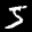

torch.Size([3, 32, 32])


In [4]:
batch_size_train = 256
batch_size_test = 256
batch_size_wm = 64

trainset = datasets.ImageFolder('./data/CIFAR10/with_trigger/train/', transform=transform_train)
testset = datasets.ImageFolder('./data/CIFAR10/test', transform=transform_test)
# # valset = datasets.ImageFolder('./data/CIFAR10/with_trigger/val/', transform=transform_test)
watermarkset = datasets.ImageFolder('./data/CIFAR10/with_trigger/trigger_random/', transform=transform_test)
advwatermarkset = datasets.ImageFolder('./data/CIFAR10/with_trigger/trigger_adv/', transform=transform_test)
unrelatedset = watermark_unrelated(count=100)

train_watermark_mixset = torch.utils.data.ConcatDataset((trainset,unrelatedset))

testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size_test, shuffle=False, num_workers=8)

# # valloader = torch.utils.data.DataLoader(
# # valset, batch_size=batch_size_test, shuffle=False, num_workers=8)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size_train, shuffle=True, num_workers=8, drop_last=False)

wmloader = torch.utils.data.DataLoader(
    watermarkset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)
unrelatedloader = torch.utils.data.DataLoader(
    unrelatedset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)
advwmloader = torch.utils.data.DataLoader(
    advwatermarkset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)
train_watermark_loader = torch.utils.data.DataLoader(
    train_watermark_mixset, batch_size=batch_size_train, shuffle=True, num_workers=8, drop_last=False)

In [5]:
## Sanity Check
print(f"Length of trainset {len(trainset)}")
# print(f"Length of incset {len(incset)}")
print(f"Length of testset {len(testset)}")
# print(f"Length of valset {len(valset)}")
print(f"Length of watermarkset {len(watermarkset)}")
print(f"Length of advwatermarkset {len(advwatermarkset)}")

Length of trainset 44911
Length of testset 10000
Length of watermarkset 100
Length of advwatermarkset 100


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet18().cuda()
    y = net(torch.randn(1, 3, 32, 32).cuda())
    print(y.size())

test()

torch.Size([1, 10])


In [7]:
# warm up with clean data
net = ResNet18()

lr, wd, gamma, epochs = 5e-4, 1e-4, 0.5, 10
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
criterion = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20,
                                                        gamma=gamma, verbose=True)

trainer = Trainer(net, criterion, optimizer, trainloader, trigger_loader=None, scheduler=lr_scheduler, use_trigger=False)
evaluator = Evaluator(net, criterion)
logcmt = f"resnet18_cifar10 opt=Adam lr={lr} wd={wd} sched_gamma={gamma} ep={epochs}"
train(trainer, evaluator, testloader, epochs, 'checkpoints/resnet18.ckpt', logdir='./runs', logcmt=logcmt)

Adjusting learning rate of group 0 to 5.0000e-04.
Start Training...


2023-02-14 16:10:45.061019: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-14 16:10:45.129853: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-14 16:10:45.144210: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-14 16:10:45.405600: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

Adjusting learning rate of group 0 to 5.0000e-04.


Epoch 0 | Time 17s| Train Loss 1.4386 | Train Acc 47.37| Val Loss 1.433 | Val Acc 51.88


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.53it/s]

Adjusting learning rate of group 0 to 5.0000e-04.


Epoch 1 | Time 34s| Train Loss 0.9771 | Train Acc 65.12| Val Loss 1.114 | Val Acc 64.01


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.49it/s]

Adjusting learning rate of group 0 to 5.0000e-04.


Epoch 2 | Time 51s| Train Loss 0.7861 | Train Acc 72.21| Val Loss 0.884 | Val Acc 69.67


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.36it/s]

Adjusting learning rate of group 0 to 5.0000e-04.


Epoch 3 | Time 68s| Train Loss 0.6847 | Train Acc 76.03| Val Loss 0.758 | Val Acc 74.13


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.30it/s]

Adjusting learning rate of group 0 to 5.0000e-04.


Epoch 4 | Time 85s| Train Loss 0.6220 | Train Acc 78.44| Val Loss 0.717 | Val Acc 75.34


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.25it/s]

Adjusting learning rate of group 0 to 5.0000e-04.


Epoch 5 | Time 103s| Train Loss 0.5668 | Train Acc 80.16| Val Loss 0.864 | Val Acc 72.25


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.23it/s]

Adjusting learning rate of group 0 to 5.0000e-04.


Epoch 6 | Time 120s| Train Loss 0.5356 | Train Acc 81.35| Val Loss 0.717 | Val Acc 76.31


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.22it/s]

Adjusting learning rate of group 0 to 5.0000e-04.


Epoch 7 | Time 137s| Train Loss 0.4980 | Train Acc 82.63| Val Loss 0.693 | Val Acc 77.22


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.18it/s]

Adjusting learning rate of group 0 to 5.0000e-04.


Epoch 8 | Time 155s| Train Loss 0.4671 | Train Acc 83.62| Val Loss 0.621 | Val Acc 78.79


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.17it/s]

Adjusting learning rate of group 0 to 5.0000e-04.


Epoch 9 | Time 172s| Train Loss 0.4484 | Train Acc 84.46| Val Loss 0.585 | Val Acc 80.23


{'train_acc': [47.36701476253033,
  65.11767718376345,
  72.20502772149362,
  76.03259780454678,
  78.44180712965642,
  80.15630914475295,
  81.34978067733962,
  82.63009062367794,
  83.62316581683774,
  84.45592393845605],
 'train_loss': [1.438618842204548,
  0.9770989479557503,
  0.7861468465742666,
  0.6846584028921217,
  0.6220373726064177,
  0.566822938472235,
  0.5356191226118502,
  0.49801596050372765,
  0.4671167835965827,
  0.4483755555782185],
 'val_acc': [51.88,
  64.01,
  69.67,
  74.13,
  75.33999999999999,
  72.25,
  76.31,
  77.22,
  78.79,
  80.23],
 'val_loss': [1.432722240447998,
  1.1140369400024415,
  0.8840755517482758,
  0.758043040895462,
  0.7171620811581612,
  0.8638744083166122,
  0.7173361392199993,
  0.6932066419124603,
  0.6211579629421234,
  0.5852975609347224],
 'trigger_acc': [],
 'trigger_loss': []}

In [8]:
# watermark with frozen layers
net = ResNet18()
logcmt = f"resnet18_trigger_finetune"
net.load_state_dict(torch.load('checkpoints/resnet18.ckpt'))
frozen_layers=[net.conv1, net.bn1, net.layer1, net.layer2, net.layer3, net.layer4]
optimizer = torch.optim.Adam(params=net.parameters(), lr=2e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, verbose=True)
trainer = Trainer(net, criterion, optimizer, train_loader=trainloader, trigger_loader=wmloader, use_trigger=True, scheduler=scheduler)
evaluator = Evaluator(net, criterion)
train(trainer, evaluator, testloader, 80, 'checkpoints/resnet18_wm_frozen.ckpt', frozen_layers=frozen_layers,
      logdir='./runs', logcmt=logcmt, trigger_loader=wmloader)

Adjusting learning rate of group 0 to 2.0000e-04.
Start Training...


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:12<00:00, 13.84it/s]


Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 0 | Time 14s| Train Loss 1.3668 | Train Acc 70.60| Val Loss 0.632 | Val Acc 81.21| Trigger Loss 3.804 | Trigger Acc 2.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:12<00:00, 13.94it/s]


Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 1 | Time 30s| Train Loss 1.0995 | Train Acc 71.01| Val Loss 0.651 | Val Acc 81.30| Trigger Loss 3.345 | Trigger Acc 2.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:14<00:00, 12.33it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 2 | Time 46s| Train Loss 0.7378 | Train Acc 77.92| Val Loss 0.604 | Val Acc 80.12| Trigger Loss 0.442 | Trigger Acc 88.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:10<00:00, 16.54it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 3 | Time 59s| Train Loss 0.3980 | Train Acc 87.34| Val Loss 0.512 | Val Acc 82.24| Trigger Loss 0.076 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:08<00:00, 19.69it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 4 | Time 70s| Train Loss 0.3276 | Train Acc 88.97| Val Loss 0.484 | Val Acc 83.66| Trigger Loss 0.024 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:07<00:00, 22.41it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 5 | Time 80s| Train Loss 0.2946 | Train Acc 89.80| Val Loss 0.498 | Val Acc 83.67| Trigger Loss 0.010 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:13<00:00, 13.20it/s]


Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 6 | Time 96s| Train Loss 0.2858 | Train Acc 90.27| Val Loss 0.493 | Val Acc 83.82| Trigger Loss 0.035 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:13<00:00, 13.32it/s]


Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 7 | Time 111s| Train Loss 0.2860 | Train Acc 90.08| Val Loss 0.489 | Val Acc 84.06| Trigger Loss 0.031 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:14<00:00, 11.84it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 8 | Time 128s| Train Loss 0.2990 | Train Acc 89.93| Val Loss 0.495 | Val Acc 83.91| Trigger Loss 0.041 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:11<00:00, 15.78it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 9 | Time 142s| Train Loss 0.2910 | Train Acc 90.11| Val Loss 0.491 | Val Acc 83.58| Trigger Loss 0.029 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:09<00:00, 18.82it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 10 | Time 153s| Train Loss 0.2756 | Train Acc 90.45| Val Loss 0.469 | Val Acc 84.62| Trigger Loss 0.012 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:07<00:00, 22.38it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 11 | Time 163s| Train Loss 0.2559 | Train Acc 91.12| Val Loss 0.479 | Val Acc 84.78| Trigger Loss 0.004 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:13<00:00, 13.17it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 12 | Time 179s| Train Loss 0.2540 | Train Acc 91.11| Val Loss 0.484 | Val Acc 84.66| Trigger Loss 0.009 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:13<00:00, 13.28it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 13 | Time 194s| Train Loss 0.2435 | Train Acc 91.68| Val Loss 0.479 | Val Acc 84.60| Trigger Loss 0.008 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:14<00:00, 11.85it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 14 | Time 211s| Train Loss 0.2459 | Train Acc 91.53| Val Loss 0.470 | Val Acc 84.96| Trigger Loss 0.016 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:11<00:00, 15.74it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 15 | Time 224s| Train Loss 0.2379 | Train Acc 91.79| Val Loss 0.478 | Val Acc 84.62| Trigger Loss 0.010 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:09<00:00, 18.83it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 16 | Time 236s| Train Loss 0.2446 | Train Acc 91.55| Val Loss 0.478 | Val Acc 84.42| Trigger Loss 0.009 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:07<00:00, 22.38it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 17 | Time 246s| Train Loss 0.2315 | Train Acc 91.89| Val Loss 0.469 | Val Acc 84.93| Trigger Loss 0.005 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:13<00:00, 13.16it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 18 | Time 261s| Train Loss 0.2203 | Train Acc 92.36| Val Loss 0.473 | Val Acc 84.94| Trigger Loss 0.005 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:13<00:00, 13.25it/s]


Adjusting learning rate of group 0 to 5.0000e-05.
Epoch 19 | Time 277s| Train Loss 0.2151 | Train Acc 92.38| Val Loss 0.471 | Val Acc 85.07| Trigger Loss 0.005 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:29<00:00,  6.05it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 20 | Time 309s| Train Loss 0.2134 | Train Acc 92.60| Val Loss 0.461 | Val Acc 85.34| Trigger Loss 0.005 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:21<00:00,  8.08it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 21 | Time 334s| Train Loss 0.2048 | Train Acc 92.82| Val Loss 0.454 | Val Acc 85.62| Trigger Loss 0.004 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.41it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 22 | Time 356s| Train Loss 0.2074 | Train Acc 92.73| Val Loss 0.484 | Val Acc 84.98| Trigger Loss 0.006 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.42it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 23 | Time 375s| Train Loss 0.1928 | Train Acc 93.28| Val Loss 0.465 | Val Acc 85.78| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:26<00:00,  6.67it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 24 | Time 405s| Train Loss 0.1822 | Train Acc 93.59| Val Loss 0.456 | Val Acc 85.70| Trigger Loss 0.003 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:25<00:00,  6.94it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 25 | Time 433s| Train Loss 0.1774 | Train Acc 93.81| Val Loss 0.457 | Val Acc 85.87| Trigger Loss 0.003 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:29<00:00,  6.00it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 26 | Time 466s| Train Loss 0.1825 | Train Acc 93.73| Val Loss 0.459 | Val Acc 85.62| Trigger Loss 0.004 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:22<00:00,  7.84it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 27 | Time 492s| Train Loss 0.1802 | Train Acc 93.80| Val Loss 0.454 | Val Acc 85.95| Trigger Loss 0.004 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.64it/s]


Adjusting learning rate of group 0 to 5.0000e-05.
Epoch 28 | Time 513s| Train Loss 0.1843 | Train Acc 93.56| Val Loss 0.469 | Val Acc 85.75| Trigger Loss 0.006 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.67it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 29 | Time 532s| Train Loss 0.1766 | Train Acc 93.73| Val Loss 0.488 | Val Acc 85.39| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:25<00:00,  7.01it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 30 | Time 560s| Train Loss 0.1642 | Train Acc 94.21| Val Loss 0.475 | Val Acc 85.70| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:26<00:00,  6.58it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 31 | Time 590s| Train Loss 0.1623 | Train Acc 94.38| Val Loss 0.475 | Val Acc 85.76| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:27<00:00,  6.29it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 32 | Time 622s| Train Loss 0.1646 | Train Acc 94.32| Val Loss 0.468 | Val Acc 85.87| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:22<00:00,  7.84it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 33 | Time 647s| Train Loss 0.1609 | Train Acc 94.44| Val Loss 0.459 | Val Acc 85.96| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.41it/s]


Adjusting learning rate of group 0 to 2.5000e-05.
Epoch 34 | Time 669s| Train Loss 0.1612 | Train Acc 94.49| Val Loss 0.455 | Val Acc 86.29| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.23it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 35 | Time 688s| Train Loss 0.1506 | Train Acc 94.78| Val Loss 0.462 | Val Acc 86.25| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:26<00:00,  6.69it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 36 | Time 718s| Train Loss 0.1456 | Train Acc 94.98| Val Loss 0.464 | Val Acc 86.13| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:24<00:00,  7.11it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 37 | Time 746s| Train Loss 0.1451 | Train Acc 94.98| Val Loss 0.463 | Val Acc 86.24| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:29<00:00,  5.97it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 38 | Time 779s| Train Loss 0.1460 | Train Acc 94.84| Val Loss 0.463 | Val Acc 86.36| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:22<00:00,  7.84it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 39 | Time 805s| Train Loss 0.1463 | Train Acc 94.86| Val Loss 0.460 | Val Acc 86.35| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.41it/s]


Adjusting learning rate of group 0 to 1.2500e-05.
Epoch 40 | Time 827s| Train Loss 0.1416 | Train Acc 95.13| Val Loss 0.459 | Val Acc 86.35| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.70it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 41 | Time 845s| Train Loss 0.1340 | Train Acc 95.24| Val Loss 0.467 | Val Acc 86.60| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:25<00:00,  7.02it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 42 | Time 874s| Train Loss 0.1325 | Train Acc 95.45| Val Loss 0.469 | Val Acc 86.46| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:26<00:00,  6.58it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 43 | Time 904s| Train Loss 0.1320 | Train Acc 95.46| Val Loss 0.470 | Val Acc 86.39| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:29<00:00,  5.89it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 44 | Time 937s| Train Loss 0.1307 | Train Acc 95.45| Val Loss 0.469 | Val Acc 86.68| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:21<00:00,  8.18it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 45 | Time 962s| Train Loss 0.1305 | Train Acc 95.57| Val Loss 0.468 | Val Acc 86.56| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.77it/s]


Adjusting learning rate of group 0 to 1.2500e-05.
Epoch 46 | Time 983s| Train Loss 0.1312 | Train Acc 95.47| Val Loss 0.468 | Val Acc 86.40| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.71it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 47 | Time 1002s| Train Loss 0.1262 | Train Acc 95.66| Val Loss 0.476 | Val Acc 86.32| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:26<00:00,  6.59it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 48 | Time 1031s| Train Loss 0.1268 | Train Acc 95.68| Val Loss 0.478 | Val Acc 86.19| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:26<00:00,  6.57it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 49 | Time 1061s| Train Loss 0.1243 | Train Acc 95.74| Val Loss 0.478 | Val Acc 86.46| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:28<00:00,  6.19it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 50 | Time 1093s| Train Loss 0.1235 | Train Acc 95.72| Val Loss 0.479 | Val Acc 86.27| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:22<00:00,  7.83it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 51 | Time 1119s| Train Loss 0.1246 | Train Acc 95.70| Val Loss 0.476 | Val Acc 86.41| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.42it/s]


Adjusting learning rate of group 0 to 6.2500e-06.
Epoch 52 | Time 1141s| Train Loss 0.1216 | Train Acc 95.79| Val Loss 0.474 | Val Acc 86.38| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.27it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 53 | Time 1160s| Train Loss 0.1235 | Train Acc 95.73| Val Loss 0.474 | Val Acc 86.37| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:27<00:00,  6.51it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 54 | Time 1190s| Train Loss 0.1192 | Train Acc 95.91| Val Loss 0.474 | Val Acc 86.41| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:14<00:00, 12.39it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 55 | Time 1206s| Train Loss 0.1179 | Train Acc 95.94| Val Loss 0.473 | Val Acc 86.39| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:14<00:00, 11.78it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 56 | Time 1224s| Train Loss 0.1196 | Train Acc 95.97| Val Loss 0.472 | Val Acc 86.50| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:11<00:00, 15.70it/s]


Adjusting learning rate of group 0 to 6.2500e-06.
Epoch 57 | Time 1237s| Train Loss 0.1190 | Train Acc 95.85| Val Loss 0.474 | Val Acc 86.58| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:09<00:00, 18.74it/s]


Adjusting learning rate of group 0 to 6.2500e-06.
Epoch 58 | Time 1249s| Train Loss 0.1185 | Train Acc 95.93| Val Loss 0.476 | Val Acc 86.42| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:07<00:00, 22.25it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 59 | Time 1259s| Train Loss 0.1160 | Train Acc 96.04| Val Loss 0.473 | Val Acc 86.49| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:13<00:00, 13.14it/s]


Adjusting learning rate of group 0 to 3.1250e-06.
Epoch 60 | Time 1275s| Train Loss 0.1132 | Train Acc 96.05| Val Loss 0.477 | Val Acc 86.50| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:13<00:00, 13.28it/s]


Adjusting learning rate of group 0 to 3.1250e-06.
Epoch 61 | Time 1290s| Train Loss 0.1154 | Train Acc 96.08| Val Loss 0.478 | Val Acc 86.45| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:14<00:00, 11.87it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 62 | Time 1307s| Train Loss 0.1176 | Train Acc 95.94| Val Loss 0.476 | Val Acc 86.50| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:11<00:00, 15.79it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 63 | Time 1321s| Train Loss 0.1165 | Train Acc 95.93| Val Loss 0.474 | Val Acc 86.62| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:09<00:00, 18.90it/s]


Adjusting learning rate of group 0 to 3.1250e-06.
Epoch 64 | Time 1332s| Train Loss 0.1137 | Train Acc 95.97| Val Loss 0.475 | Val Acc 86.55| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:07<00:00, 22.35it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 65 | Time 1342s| Train Loss 0.1115 | Train Acc 96.08| Val Loss 0.479 | Val Acc 86.60| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:13<00:00, 13.22it/s]


Adjusting learning rate of group 0 to 3.1250e-06.
Epoch 66 | Time 1358s| Train Loss 0.1112 | Train Acc 96.17| Val Loss 0.477 | Val Acc 86.45| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:13<00:00, 13.33it/s]


Adjusting learning rate of group 0 to 3.1250e-06.
Epoch 67 | Time 1373s| Train Loss 0.1106 | Train Acc 96.21| Val Loss 0.478 | Val Acc 86.52| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:14<00:00, 11.89it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 68 | Time 1390s| Train Loss 0.1101 | Train Acc 96.27| Val Loss 0.479 | Val Acc 86.57| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:11<00:00, 15.81it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 69 | Time 1404s| Train Loss 0.1107 | Train Acc 96.24| Val Loss 0.478 | Val Acc 86.58| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:09<00:00, 18.90it/s]


Adjusting learning rate of group 0 to 1.5625e-06.
Epoch 70 | Time 1415s| Train Loss 0.1117 | Train Acc 96.19| Val Loss 0.477 | Val Acc 86.50| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:07<00:00, 22.45it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 71 | Time 1425s| Train Loss 0.1104 | Train Acc 96.19| Val Loss 0.475 | Val Acc 86.53| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:13<00:00, 13.18it/s]


Adjusting learning rate of group 0 to 1.5625e-06.
Epoch 72 | Time 1441s| Train Loss 0.1116 | Train Acc 96.17| Val Loss 0.478 | Val Acc 86.50| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:13<00:00, 13.31it/s]


Adjusting learning rate of group 0 to 1.5625e-06.
Epoch 73 | Time 1456s| Train Loss 0.1084 | Train Acc 96.30| Val Loss 0.478 | Val Acc 86.59| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:14<00:00, 11.86it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 74 | Time 1474s| Train Loss 0.1104 | Train Acc 96.27| Val Loss 0.478 | Val Acc 86.65| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:11<00:00, 15.80it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 75 | Time 1487s| Train Loss 0.1114 | Train Acc 96.12| Val Loss 0.475 | Val Acc 86.63| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:09<00:00, 18.88it/s]


Adjusting learning rate of group 0 to 1.5625e-06.
Epoch 76 | Time 1498s| Train Loss 0.1102 | Train Acc 96.22| Val Loss 0.475 | Val Acc 86.59| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:07<00:00, 22.37it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 77 | Time 1509s| Train Loss 0.1102 | Train Acc 96.24| Val Loss 0.477 | Val Acc 86.51| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:13<00:00, 13.20it/s]


Adjusting learning rate of group 0 to 1.5625e-06.
Epoch 78 | Time 1524s| Train Loss 0.1107 | Train Acc 96.23| Val Loss 0.477 | Val Acc 86.60| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:13<00:00, 13.31it/s]


Adjusting learning rate of group 0 to 7.8125e-07.
Epoch 79 | Time 1540s| Train Loss 0.1080 | Train Acc 96.33| Val Loss 0.476 | Val Acc 86.64| Trigger Loss 0.001 | Trigger Acc 100.00


{'train_acc': [70.6037869337752,
  71.00780100910427,
  77.91700024203608,
  87.33778927966338,
  88.9724637411331,
  89.80283368397535,
  90.27201131984137,
  90.08396790229189,
  89.9312989890339,
  90.10817151049133,
  90.4488838412988,
  91.11727579080635,
  91.11355215877566,
  91.6776824114241,
  91.52873713019679,
  91.78752955632923,
  91.54921710636555,
  91.89365306920371,
  92.35538344100836,
  92.3795870492078,
  92.60114315503341,
  92.82456107687437,
  92.72588482806128,
  93.28256781664835,
  93.586043827149,
  93.80759993297463,
  93.73498910837631,
  93.80015266891326,
  93.56184021894957,
  93.72754184431494,
  94.20602856025766,
  94.38103926569977,
  94.31587570516281,
  94.43689374616,
  94.49461004263559,
  94.77946789298282,
  94.98240583865503,
  94.98240583865503,
  94.84463145351977,
  94.86138779765784,
  95.1257656718363,
  95.23747463275679,
  95.4534452905364,
  95.45903073858241,
  95.4534452905364,
  95.56515425145687,
  95.47392526670514,
  95.656383236

In [9]:
# rowback baseline
net = ResNet18()
logcmt = f"resnet18_trigger_finetune"
net.load_state_dict(torch.load('checkpoints/resnet18.ckpt'))
frozen_layers=[net.conv1, net.bn1, net.layer1, net.layer2, net.layer3, net.layer4]
optimizer = torch.optim.Adam(params=net.parameters(), lr=2e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, verbose=True)
trainer = Trainer(net, criterion, optimizer, train_loader=trainloader, trigger_loader=advwmloader, use_trigger=True, scheduler=scheduler)
evaluator = Evaluator(net, criterion)
train(trainer, evaluator, testloader, 80, 'checkpoints/resnet18_wm_rowback.ckpt', frozen_layers=frozen_layers,
      logdir='./runs', logcmt=logcmt, trigger_loader=advwmloader)

Adjusting learning rate of group 0 to 2.0000e-04.
Start Training...


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:12<00:00, 13.79it/s]


Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 0 | Time 14s| Train Loss 1.2042 | Train Acc 71.26| Val Loss 0.607 | Val Acc 80.62| Trigger Loss 3.433 | Trigger Acc 5.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:12<00:00, 13.93it/s]


Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 1 | Time 30s| Train Loss 0.9923 | Train Acc 71.56| Val Loss 0.614 | Val Acc 80.80| Trigger Loss 3.070 | Trigger Acc 7.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:14<00:00, 12.31it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 2 | Time 47s| Train Loss 0.6711 | Train Acc 79.52| Val Loss 0.570 | Val Acc 81.23| Trigger Loss 0.490 | Trigger Acc 91.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:10<00:00, 16.49it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 3 | Time 60s| Train Loss 0.3831 | Train Acc 87.80| Val Loss 0.499 | Val Acc 83.53| Trigger Loss 0.073 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:08<00:00, 19.66it/s]


Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 4 | Time 71s| Train Loss 0.3154 | Train Acc 89.27| Val Loss 0.495 | Val Acc 83.37| Trigger Loss 0.020 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:07<00:00, 22.37it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 5 | Time 81s| Train Loss 0.2861 | Train Acc 90.15| Val Loss 0.503 | Val Acc 83.43| Trigger Loss 0.012 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:13<00:00, 13.20it/s]


Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 6 | Time 96s| Train Loss 0.2734 | Train Acc 90.64| Val Loss 0.477 | Val Acc 84.14| Trigger Loss 0.021 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:13<00:00, 13.32it/s]


Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 7 | Time 112s| Train Loss 0.2681 | Train Acc 90.79| Val Loss 0.482 | Val Acc 84.19| Trigger Loss 0.021 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:14<00:00, 11.84it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 8 | Time 129s| Train Loss 0.2824 | Train Acc 90.25| Val Loss 0.483 | Val Acc 84.81| Trigger Loss 0.033 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:11<00:00, 15.78it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 9 | Time 142s| Train Loss 0.2831 | Train Acc 90.32| Val Loss 0.480 | Val Acc 84.62| Trigger Loss 0.051 | Trigger Acc 99.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:09<00:00, 18.86it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 10 | Time 154s| Train Loss 0.2628 | Train Acc 91.01| Val Loss 0.471 | Val Acc 84.59| Trigger Loss 0.013 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:07<00:00, 22.33it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 11 | Time 164s| Train Loss 0.2542 | Train Acc 91.30| Val Loss 0.483 | Val Acc 84.93| Trigger Loss 0.003 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:13<00:00, 13.18it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 12 | Time 179s| Train Loss 0.2426 | Train Acc 91.58| Val Loss 0.471 | Val Acc 84.94| Trigger Loss 0.008 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:13<00:00, 13.30it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 13 | Time 195s| Train Loss 0.2348 | Train Acc 91.84| Val Loss 0.467 | Val Acc 85.01| Trigger Loss 0.010 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:14<00:00, 11.86it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 14 | Time 212s| Train Loss 0.2353 | Train Acc 91.97| Val Loss 0.468 | Val Acc 84.90| Trigger Loss 0.013 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:11<00:00, 15.76it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 15 | Time 225s| Train Loss 0.2323 | Train Acc 91.97| Val Loss 0.458 | Val Acc 85.15| Trigger Loss 0.012 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:09<00:00, 18.88it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 16 | Time 237s| Train Loss 0.2402 | Train Acc 91.61| Val Loss 0.493 | Val Acc 84.86| Trigger Loss 0.010 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:07<00:00, 22.34it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 17 | Time 247s| Train Loss 0.2262 | Train Acc 92.12| Val Loss 0.464 | Val Acc 85.58| Trigger Loss 0.003 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:13<00:00, 13.19it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 18 | Time 263s| Train Loss 0.2189 | Train Acc 92.42| Val Loss 0.460 | Val Acc 85.57| Trigger Loss 0.006 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:13<00:00, 13.31it/s]


Adjusting learning rate of group 0 to 5.0000e-05.
Epoch 19 | Time 278s| Train Loss 0.2085 | Train Acc 92.80| Val Loss 0.459 | Val Acc 85.52| Trigger Loss 0.004 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:14<00:00, 11.87it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 20 | Time 295s| Train Loss 0.2094 | Train Acc 92.84| Val Loss 0.457 | Val Acc 85.73| Trigger Loss 0.006 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:11<00:00, 15.81it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 21 | Time 309s| Train Loss 0.2023 | Train Acc 92.90| Val Loss 0.446 | Val Acc 86.03| Trigger Loss 0.004 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:09<00:00, 18.86it/s]


Adjusting learning rate of group 0 to 5.0000e-05.
Epoch 22 | Time 320s| Train Loss 0.1994 | Train Acc 92.96| Val Loss 0.450 | Val Acc 86.04| Trigger Loss 0.004 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:07<00:00, 22.39it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 23 | Time 330s| Train Loss 0.1867 | Train Acc 93.51| Val Loss 0.460 | Val Acc 86.13| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:13<00:00, 13.20it/s]


Adjusting learning rate of group 0 to 5.0000e-05.
Epoch 24 | Time 346s| Train Loss 0.1791 | Train Acc 93.75| Val Loss 0.461 | Val Acc 86.04| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:13<00:00, 13.30it/s]


Adjusting learning rate of group 0 to 5.0000e-05.
Epoch 25 | Time 361s| Train Loss 0.1753 | Train Acc 93.91| Val Loss 0.458 | Val Acc 86.19| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:14<00:00, 11.84it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 26 | Time 378s| Train Loss 0.1775 | Train Acc 93.70| Val Loss 0.464 | Val Acc 85.99| Trigger Loss 0.004 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:11<00:00, 15.81it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 27 | Time 392s| Train Loss 0.1760 | Train Acc 93.94| Val Loss 0.454 | Val Acc 86.38| Trigger Loss 0.003 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:09<00:00, 18.85it/s]


Adjusting learning rate of group 0 to 5.0000e-05.
Epoch 28 | Time 403s| Train Loss 0.1833 | Train Acc 93.51| Val Loss 0.479 | Val Acc 85.89| Trigger Loss 0.008 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:07<00:00, 22.37it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 29 | Time 413s| Train Loss 0.1702 | Train Acc 94.05| Val Loss 0.462 | Val Acc 86.42| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:13<00:00, 13.18it/s]


Adjusting learning rate of group 0 to 2.5000e-05.
Epoch 30 | Time 429s| Train Loss 0.1581 | Train Acc 94.49| Val Loss 0.463 | Val Acc 86.54| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:13<00:00, 13.30it/s]


Adjusting learning rate of group 0 to 2.5000e-05.
Epoch 31 | Time 445s| Train Loss 0.1549 | Train Acc 94.61| Val Loss 0.463 | Val Acc 86.58| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:14<00:00, 11.86it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 32 | Time 462s| Train Loss 0.1573 | Train Acc 94.51| Val Loss 0.459 | Val Acc 86.63| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:11<00:00, 15.77it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 33 | Time 475s| Train Loss 0.1543 | Train Acc 94.68| Val Loss 0.455 | Val Acc 86.53| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:09<00:00, 18.85it/s]


Adjusting learning rate of group 0 to 2.5000e-05.
Epoch 34 | Time 487s| Train Loss 0.1552 | Train Acc 94.61| Val Loss 0.465 | Val Acc 86.59| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:07<00:00, 22.37it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 35 | Time 497s| Train Loss 0.1454 | Train Acc 94.97| Val Loss 0.469 | Val Acc 86.75| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:13<00:00, 13.18it/s]


Adjusting learning rate of group 0 to 2.5000e-05.
Epoch 36 | Time 512s| Train Loss 0.1428 | Train Acc 95.03| Val Loss 0.470 | Val Acc 86.63| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:13<00:00, 13.29it/s]


Adjusting learning rate of group 0 to 2.5000e-05.
Epoch 37 | Time 528s| Train Loss 0.1408 | Train Acc 95.18| Val Loss 0.469 | Val Acc 86.56| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:14<00:00, 11.86it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 38 | Time 545s| Train Loss 0.1410 | Train Acc 95.12| Val Loss 0.471 | Val Acc 86.76| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:11<00:00, 15.80it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 39 | Time 558s| Train Loss 0.1394 | Train Acc 95.30| Val Loss 0.462 | Val Acc 86.78| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:09<00:00, 18.85it/s]


Adjusting learning rate of group 0 to 1.2500e-05.
Epoch 40 | Time 570s| Train Loss 0.1387 | Train Acc 95.21| Val Loss 0.459 | Val Acc 86.76| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:07<00:00, 22.41it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 41 | Time 580s| Train Loss 0.1329 | Train Acc 95.25| Val Loss 0.465 | Val Acc 86.72| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:13<00:00, 13.19it/s]


Adjusting learning rate of group 0 to 1.2500e-05.
Epoch 42 | Time 596s| Train Loss 0.1284 | Train Acc 95.50| Val Loss 0.466 | Val Acc 86.79| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:13<00:00, 13.28it/s]


Adjusting learning rate of group 0 to 1.2500e-05.
Epoch 43 | Time 611s| Train Loss 0.1272 | Train Acc 95.55| Val Loss 0.463 | Val Acc 86.82| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:14<00:00, 11.85it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 44 | Time 628s| Train Loss 0.1298 | Train Acc 95.54| Val Loss 0.465 | Val Acc 86.84| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:11<00:00, 15.80it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 45 | Time 642s| Train Loss 0.1262 | Train Acc 95.71| Val Loss 0.469 | Val Acc 86.93| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:09<00:00, 18.86it/s]


Adjusting learning rate of group 0 to 1.2500e-05.
Epoch 46 | Time 653s| Train Loss 0.1265 | Train Acc 95.69| Val Loss 0.471 | Val Acc 86.70| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:07<00:00, 22.36it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 47 | Time 663s| Train Loss 0.1252 | Train Acc 95.70| Val Loss 0.474 | Val Acc 86.89| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:13<00:00, 13.17it/s]


Adjusting learning rate of group 0 to 1.2500e-05.
Epoch 48 | Time 679s| Train Loss 0.1218 | Train Acc 95.86| Val Loss 0.475 | Val Acc 86.99| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:13<00:00, 13.30it/s]


Adjusting learning rate of group 0 to 6.2500e-06.
Epoch 49 | Time 694s| Train Loss 0.1212 | Train Acc 95.84| Val Loss 0.472 | Val Acc 86.75| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:14<00:00, 11.86it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 50 | Time 712s| Train Loss 0.1220 | Train Acc 95.80| Val Loss 0.474 | Val Acc 87.04| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:11<00:00, 15.79it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 51 | Time 725s| Train Loss 0.1225 | Train Acc 95.88| Val Loss 0.475 | Val Acc 86.95| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:09<00:00, 18.87it/s]


Adjusting learning rate of group 0 to 6.2500e-06.
Epoch 52 | Time 736s| Train Loss 0.1196 | Train Acc 95.86| Val Loss 0.473 | Val Acc 86.85| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:07<00:00, 22.36it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 53 | Time 747s| Train Loss 0.1178 | Train Acc 95.92| Val Loss 0.476 | Val Acc 86.87| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:13<00:00, 13.17it/s]


Adjusting learning rate of group 0 to 6.2500e-06.
Epoch 54 | Time 762s| Train Loss 0.1152 | Train Acc 96.01| Val Loss 0.475 | Val Acc 87.00| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:13<00:00, 13.31it/s]


Adjusting learning rate of group 0 to 6.2500e-06.
Epoch 55 | Time 778s| Train Loss 0.1153 | Train Acc 95.98| Val Loss 0.475 | Val Acc 87.10| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:14<00:00, 11.87it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 56 | Time 795s| Train Loss 0.1156 | Train Acc 96.05| Val Loss 0.476 | Val Acc 87.13| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:11<00:00, 15.77it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 57 | Time 808s| Train Loss 0.1148 | Train Acc 96.05| Val Loss 0.474 | Val Acc 87.10| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:09<00:00, 18.83it/s]


Adjusting learning rate of group 0 to 6.2500e-06.
Epoch 58 | Time 820s| Train Loss 0.1156 | Train Acc 96.00| Val Loss 0.472 | Val Acc 87.03| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:07<00:00, 22.41it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 59 | Time 830s| Train Loss 0.1132 | Train Acc 96.12| Val Loss 0.479 | Val Acc 86.98| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:13<00:00, 13.20it/s]


Adjusting learning rate of group 0 to 3.1250e-06.
Epoch 60 | Time 845s| Train Loss 0.1120 | Train Acc 96.20| Val Loss 0.477 | Val Acc 87.01| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:13<00:00, 13.31it/s]


Adjusting learning rate of group 0 to 3.1250e-06.
Epoch 61 | Time 861s| Train Loss 0.1106 | Train Acc 96.23| Val Loss 0.479 | Val Acc 87.03| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:14<00:00, 11.86it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 62 | Time 878s| Train Loss 0.1106 | Train Acc 96.26| Val Loss 0.475 | Val Acc 87.08| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:11<00:00, 15.78it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 63 | Time 891s| Train Loss 0.1121 | Train Acc 96.23| Val Loss 0.477 | Val Acc 87.17| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:09<00:00, 18.84it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 64 | Time 903s| Train Loss 0.1124 | Train Acc 96.12| Val Loss 0.477 | Val Acc 87.05| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:07<00:00, 22.34it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 65 | Time 913s| Train Loss 0.1092 | Train Acc 96.21| Val Loss 0.478 | Val Acc 87.07| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:13<00:00, 13.18it/s]


Adjusting learning rate of group 0 to 3.1250e-06.
Epoch 66 | Time 929s| Train Loss 0.1079 | Train Acc 96.35| Val Loss 0.475 | Val Acc 87.05| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:13<00:00, 13.27it/s]


Adjusting learning rate of group 0 to 3.1250e-06.
Epoch 67 | Time 944s| Train Loss 0.1086 | Train Acc 96.26| Val Loss 0.478 | Val Acc 86.94| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:14<00:00, 11.87it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 68 | Time 961s| Train Loss 0.1080 | Train Acc 96.29| Val Loss 0.475 | Val Acc 86.97| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:11<00:00, 15.78it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 69 | Time 975s| Train Loss 0.1080 | Train Acc 96.30| Val Loss 0.476 | Val Acc 87.15| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:09<00:00, 18.85it/s]


Adjusting learning rate of group 0 to 1.5625e-06.
Epoch 70 | Time 986s| Train Loss 0.1105 | Train Acc 96.24| Val Loss 0.474 | Val Acc 87.12| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:07<00:00, 22.34it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 71 | Time 996s| Train Loss 0.1073 | Train Acc 96.30| Val Loss 0.475 | Val Acc 87.21| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:13<00:00, 13.18it/s]


Adjusting learning rate of group 0 to 1.5625e-06.
Epoch 72 | Time 1012s| Train Loss 0.1088 | Train Acc 96.31| Val Loss 0.475 | Val Acc 87.17| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:13<00:00, 13.30it/s]


Adjusting learning rate of group 0 to 1.5625e-06.
Epoch 73 | Time 1027s| Train Loss 0.1056 | Train Acc 96.37| Val Loss 0.477 | Val Acc 87.12| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:14<00:00, 11.87it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 74 | Time 1044s| Train Loss 0.1085 | Train Acc 96.29| Val Loss 0.475 | Val Acc 87.04| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:11<00:00, 15.80it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 75 | Time 1058s| Train Loss 0.1075 | Train Acc 96.30| Val Loss 0.478 | Val Acc 87.13| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:09<00:00, 18.85it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 76 | Time 1069s| Train Loss 0.1072 | Train Acc 96.33| Val Loss 0.477 | Val Acc 87.00| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:07<00:00, 22.36it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 77 | Time 1079s| Train Loss 0.1065 | Train Acc 96.35| Val Loss 0.476 | Val Acc 87.10| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:13<00:00, 13.20it/s]


Adjusting learning rate of group 0 to 1.5625e-06.
Epoch 78 | Time 1095s| Train Loss 0.1050 | Train Acc 96.49| Val Loss 0.477 | Val Acc 87.19| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:13<00:00, 13.31it/s]


Adjusting learning rate of group 0 to 7.8125e-07.
Epoch 79 | Time 1110s| Train Loss 0.1059 | Train Acc 96.32| Val Loss 0.476 | Val Acc 87.20| Trigger Loss 0.001 | Trigger Acc 100.00


{'train_acc': [71.26100798719071,
  71.562622181676,
  79.51816201522965,
  87.80324328349872,
  89.27035430358772,
  90.15471691087487,
  90.64065089087896,
  90.78773435609094,
  90.25339315968796,
  90.32041853624024,
  91.00742864590121,
  91.29601012827912,
  91.57900616261101,
  91.84152222077414,
  91.97184934184803,
  91.97184934184803,
  91.6106570348718,
  92.11893280706,
  92.4205470015453,
  92.79849565265961,
  92.84131742101246,
  92.90275734951872,
  92.9604736459943,
  93.50598573848933,
  93.75174545251438,
  93.91372344584909,
  93.69589097205414,
  93.9416506860792,
  93.51157118653535,
  94.04591238293831,
  94.48530096255888,
  94.61004263558675,
  94.50578093872764,
  94.6752061961237,
  94.61190445160209,
  94.96751131053229,
  95.03267487106925,
  95.17975833628121,
  95.1164565917596,
  95.30263819329375,
  95.20954739252667,
  95.24864552884884,
  95.49999069091993,
  95.55025972333414,
  95.54467427528812,
  95.71409953268419,
  95.6880341084694,
  95.6992050

In [10]:
# normal watermark
net = ResNet18()
logcmt = f"resnet18_trigger_finetune"
net.load_state_dict(torch.load('checkpoints/resnet18.ckpt'))
optimizer = torch.optim.Adam(params=net.parameters(), lr=2e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, verbose=True)
trainer = Trainer(net, criterion, optimizer, train_loader=trainloader, trigger_loader=wmloader, use_trigger=True, scheduler=scheduler)
evaluator = Evaluator(net, criterion)
train(trainer, evaluator, testloader, 80, 'checkpoints/resnet18_wm.ckpt',
      logdir='./runs', logcmt=logcmt, trigger_loader=wmloader)

Adjusting learning rate of group 0 to 2.0000e-04.
Start Training...


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.41it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 0 | Time 20s| Train Loss 0.4137 | Train Acc 87.29| Val Loss 0.504 | Val Acc 83.02| Trigger Loss 0.033 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 1 | Time 42s| Train Loss 0.2806 | Train Acc 90.18| Val Loss 0.487 | Val Acc 84.24| Trigger Loss 0.022 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.41it/s]


Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 2 | Time 63s| Train Loss 0.2600 | Train Acc 90.86| Val Loss 0.494 | Val Acc 84.21| Trigger Loss 0.026 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.40it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 3 | Time 84s| Train Loss 0.2447 | Train Acc 91.49| Val Loss 0.536 | Val Acc 83.56| Trigger Loss 0.025 | Trigger Acc 99.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.40it/s]


Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 4 | Time 105s| Train Loss 0.2344 | Train Acc 92.01| Val Loss 0.512 | Val Acc 83.75| Trigger Loss 0.030 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 5 | Time 126s| Train Loss 0.2217 | Train Acc 92.31| Val Loss 0.531 | Val Acc 83.92| Trigger Loss 0.031 | Trigger Acc 99.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.40it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 6 | Time 146s| Train Loss 0.2070 | Train Acc 92.68| Val Loss 0.526 | Val Acc 83.75| Trigger Loss 0.035 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 7 | Time 167s| Train Loss 0.1996 | Train Acc 93.02| Val Loss 0.480 | Val Acc 85.29| Trigger Loss 0.015 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.41it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 8 | Time 188s| Train Loss 0.1865 | Train Acc 93.42| Val Loss 0.582 | Val Acc 83.26| Trigger Loss 0.017 | Trigger Acc 99.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.40it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 9 | Time 209s| Train Loss 0.1745 | Train Acc 93.97| Val Loss 0.467 | Val Acc 86.20| Trigger Loss 0.023 | Trigger Acc 99.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.41it/s]


Adjusting learning rate of group 0 to 2.0000e-05.
Epoch 10 | Time 230s| Train Loss 0.1243 | Train Acc 95.80| Val Loss 0.408 | Val Acc 87.86| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.41it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 11 | Time 251s| Train Loss 0.1055 | Train Acc 96.47| Val Loss 0.411 | Val Acc 87.99| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.40it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 12 | Time 272s| Train Loss 0.1003 | Train Acc 96.68| Val Loss 0.417 | Val Acc 87.91| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.41it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 13 | Time 293s| Train Loss 0.0938 | Train Acc 96.85| Val Loss 0.420 | Val Acc 87.88| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.40it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 14 | Time 314s| Train Loss 0.0882 | Train Acc 97.09| Val Loss 0.418 | Val Acc 88.06| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.40it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 15 | Time 335s| Train Loss 0.0844 | Train Acc 97.16| Val Loss 0.429 | Val Acc 87.94| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.40it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 16 | Time 356s| Train Loss 0.0821 | Train Acc 97.29| Val Loss 0.435 | Val Acc 88.03| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.40it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 17 | Time 377s| Train Loss 0.0763 | Train Acc 97.49| Val Loss 0.432 | Val Acc 87.95| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.40it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 18 | Time 398s| Train Loss 0.0740 | Train Acc 97.58| Val Loss 0.439 | Val Acc 87.70| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.40it/s]


Adjusting learning rate of group 0 to 2.0000e-06.
Epoch 19 | Time 419s| Train Loss 0.0719 | Train Acc 97.59| Val Loss 0.442 | Val Acc 87.94| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.41it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 20 | Time 440s| Train Loss 0.0670 | Train Acc 97.78| Val Loss 0.439 | Val Acc 88.01| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.40it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 21 | Time 460s| Train Loss 0.0657 | Train Acc 97.95| Val Loss 0.437 | Val Acc 88.12| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.41it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 22 | Time 481s| Train Loss 0.0629 | Train Acc 98.04| Val Loss 0.437 | Val Acc 88.03| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 23 | Time 502s| Train Loss 0.0626 | Train Acc 97.97| Val Loss 0.439 | Val Acc 88.01| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.40it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 24 | Time 523s| Train Loss 0.0633 | Train Acc 97.92| Val Loss 0.439 | Val Acc 88.04| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.40it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 25 | Time 544s| Train Loss 0.0630 | Train Acc 97.96| Val Loss 0.441 | Val Acc 88.02| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.40it/s]


Adjusting learning rate of group 0 to 2.0000e-06.
Epoch 26 | Time 565s| Train Loss 0.0617 | Train Acc 98.06| Val Loss 0.440 | Val Acc 88.01| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.40it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 27 | Time 586s| Train Loss 0.0605 | Train Acc 98.07| Val Loss 0.439 | Val Acc 88.01| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.40it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 28 | Time 607s| Train Loss 0.0614 | Train Acc 98.02| Val Loss 0.439 | Val Acc 88.08| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.40it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 29 | Time 628s| Train Loss 0.0600 | Train Acc 98.11| Val Loss 0.440 | Val Acc 88.17| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.41it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 30 | Time 649s| Train Loss 0.0603 | Train Acc 98.06| Val Loss 0.443 | Val Acc 88.02| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.40it/s]


Adjusting learning rate of group 0 to 2.0000e-07.
Epoch 31 | Time 670s| Train Loss 0.0601 | Train Acc 98.01| Val Loss 0.441 | Val Acc 88.24| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.41it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 32 | Time 691s| Train Loss 0.0601 | Train Acc 98.10| Val Loss 0.441 | Val Acc 88.05| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.40it/s]


Adjusting learning rate of group 0 to 2.0000e-07.
Epoch 33 | Time 712s| Train Loss 0.0592 | Train Acc 98.12| Val Loss 0.442 | Val Acc 88.08| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.40it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 34 | Time 733s| Train Loss 0.0586 | Train Acc 98.15| Val Loss 0.440 | Val Acc 88.06| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.41it/s]


Adjusting learning rate of group 0 to 2.0000e-07.
Epoch 35 | Time 754s| Train Loss 0.0570 | Train Acc 98.23| Val Loss 0.441 | Val Acc 88.19| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.41it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 36 | Time 775s| Train Loss 0.0585 | Train Acc 98.15| Val Loss 0.440 | Val Acc 88.19| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.40it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 37 | Time 796s| Train Loss 0.0604 | Train Acc 98.02| Val Loss 0.442 | Val Acc 88.10| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.40it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 38 | Time 817s| Train Loss 0.0599 | Train Acc 98.08| Val Loss 0.441 | Val Acc 88.13| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.40it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 39 | Time 838s| Train Loss 0.0593 | Train Acc 98.12| Val Loss 0.440 | Val Acc 88.09| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.41it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 40 | Time 859s| Train Loss 0.0606 | Train Acc 98.06| Val Loss 0.441 | Val Acc 88.13| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.41it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 41 | Time 880s| Train Loss 0.0577 | Train Acc 98.18| Val Loss 0.441 | Val Acc 88.09| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.40it/s]


Adjusting learning rate of group 0 to 2.0000e-08.
Epoch 42 | Time 901s| Train Loss 0.0598 | Train Acc 98.06| Val Loss 0.441 | Val Acc 88.02| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.40it/s]


Adjusting learning rate of group 0 to 2.0000e-08.
Epoch 43 | Time 922s| Train Loss 0.0592 | Train Acc 98.08| Val Loss 0.442 | Val Acc 88.15| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.41it/s]


Adjusting learning rate of group 0 to 2.0000e-08.
Epoch 44 | Time 943s| Train Loss 0.0595 | Train Acc 98.09| Val Loss 0.439 | Val Acc 88.07| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.41it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 45 | Time 964s| Train Loss 0.0585 | Train Acc 98.14| Val Loss 0.442 | Val Acc 88.04| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.40it/s]


Adjusting learning rate of group 0 to 2.0000e-08.
Epoch 46 | Time 985s| Train Loss 0.0582 | Train Acc 98.15| Val Loss 0.443 | Val Acc 88.09| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.41it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 47 | Time 1006s| Train Loss 0.0583 | Train Acc 98.10| Val Loss 0.441 | Val Acc 88.06| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.40it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 48 | Time 1026s| Train Loss 0.0583 | Train Acc 98.11| Val Loss 0.441 | Val Acc 88.14| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.40it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 49 | Time 1047s| Train Loss 0.0600 | Train Acc 98.07| Val Loss 0.440 | Val Acc 88.07| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.40it/s]


Adjusting learning rate of group 0 to 2.0000e-09.
Epoch 50 | Time 1068s| Train Loss 0.0609 | Train Acc 98.07| Val Loss 0.443 | Val Acc 88.07| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 51 | Time 1089s| Train Loss 0.0586 | Train Acc 98.13| Val Loss 0.441 | Val Acc 88.09| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.41it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 52 | Time 1110s| Train Loss 0.0586 | Train Acc 98.09| Val Loss 0.442 | Val Acc 88.13| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.41it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 53 | Time 1131s| Train Loss 0.0599 | Train Acc 98.03| Val Loss 0.441 | Val Acc 88.04| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.42it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 54 | Time 1152s| Train Loss 0.0591 | Train Acc 98.01| Val Loss 0.442 | Val Acc 88.10| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.41it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 55 | Time 1173s| Train Loss 0.0602 | Train Acc 98.08| Val Loss 0.441 | Val Acc 88.14| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 56 | Time 1194s| Train Loss 0.0591 | Train Acc 98.07| Val Loss 0.439 | Val Acc 88.12| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.40it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 57 | Time 1215s| Train Loss 0.0602 | Train Acc 98.05| Val Loss 0.442 | Val Acc 88.07| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.40it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 58 | Time 1236s| Train Loss 0.0593 | Train Acc 98.10| Val Loss 0.443 | Val Acc 88.04| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.40it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 59 | Time 1257s| Train Loss 0.0588 | Train Acc 98.02| Val Loss 0.443 | Val Acc 88.07| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.40it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 60 | Time 1278s| Train Loss 0.0594 | Train Acc 98.15| Val Loss 0.442 | Val Acc 88.05| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.41it/s]


Adjusting learning rate of group 0 to 2.0000e-10.
Epoch 61 | Time 1299s| Train Loss 0.0606 | Train Acc 98.04| Val Loss 0.441 | Val Acc 88.07| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.41it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 62 | Time 1320s| Train Loss 0.0593 | Train Acc 98.14| Val Loss 0.440 | Val Acc 88.13| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.41it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 63 | Time 1341s| Train Loss 0.0593 | Train Acc 98.14| Val Loss 0.441 | Val Acc 88.05| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.41it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 64 | Time 1362s| Train Loss 0.0591 | Train Acc 98.10| Val Loss 0.443 | Val Acc 88.11| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.42it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 65 | Time 1383s| Train Loss 0.0607 | Train Acc 98.02| Val Loss 0.442 | Val Acc 88.05| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.40it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 66 | Time 1404s| Train Loss 0.0589 | Train Acc 98.15| Val Loss 0.442 | Val Acc 88.06| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 67 | Time 1425s| Train Loss 0.0590 | Train Acc 98.06| Val Loss 0.440 | Val Acc 88.18| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.40it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 68 | Time 1446s| Train Loss 0.0603 | Train Acc 98.08| Val Loss 0.440 | Val Acc 88.08| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.40it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 69 | Time 1467s| Train Loss 0.0587 | Train Acc 98.16| Val Loss 0.441 | Val Acc 88.08| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 70 | Time 1488s| Train Loss 0.0601 | Train Acc 98.13| Val Loss 0.441 | Val Acc 88.08| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.40it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 71 | Time 1509s| Train Loss 0.0598 | Train Acc 98.09| Val Loss 0.443 | Val Acc 88.06| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.40it/s]


Adjusting learning rate of group 0 to 2.0000e-11.
Epoch 72 | Time 1530s| Train Loss 0.0599 | Train Acc 98.11| Val Loss 0.443 | Val Acc 88.16| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.41it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 73 | Time 1550s| Train Loss 0.0599 | Train Acc 98.13| Val Loss 0.440 | Val Acc 88.01| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.41it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 74 | Time 1571s| Train Loss 0.0575 | Train Acc 98.13| Val Loss 0.443 | Val Acc 88.09| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.41it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 75 | Time 1592s| Train Loss 0.0583 | Train Acc 98.18| Val Loss 0.441 | Val Acc 88.08| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 76 | Time 1613s| Train Loss 0.0592 | Train Acc 98.12| Val Loss 0.441 | Val Acc 88.03| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 77 | Time 1634s| Train Loss 0.0584 | Train Acc 98.11| Val Loss 0.442 | Val Acc 88.08| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.40it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 78 | Time 1655s| Train Loss 0.0609 | Train Acc 98.05| Val Loss 0.441 | Val Acc 88.11| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.40it/s]

Adjusting learning rate of group 0 to 2.0000e-12.


Epoch 79 | Time 1676s| Train Loss 0.0590 | Train Acc 98.07| Val Loss 0.440 | Val Acc 88.06| Trigger Loss 0.000 | Trigger Acc 100.00


{'train_acc': [87.29124387927985,
  90.17705870305896,
  90.86220699670459,
  91.49150080988997,
  92.00536203012419,
  92.31069985664017,
  92.6812012436931,
  93.01632812645454,
  93.41661856975294,
  93.96957792630933,
  95.80160488540523,
  96.46627320288209,
  96.68410567667704,
  96.84794548602707,
  97.08998156802144,
  97.1551451285584,
  97.28733406564764,
  97.48654837928916,
  97.57777736404088,
  97.58522462810225,
  97.77512986166707,
  97.95386419913984,
  98.03764591983021,
  97.96875872726257,
  97.91662787883301,
  97.95758783117053,
  98.06371134404498,
  98.06557316006032,
  98.01716594366144,
  98.10653311239783,
  98.05998771201429,
  98.01344231163075,
  98.09908584833647,
  98.11770400848988,
  98.14935488075068,
  98.22941296941036,
  98.15121669676603,
  98.02275139170747,
  98.08046768818305,
  98.11770400848988,
  98.05998771201429,
  98.18100575301149,
  98.05998771201429,
  98.0823295041984,
  98.08791495224442,
  98.14190761668932,
  98.14935488075068,
  9

In [11]:
net = ResNet18()
optimizer = torch.optim.SGD(net.parameters(), lr=0.05, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

train_certified_wm(
    net,
    train_watermark_loader,
    unrelatedloader,
    testloader,
    optimizer,
    scheduler,
    cert_type='random',
    epochs=100,
    warmup_epochs=10
)

Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.34it/s]
/home/cysren/anaconda3/envs/wm/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 0
Train: Train acc 37.42640687831864 | WM acc 0.0
Tests: WM acc 100.0 | WM train avg acc 11.0 | Test acc 47.14
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.49it/s]


Epoch 1
Train: Train acc 55.15540645619959 | WM acc 0.0
Tests: WM acc 99.0 | WM train avg acc 15.11 | Test acc 59.56
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.55it/s]


Epoch 2
Train: Train acc 65.32181022416742 | WM acc 0.0
Tests: WM acc 52.0 | WM train avg acc 12.01 | Test acc 63.690000000000005
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.54it/s]


Epoch 3
Train: Train acc 71.39810268601009 | WM acc 0.0
Tests: WM acc 100.0 | WM train avg acc 8.75 | Test acc 70.19
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.54it/s]


Epoch 4
Train: Train acc 74.99055786363333 | WM acc 0.0
Tests: WM acc 100.0 | WM train avg acc 11.65 | Test acc 73.42
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.54it/s]


Epoch 5
Train: Train acc 77.80986869876253 | WM acc 0.0
Tests: WM acc 78.0 | WM train avg acc 10.32 | Test acc 75.52
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.52it/s]


Epoch 6
Train: Train acc 79.54277843193886 | WM acc 0.0
Tests: WM acc 100.0 | WM train avg acc 14.22 | Test acc 75.64999999999999
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.53it/s]


Epoch 7
Train: Train acc 80.9646530848015 | WM acc 0.0
Tests: WM acc 100.0 | WM train avg acc 15.71 | Test acc 79.71000000000001
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.53it/s]


Epoch 8
Train: Train acc 82.16880318144455 | WM acc 0.0
Tests: WM acc 100.0 | WM train avg acc 9.97 | Test acc 78.62
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.54it/s]


Epoch 9
Train: Train acc 83.05303148119349 | WM acc 0.0
Tests: WM acc 100.0 | WM train avg acc 9.68 | Test acc 78.99000000000001
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.55it/s]


Epoch 10
Train: Train acc 84.31938859389928 | WM acc 0.0
Tests: WM acc 100.0 | WM train avg acc 8.29 | Test acc 79.66
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.34it/s]


Epoch 11
Train: Train acc 43.36717691231032 | WM acc 100.0
Tests: WM acc 73.0 | WM train avg acc 2.06 | Test acc 60.519999999999996
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.32it/s]


Epoch 12
Train: Train acc 64.9352380529204 | WM acc 36.0
Tests: WM acc 96.0 | WM train avg acc 61.45 | Test acc 70.36
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.31it/s]


Epoch 13
Train: Train acc 75.05942991713137 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 72.31 | Test acc 74.56
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.32it/s]


Epoch 14
Train: Train acc 79.24507342649575 | WM acc 100.0
Tests: WM acc 99.0 | WM train avg acc 72.81 | Test acc 77.51
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.31it/s]


Epoch 15
Train: Train acc 81.5733931705583 | WM acc 100.0
Tests: WM acc 97.0 | WM train avg acc 75.79 | Test acc 78.08
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.30it/s]


Epoch 16
Train: Train acc 83.1374552887072 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 70.16 | Test acc 79.35
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.31it/s]


Epoch 17
Train: Train acc 83.85061429428362 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 79.11 | Test acc 81.58
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.32it/s]


Epoch 18
Train: Train acc 85.35913443380507 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 84.25 | Test acc 82.14
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.29it/s]


Epoch 19
Train: Train acc 86.04341161049521 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 85.79 | Test acc 82.84
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.32it/s]


Epoch 20
Train: Train acc 86.74990557863633 | WM acc 54.0
Tests: WM acc 100.0 | WM train avg acc 87.62 | Test acc 83.33
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.32it/s]


Epoch 21
Train: Train acc 87.49194641309901 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 84.22 | Test acc 81.97
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.32it/s]


Epoch 22
Train: Train acc 87.70300593188331 | WM acc 97.0
Tests: WM acc 100.0 | WM train avg acc 85.19 | Test acc 82.67999999999999
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.31it/s]


Epoch 23
Train: Train acc 88.4494901246362 | WM acc 95.0
Tests: WM acc 100.0 | WM train avg acc 85.82 | Test acc 82.03
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.32it/s]


Epoch 24
Train: Train acc 88.62500277709893 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 87.36 | Test acc 82.07
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.32it/s]


Epoch 25
Train: Train acc 89.10044211414987 | WM acc 97.0
Tests: WM acc 100.0 | WM train avg acc 80.14 | Test acc 83.83
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.32it/s]


Epoch 26
Train: Train acc 89.76916753682434 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 90.74 | Test acc 84.50999999999999
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.32it/s]


Epoch 27
Train: Train acc 90.59563217880073 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 90.99 | Test acc 85.17
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.31it/s]


Epoch 28
Train: Train acc 90.56008531247917 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 87.83 | Test acc 83.09
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.31it/s]


Epoch 29
Train: Train acc 91.12439181533402 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 86.09 | Test acc 82.39999999999999
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.32it/s]


Epoch 30
Train: Train acc 91.5753926817889 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 91.76 | Test acc 85.88
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.33it/s]


Epoch 31
Train: Train acc 94.31027970940437 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 87.32 | Test acc 87.7
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.33it/s]


Epoch 32
Train: Train acc 95.5344249183533 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 90.89 | Test acc 87.63
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.31it/s]


Epoch 33
Train: Train acc 95.9498789184866 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 90.73 | Test acc 87.86
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.33it/s]


Epoch 34
Train: Train acc 96.11650485436894 | WM acc 43.0
Tests: WM acc 100.0 | WM train avg acc 88.7 | Test acc 87.79
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.31it/s]


Epoch 35
Train: Train acc 96.50974206305125 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 89.71 | Test acc 88.02
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.33it/s]


Epoch 36
Train: Train acc 96.61638266201595 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 95.56 | Test acc 88.28
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.30it/s]


Epoch 37
Train: Train acc 96.73413165670614 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 89.26 | Test acc 87.92999999999999
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.32it/s]


Epoch 38
Train: Train acc 96.8940925551532 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 92.74 | Test acc 87.94999999999999
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.31it/s]


Epoch 39
Train: Train acc 96.92519606318456 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 91.65 | Test acc 88.08
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.33it/s]


Epoch 40
Train: Train acc 97.12514718624337 | WM acc 87.0
Tests: WM acc 100.0 | WM train avg acc 86.43 | Test acc 88.12
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.32it/s]


Epoch 41
Train: Train acc 97.22734442691787 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 95.02 | Test acc 87.94
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.32it/s]


Epoch 42
Train: Train acc 97.61391659816489 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 88.6 | Test acc 87.53999999999999
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.32it/s]


Epoch 43
Train: Train acc 97.60725156072961 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 90.96 | Test acc 87.66000000000001
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.31it/s]


Epoch 44
Train: Train acc 97.60725156072961 | WM acc 42.0
Tests: WM acc 100.0 | WM train avg acc 89.45 | Test acc 87.75
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.32it/s]


Epoch 45
Train: Train acc 97.79165092977273 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 90.9 | Test acc 87.92999999999999
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.29it/s]


Epoch 46
Train: Train acc 97.84274955010997 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 91.73 | Test acc 88.03
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.32it/s]


Epoch 47
Train: Train acc 97.90495656617271 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 87.76 | Test acc 88.14999999999999
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.30it/s]


Epoch 48
Train: Train acc 98.00715380684721 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 86.54 | Test acc 87.99
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.31it/s]


Epoch 49
Train: Train acc 98.04047899402369 | WM acc 67.0
Tests: WM acc 100.0 | WM train avg acc 92.94 | Test acc 87.77000000000001
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.31it/s]


Epoch 50
Train: Train acc 98.19155317589033 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 97.32 | Test acc 87.85
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.31it/s]


Epoch 51
Train: Train acc 98.28042034169425 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 91.99 | Test acc 87.91
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.31it/s]


Epoch 52
Train: Train acc 98.30263713314523 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 88.6 | Test acc 87.94999999999999
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.32it/s]


Epoch 53
Train: Train acc 98.47592810646286 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 88.71 | Test acc 88.28
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.31it/s]


Epoch 54
Train: Train acc 98.40483437381974 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 93.93 | Test acc 88.0
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.29it/s]


Epoch 55
Train: Train acc 98.63144564661972 | WM acc 99.0
Tests: WM acc 100.0 | WM train avg acc 94.39 | Test acc 88.14
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.32it/s]


Epoch 56
Train: Train acc 98.59145542200795 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 94.95 | Test acc 88.32
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.32it/s]


Epoch 57
Train: Train acc 98.70476105840794 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 95.67 | Test acc 88.12
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.31it/s]


Epoch 58
Train: Train acc 98.72253449156872 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 92.68 | Test acc 88.08
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.32it/s]


Epoch 59
Train: Train acc 98.79140654506676 | WM acc 97.0
Tests: WM acc 100.0 | WM train avg acc 90.3 | Test acc 88.28
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.29it/s]


Epoch 60
Train: Train acc 98.78474150763147 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 93.11 | Test acc 87.96000000000001
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.31it/s]


Epoch 61
Train: Train acc 99.05134300504321 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 91.66 | Test acc 88.03
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.30it/s]


Epoch 62
Train: Train acc 99.14243184999222 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 96.97 | Test acc 88.16000000000001
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.31it/s]


Epoch 63
Train: Train acc 99.24240741152163 | WM acc 93.0
Tests: WM acc 100.0 | WM train avg acc 92.37 | Test acc 88.06
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.31it/s]


Epoch 64
Train: Train acc 99.18908711203927 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 90.5 | Test acc 88.16000000000001
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.29it/s]


Epoch 65
Train: Train acc 99.20241718690987 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 91.33 | Test acc 88.16000000000001
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.30it/s]


Epoch 66
Train: Train acc 99.21574726178045 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 91.61 | Test acc 88.09
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.31it/s]


Epoch 67
Train: Train acc 99.29572771100398 | WM acc 99.0
Tests: WM acc 100.0 | WM train avg acc 94.01 | Test acc 88.13
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.31it/s]


Epoch 68
Train: Train acc 99.34016129390594 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 92.98 | Test acc 88.02
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.30it/s]


Epoch 69
Train: Train acc 99.22241229921575 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 91.52 | Test acc 88.17
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.31it/s]


Epoch 70
Train: Train acc 99.23129901579614 | WM acc 92.0
Tests: WM acc 100.0 | WM train avg acc 91.27 | Test acc 88.18
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.30it/s]


Epoch 71
Train: Train acc 99.30461442758437 | WM acc 97.0
Tests: WM acc 100.0 | WM train avg acc 90.2 | Test acc 88.19
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.29it/s]


Epoch 72
Train: Train acc 99.2690675612628 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 93.2 | Test acc 88.18
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.30it/s]


Epoch 73
Train: Train acc 99.35571304792163 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 90.23 | Test acc 88.14
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.32it/s]


Epoch 74
Train: Train acc 99.30461442758437 | WM acc 36.0
Tests: WM acc 100.0 | WM train avg acc 90.83 | Test acc 88.14
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.29it/s]


Epoch 75
Train: Train acc 99.3779298393726 | WM acc 63.0
Tests: WM acc 100.0 | WM train avg acc 92.8 | Test acc 88.1
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.30it/s]


Epoch 76
Train: Train acc 99.37348648108241 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 93.99 | Test acc 88.17
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.30it/s]


Epoch 77
Train: Train acc 99.35126968963142 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 94.36 | Test acc 88.16000000000001
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.30it/s]


Epoch 78
Train: Train acc 99.35793472706672 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 93.9 | Test acc 88.3
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.30it/s]


Epoch 79
Train: Train acc 99.3823731976628 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 93.19 | Test acc 88.18
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.30it/s]


Epoch 80
Train: Train acc 99.36015640621181 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 94.62 | Test acc 88.16000000000001
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.28it/s]


Epoch 81
Train: Train acc 99.3845948768079 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 95.51 | Test acc 88.25
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.29it/s]


Epoch 82
Train: Train acc 99.3779298393726 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 97.22 | Test acc 88.21
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.30it/s]


Epoch 83
Train: Train acc 99.3779298393726 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 92.29 | Test acc 88.13
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.30it/s]


Epoch 84
Train: Train acc 99.32238786074515 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 93.42 | Test acc 88.1
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.28it/s]


Epoch 85
Train: Train acc 99.46679700517652 | WM acc 89.0
Tests: WM acc 100.0 | WM train avg acc 96.03 | Test acc 88.14999999999999
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.28it/s]


Epoch 86
Train: Train acc 99.35571304792163 | WM acc 92.0
Tests: WM acc 100.0 | WM train avg acc 90.62 | Test acc 88.12
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.31it/s]


Epoch 87
Train: Train acc 99.45568860945102 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 92.56 | Test acc 88.13
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.29it/s]


Epoch 88
Train: Train acc 99.477905400902 | WM acc 87.0
Tests: WM acc 100.0 | WM train avg acc 90.77 | Test acc 87.99
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.31it/s]


Epoch 89
Train: Train acc 99.40014663082357 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 94.37 | Test acc 88.11
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.30it/s]


Epoch 90
Train: Train acc 99.45346693030592 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 93.35 | Test acc 88.17
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.30it/s]


Epoch 91
Train: Train acc 99.45791028859612 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 89.95 | Test acc 88.24
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.29it/s]


Epoch 92
Train: Train acc 99.43347181800004 | WM acc 92.0
Tests: WM acc 100.0 | WM train avg acc 95.27 | Test acc 88.05
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.30it/s]


Epoch 93
Train: Train acc 99.45791028859612 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 93.36 | Test acc 88.16000000000001
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.31it/s]


Epoch 94
Train: Train acc 99.44013685543534 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 94.5 | Test acc 88.05
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.31it/s]


Epoch 95
Train: Train acc 99.42458510141965 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 91.2 | Test acc 88.14
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.29it/s]


Epoch 96
Train: Train acc 99.44902357201573 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 92.86 | Test acc 88.09
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.30it/s]


Epoch 97
Train: Train acc 99.48901379662749 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 91.37 | Test acc 88.16000000000001
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.29it/s]


Epoch 98
Train: Train acc 99.3757081602275 | WM acc 42.0
Tests: WM acc 100.0 | WM train avg acc 92.49 | Test acc 88.14999999999999
./models/wm_cifar10_certify_random.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:15<00:00, 11.29it/s]


Epoch 99
Train: Train acc 99.42236342227456 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 91.11 | Test acc 88.1
./models/wm_cifar10_certify_random.pth


For Dataset 80:20 Split

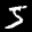

torch.Size([3, 32, 32])


In [12]:
batch_size_train = 256
batch_size_test = 256
batch_size_wm = 64

trainset = datasets.ImageFolder('./data/CIFAR10_8020/with_trigger/train/', transform=transform_train)
testset = datasets.ImageFolder('./data/CIFAR10_8020/test', transform=transform_test)
# valset = datasets.ImageFolder('./data/CIFAR10_8020/with_trigger/val/', transform=transform_test)
watermarkset = datasets.ImageFolder('./data/CIFAR10_8020/with_trigger/trigger_random/', transform=transform_test)
advwatermarkset = datasets.ImageFolder('./data/CIFAR10_8020/with_trigger/trigger_adv/', transform=transform_test)
unrelatedset = watermark_unrelated(count=100)
train_watermark_mixset = torch.utils.data.ConcatDataset((trainset,unrelatedset))

testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size_test, shuffle=False, num_workers=8)

# valloader = torch.utils.data.DataLoader(
# valset, batch_size=batch_size_test, shuffle=False, num_workers=8)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size_train, shuffle=True, num_workers=8, drop_last=False)

wmloader = torch.utils.data.DataLoader(
    watermarkset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)
unrelatedloader = torch.utils.data.DataLoader(
    unrelatedset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)
advwmloader = torch.utils.data.DataLoader(
    advwatermarkset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)
train_watermark_loader = torch.utils.data.DataLoader(
    train_watermark_mixset, batch_size=batch_size_train, shuffle=True, num_workers=8, drop_last=False)

In [13]:
# warm up with clean data
net = ResNet18()

lr, wd, gamma, epochs = 5e-4, 1e-4, 0.5, 10
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
criterion = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20,
                                                        gamma=gamma, verbose=True)

trainer = Trainer(net, criterion, optimizer, trainloader, trigger_loader=None, scheduler=lr_scheduler, use_trigger=False)
evaluator = Evaluator(net, criterion)
logcmt = f"resnet18_cifar10_8020 opt=Adam lr={lr} wd={wd} sched_gamma={gamma} ep={epochs}"
train(trainer, evaluator, testloader, epochs, 'checkpoints/resnet18_8020.ckpt', logdir='./runs', logcmt=logcmt)

Adjusting learning rate of group 0 to 5.0000e-04.
Start Training...


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [02:39<00:00,  1.02s/it]

Adjusting learning rate of group 0 to 5.0000e-04.


Epoch 0 | Time 165s| Train Loss 1.4756 | Train Acc 45.87| Val Loss 1.441 | Val Acc 49.34


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.34it/s]

Adjusting learning rate of group 0 to 5.0000e-04.


Epoch 1 | Time 180s| Train Loss 1.0316 | Train Acc 62.86| Val Loss 0.980 | Val Acc 65.42


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.19it/s]

Adjusting learning rate of group 0 to 5.0000e-04.


Epoch 2 | Time 196s| Train Loss 0.8317 | Train Acc 70.54| Val Loss 0.945 | Val Acc 68.29


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:14<00:00, 11.13it/s]

Adjusting learning rate of group 0 to 5.0000e-04.


Epoch 3 | Time 212s| Train Loss 0.7235 | Train Acc 74.70| Val Loss 0.791 | Val Acc 73.38


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:14<00:00, 11.09it/s]

Adjusting learning rate of group 0 to 5.0000e-04.


Epoch 4 | Time 227s| Train Loss 0.6465 | Train Acc 77.36| Val Loss 0.712 | Val Acc 76.01


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:14<00:00, 11.08it/s]

Adjusting learning rate of group 0 to 5.0000e-04.


Epoch 5 | Time 243s| Train Loss 0.5964 | Train Acc 79.22| Val Loss 0.770 | Val Acc 74.73


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:14<00:00, 11.06it/s]

Adjusting learning rate of group 0 to 5.0000e-04.


Epoch 6 | Time 259s| Train Loss 0.5540 | Train Acc 80.64| Val Loss 0.796 | Val Acc 74.81


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:14<00:00, 11.05it/s]

Adjusting learning rate of group 0 to 5.0000e-04.


Epoch 7 | Time 275s| Train Loss 0.5234 | Train Acc 81.90| Val Loss 0.748 | Val Acc 75.11


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:14<00:00, 11.05it/s]

Adjusting learning rate of group 0 to 5.0000e-04.


Epoch 8 | Time 290s| Train Loss 0.4851 | Train Acc 83.11| Val Loss 0.721 | Val Acc 76.94


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:14<00:00, 11.03it/s]

Adjusting learning rate of group 0 to 5.0000e-04.


Epoch 9 | Time 306s| Train Loss 0.4649 | Train Acc 83.70| Val Loss 0.620 | Val Acc 79.41


{'train_acc': [45.87174348697395,
  62.85821643286573,
  70.53857715430861,
  74.6993987975952,
  77.36472945891784,
  79.21843687374749,
  80.63877755511022,
  81.90130260521042,
  83.10871743486973,
  83.70490981963928],
 'train_loss': [1.4756436682416347,
  1.031634473943997,
  0.8316703452375943,
  0.7234732557394222,
  0.6465023474846192,
  0.596379251446657,
  0.5539942615495655,
  0.5233963850504889,
  0.48508945167184114,
  0.464894304390183],
 'val_acc': [49.34,
  65.42,
  68.28999999999999,
  73.38,
  76.01,
  74.72999999999999,
  74.81,
  75.11,
  76.94,
  79.41],
 'val_loss': [1.4411647971153259,
  0.9803834186077118,
  0.9446720234870911,
  0.7912511384546757,
  0.7121108279228211,
  0.7695322902679443,
  0.7962540919542312,
  0.7481305137634278,
  0.7209387130737305,
  0.6197880620718003],
 'trigger_acc': [],
 'trigger_loss': []}

In [14]:
# watermark with frozen layers
net = ResNet18()
logcmt = f"resnet18_8020_trigger_finetune"
net.load_state_dict(torch.load('checkpoints/resnet18_8020.ckpt'))
frozen_layers=[net.conv1, net.bn1, net.layer1, net.layer2, net.layer3, net.layer4]
optimizer = torch.optim.Adam(params=net.parameters(), lr=2e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, verbose=True)
trainer = Trainer(net, criterion, optimizer, train_loader=trainloader, trigger_loader=wmloader, use_trigger=True, scheduler=scheduler)
evaluator = Evaluator(net, criterion)
train(trainer, evaluator, testloader, 80, 'checkpoints/resnet18_wm_frozen_8020.ckpt', frozen_layers=frozen_layers,
      logdir='./runs', logcmt=logcmt, trigger_loader=wmloader)

Adjusting learning rate of group 0 to 2.0000e-04.
Start Training...


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.67it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 0 | Time 13s| Train Loss 1.3602 | Train Acc 71.24| Val Loss 0.619 | Val Acc 81.84| Trigger Loss 3.848 | Trigger Acc 2.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.83it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 1 | Time 27s| Train Loss 1.1073 | Train Acc 71.00| Val Loss 0.635 | Val Acc 81.57| Trigger Loss 3.467 | Trigger Acc 2.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:12<00:00, 12.23it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 2 | Time 42s| Train Loss 0.7699 | Train Acc 77.14| Val Loss 0.620 | Val Acc 79.08| Trigger Loss 0.569 | Trigger Acc 90.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 16.41it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 3 | Time 54s| Train Loss 0.4192 | Train Acc 86.67| Val Loss 0.544 | Val Acc 81.38| Trigger Loss 0.073 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:07<00:00, 19.52it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 4 | Time 64s| Train Loss 0.3400 | Train Acc 88.53| Val Loss 0.512 | Val Acc 82.57| Trigger Loss 0.023 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:07<00:00, 22.26it/s]


Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 5 | Time 74s| Train Loss 0.3081 | Train Acc 89.28| Val Loss 0.505 | Val Acc 83.10| Trigger Loss 0.011 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.11it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 6 | Time 88s| Train Loss 0.2921 | Train Acc 89.98| Val Loss 0.494 | Val Acc 83.84| Trigger Loss 0.033 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.25it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 7 | Time 102s| Train Loss 0.2944 | Train Acc 89.86| Val Loss 0.500 | Val Acc 83.51| Trigger Loss 0.024 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.80it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 8 | Time 117s| Train Loss 0.2997 | Train Acc 89.80| Val Loss 0.503 | Val Acc 83.45| Trigger Loss 0.040 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.74it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 9 | Time 130s| Train Loss 0.2992 | Train Acc 89.70| Val Loss 0.494 | Val Acc 84.10| Trigger Loss 0.028 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.78it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 10 | Time 140s| Train Loss 0.2767 | Train Acc 90.34| Val Loss 0.489 | Val Acc 84.07| Trigger Loss 0.016 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.33it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 11 | Time 149s| Train Loss 0.2650 | Train Acc 90.81| Val Loss 0.484 | Val Acc 84.84| Trigger Loss 0.006 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.13it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 12 | Time 163s| Train Loss 0.2522 | Train Acc 91.26| Val Loss 0.484 | Val Acc 84.47| Trigger Loss 0.010 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.26it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 13 | Time 177s| Train Loss 0.2448 | Train Acc 91.62| Val Loss 0.483 | Val Acc 84.49| Trigger Loss 0.010 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.81it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 14 | Time 193s| Train Loss 0.2488 | Train Acc 91.58| Val Loss 0.484 | Val Acc 84.49| Trigger Loss 0.015 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.76it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 15 | Time 205s| Train Loss 0.2433 | Train Acc 91.62| Val Loss 0.478 | Val Acc 84.81| Trigger Loss 0.011 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.82it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 16 | Time 216s| Train Loss 0.2486 | Train Acc 91.38| Val Loss 0.482 | Val Acc 84.59| Trigger Loss 0.008 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.34it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 17 | Time 225s| Train Loss 0.2383 | Train Acc 91.68| Val Loss 0.478 | Val Acc 84.92| Trigger Loss 0.004 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.13it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 18 | Time 239s| Train Loss 0.2238 | Train Acc 92.30| Val Loss 0.485 | Val Acc 84.57| Trigger Loss 0.007 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.25it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 19 | Time 253s| Train Loss 0.2207 | Train Acc 92.34| Val Loss 0.484 | Val Acc 84.83| Trigger Loss 0.006 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.81it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 20 | Time 269s| Train Loss 0.2202 | Train Acc 92.35| Val Loss 0.476 | Val Acc 85.06| Trigger Loss 0.007 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.73it/s]


Adjusting learning rate of group 0 to 5.0000e-05.
Epoch 21 | Time 281s| Train Loss 0.2113 | Train Acc 92.71| Val Loss 0.472 | Val Acc 85.21| Trigger Loss 0.005 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.79it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 22 | Time 291s| Train Loss 0.2117 | Train Acc 92.66| Val Loss 0.487 | Val Acc 84.55| Trigger Loss 0.004 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.31it/s]


Adjusting learning rate of group 0 to 5.0000e-05.
Epoch 23 | Time 301s| Train Loss 0.1957 | Train Acc 93.25| Val Loss 0.485 | Val Acc 85.04| Trigger Loss 0.003 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.14it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 24 | Time 315s| Train Loss 0.1935 | Train Acc 93.22| Val Loss 0.487 | Val Acc 85.18| Trigger Loss 0.003 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.24it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 25 | Time 329s| Train Loss 0.1857 | Train Acc 93.54| Val Loss 0.484 | Val Acc 85.34| Trigger Loss 0.003 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.82it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 26 | Time 344s| Train Loss 0.1902 | Train Acc 93.43| Val Loss 0.483 | Val Acc 85.45| Trigger Loss 0.004 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.69it/s]


Adjusting learning rate of group 0 to 5.0000e-05.
Epoch 27 | Time 356s| Train Loss 0.1882 | Train Acc 93.50| Val Loss 0.482 | Val Acc 85.64| Trigger Loss 0.004 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.79it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 28 | Time 367s| Train Loss 0.1907 | Train Acc 93.35| Val Loss 0.488 | Val Acc 85.47| Trigger Loss 0.003 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:07<00:00, 22.22it/s]


Adjusting learning rate of group 0 to 2.5000e-05.
Epoch 29 | Time 376s| Train Loss 0.1818 | Train Acc 93.71| Val Loss 0.499 | Val Acc 85.30| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.13it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 30 | Time 390s| Train Loss 0.1699 | Train Acc 94.06| Val Loss 0.487 | Val Acc 85.26| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.25it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 31 | Time 404s| Train Loss 0.1678 | Train Acc 94.25| Val Loss 0.484 | Val Acc 85.57| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.82it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 32 | Time 420s| Train Loss 0.1669 | Train Acc 94.20| Val Loss 0.479 | Val Acc 85.76| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.75it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 33 | Time 432s| Train Loss 0.1640 | Train Acc 94.30| Val Loss 0.476 | Val Acc 85.81| Trigger Loss 0.003 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.74it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 34 | Time 443s| Train Loss 0.1644 | Train Acc 94.25| Val Loss 0.476 | Val Acc 85.93| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.34it/s]


Adjusting learning rate of group 0 to 2.5000e-05.
Epoch 35 | Time 452s| Train Loss 0.1560 | Train Acc 94.59| Val Loss 0.484 | Val Acc 85.99| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.12it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 36 | Time 466s| Train Loss 0.1492 | Train Acc 94.83| Val Loss 0.486 | Val Acc 85.90| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.23it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 37 | Time 480s| Train Loss 0.1490 | Train Acc 94.74| Val Loss 0.485 | Val Acc 85.81| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.81it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 38 | Time 496s| Train Loss 0.1515 | Train Acc 94.74| Val Loss 0.488 | Val Acc 85.91| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.74it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 39 | Time 508s| Train Loss 0.1498 | Train Acc 94.75| Val Loss 0.486 | Val Acc 85.94| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.79it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 40 | Time 518s| Train Loss 0.1455 | Train Acc 95.00| Val Loss 0.482 | Val Acc 85.94| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:07<00:00, 22.27it/s]


Adjusting learning rate of group 0 to 1.2500e-05.
Epoch 41 | Time 527s| Train Loss 0.1402 | Train Acc 95.18| Val Loss 0.492 | Val Acc 85.84| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.12it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 42 | Time 542s| Train Loss 0.1372 | Train Acc 95.27| Val Loss 0.494 | Val Acc 85.87| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.23it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 43 | Time 556s| Train Loss 0.1378 | Train Acc 95.15| Val Loss 0.493 | Val Acc 85.75| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.82it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 44 | Time 571s| Train Loss 0.1362 | Train Acc 95.28| Val Loss 0.490 | Val Acc 86.13| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.69it/s]


Adjusting learning rate of group 0 to 1.2500e-05.
Epoch 45 | Time 584s| Train Loss 0.1386 | Train Acc 95.19| Val Loss 0.488 | Val Acc 86.15| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.75it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 46 | Time 594s| Train Loss 0.1367 | Train Acc 95.36| Val Loss 0.485 | Val Acc 86.08| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:07<00:00, 22.22it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 47 | Time 603s| Train Loss 0.1310 | Train Acc 95.56| Val Loss 0.493 | Val Acc 86.07| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.12it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 48 | Time 618s| Train Loss 0.1302 | Train Acc 95.36| Val Loss 0.495 | Val Acc 85.92| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.24it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 49 | Time 632s| Train Loss 0.1290 | Train Acc 95.56| Val Loss 0.494 | Val Acc 85.84| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.80it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 50 | Time 647s| Train Loss 0.1320 | Train Acc 95.41| Val Loss 0.491 | Val Acc 86.10| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.73it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 51 | Time 659s| Train Loss 0.1301 | Train Acc 95.57| Val Loss 0.492 | Val Acc 86.12| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.77it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 52 | Time 670s| Train Loss 0.1293 | Train Acc 95.56| Val Loss 0.490 | Val Acc 86.14| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:07<00:00, 22.19it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 53 | Time 679s| Train Loss 0.1278 | Train Acc 95.64| Val Loss 0.496 | Val Acc 86.26| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.11it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 54 | Time 693s| Train Loss 0.1230 | Train Acc 95.73| Val Loss 0.495 | Val Acc 86.24| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.26it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 55 | Time 707s| Train Loss 0.1241 | Train Acc 95.76| Val Loss 0.494 | Val Acc 86.16| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.81it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 56 | Time 723s| Train Loss 0.1250 | Train Acc 95.64| Val Loss 0.495 | Val Acc 86.22| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.70it/s]


Adjusting learning rate of group 0 to 6.2500e-06.
Epoch 57 | Time 735s| Train Loss 0.1235 | Train Acc 95.74| Val Loss 0.496 | Val Acc 86.10| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.77it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 58 | Time 746s| Train Loss 0.1262 | Train Acc 95.70| Val Loss 0.492 | Val Acc 86.27| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.29it/s]


Adjusting learning rate of group 0 to 3.1250e-06.
Epoch 59 | Time 755s| Train Loss 0.1210 | Train Acc 95.84| Val Loss 0.495 | Val Acc 86.29| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.13it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 60 | Time 769s| Train Loss 0.1203 | Train Acc 95.95| Val Loss 0.495 | Val Acc 86.39| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.25it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 61 | Time 783s| Train Loss 0.1195 | Train Acc 95.89| Val Loss 0.497 | Val Acc 86.29| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.80it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 62 | Time 798s| Train Loss 0.1201 | Train Acc 95.91| Val Loss 0.496 | Val Acc 86.23| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.75it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 63 | Time 811s| Train Loss 0.1189 | Train Acc 95.87| Val Loss 0.498 | Val Acc 86.30| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.78it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 64 | Time 821s| Train Loss 0.1182 | Train Acc 95.98| Val Loss 0.497 | Val Acc 86.27| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:07<00:00, 22.26it/s]


Adjusting learning rate of group 0 to 3.1250e-06.
Epoch 65 | Time 830s| Train Loss 0.1191 | Train Acc 95.91| Val Loss 0.499 | Val Acc 86.29| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.12it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 66 | Time 845s| Train Loss 0.1185 | Train Acc 95.93| Val Loss 0.498 | Val Acc 86.25| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.25it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 67 | Time 859s| Train Loss 0.1153 | Train Acc 96.08| Val Loss 0.499 | Val Acc 86.38| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.82it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 68 | Time 874s| Train Loss 0.1189 | Train Acc 95.84| Val Loss 0.496 | Val Acc 86.31| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.73it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 69 | Time 886s| Train Loss 0.1193 | Train Acc 95.91| Val Loss 0.497 | Val Acc 86.20| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.76it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 70 | Time 897s| Train Loss 0.1171 | Train Acc 95.99| Val Loss 0.497 | Val Acc 86.32| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.30it/s]


Adjusting learning rate of group 0 to 1.5625e-06.
Epoch 71 | Time 906s| Train Loss 0.1160 | Train Acc 96.03| Val Loss 0.498 | Val Acc 86.19| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.12it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 72 | Time 920s| Train Loss 0.1159 | Train Acc 96.09| Val Loss 0.499 | Val Acc 86.37| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.23it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 73 | Time 934s| Train Loss 0.1162 | Train Acc 96.10| Val Loss 0.498 | Val Acc 86.33| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.79it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 74 | Time 950s| Train Loss 0.1159 | Train Acc 96.00| Val Loss 0.500 | Val Acc 86.37| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.68it/s]


Adjusting learning rate of group 0 to 1.5625e-06.
Epoch 75 | Time 962s| Train Loss 0.1169 | Train Acc 96.04| Val Loss 0.499 | Val Acc 86.25| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.82it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 76 | Time 973s| Train Loss 0.1180 | Train Acc 95.98| Val Loss 0.498 | Val Acc 86.31| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:07<00:00, 22.27it/s]


Adjusting learning rate of group 0 to 1.5625e-06.
Epoch 77 | Time 982s| Train Loss 0.1154 | Train Acc 95.96| Val Loss 0.498 | Val Acc 86.36| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.12it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 78 | Time 996s| Train Loss 0.1132 | Train Acc 96.05| Val Loss 0.498 | Val Acc 86.37| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.22it/s]

Adjusting learning rate of group 0 to 7.8125e-07.


Epoch 79 | Time 1010s| Train Loss 0.1158 | Train Acc 96.09| Val Loss 0.500 | Val Acc 86.39| Trigger Loss 0.001 | Trigger Acc 100.00


{'train_acc': [71.24266554903605,
  71.00167644593462,
  77.139564124057,
  86.67225481978205,
  88.53101424979045,
  89.27703269069572,
  89.97694886839899,
  89.85959765297568,
  89.80092204526404,
  89.70452640402347,
  90.34157585917855,
  90.80678960603521,
  91.25523889354568,
  91.61567476948869,
  91.58424140821458,
  91.61567476948869,
  91.38306789606035,
  91.68273260687343,
  92.30301760268232,
  92.33654652137469,
  92.3512154233026,
  92.70746018440906,
  92.6571668063705,
  93.2523051131601,
  93.21877619446772,
  93.53730092204526,
  93.42833193629505,
  93.49958088851635,
  93.34870075440067,
  93.71332774518022,
  94.05699916177703,
  94.24979044425818,
  94.20368818105615,
  94.302179379715,
  94.24979044425818,
  94.58927074601844,
  94.82606873428333,
  94.7422464375524,
  94.73805532271584,
  94.74853310980721,
  95.00209555741827,
  95.18231349538976,
  95.26823134953898,
  95.15297569153395,
  95.2829002514669,
  95.18650461022632,
  95.36462699077954,
  95.5574

In [15]:
# rowback baseline
net = ResNet18()
logcmt = f"resnet18_8020_trigger_finetune"
net.load_state_dict(torch.load('checkpoints/resnet18_8020.ckpt'))
frozen_layers=[net.conv1, net.bn1, net.layer1, net.layer2, net.layer3, net.layer4]
optimizer = torch.optim.Adam(params=net.parameters(), lr=2e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, verbose=True)
trainer = Trainer(net, criterion, optimizer, train_loader=trainloader, trigger_loader=advwmloader, use_trigger=True, scheduler=scheduler)
evaluator = Evaluator(net, criterion)
train(trainer, evaluator, testloader, 80, 'checkpoints/resnet18_wm_rowback_8020.ckpt', frozen_layers=frozen_layers,
      logdir='./runs', logcmt=logcmt, trigger_loader=advwmloader)

Adjusting learning rate of group 0 to 2.0000e-04.
Start Training...


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.75it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 0 | Time 13s| Train Loss 1.2233 | Train Acc 71.23| Val Loss 0.596 | Val Acc 81.16| Trigger Loss 3.388 | Trigger Acc 4.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.84it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 1 | Time 27s| Train Loss 0.9989 | Train Acc 71.05| Val Loss 0.617 | Val Acc 80.62| Trigger Loss 2.994 | Trigger Acc 6.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:12<00:00, 12.24it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 2 | Time 42s| Train Loss 0.6969 | Train Acc 78.42| Val Loss 0.582 | Val Acc 80.35| Trigger Loss 0.702 | Trigger Acc 80.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 16.46it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 3 | Time 54s| Train Loss 0.4054 | Train Acc 87.39| Val Loss 0.517 | Val Acc 82.67| Trigger Loss 0.094 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:07<00:00, 19.56it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 4 | Time 64s| Train Loss 0.3280 | Train Acc 89.07| Val Loss 0.505 | Val Acc 83.35| Trigger Loss 0.032 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.32it/s]


Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 5 | Time 74s| Train Loss 0.2957 | Train Acc 89.81| Val Loss 0.511 | Val Acc 83.62| Trigger Loss 0.011 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.12it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 6 | Time 88s| Train Loss 0.2788 | Train Acc 90.47| Val Loss 0.498 | Val Acc 84.07| Trigger Loss 0.022 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.23it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 7 | Time 102s| Train Loss 0.2796 | Train Acc 90.42| Val Loss 0.497 | Val Acc 84.15| Trigger Loss 0.021 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.80it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 8 | Time 117s| Train Loss 0.2955 | Train Acc 90.19| Val Loss 0.507 | Val Acc 83.59| Trigger Loss 0.061 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.73it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 9 | Time 129s| Train Loss 0.2907 | Train Acc 89.94| Val Loss 0.527 | Val Acc 82.98| Trigger Loss 0.033 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.80it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 10 | Time 140s| Train Loss 0.2684 | Train Acc 90.78| Val Loss 0.488 | Val Acc 84.13| Trigger Loss 0.012 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.29it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 11 | Time 149s| Train Loss 0.2589 | Train Acc 90.92| Val Loss 0.500 | Val Acc 84.42| Trigger Loss 0.008 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.14it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 12 | Time 163s| Train Loss 0.2468 | Train Acc 91.52| Val Loss 0.491 | Val Acc 84.59| Trigger Loss 0.012 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.26it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 13 | Time 177s| Train Loss 0.2428 | Train Acc 91.64| Val Loss 0.490 | Val Acc 84.62| Trigger Loss 0.011 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.79it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 14 | Time 193s| Train Loss 0.2418 | Train Acc 91.65| Val Loss 0.493 | Val Acc 84.62| Trigger Loss 0.015 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.69it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 15 | Time 205s| Train Loss 0.2378 | Train Acc 91.76| Val Loss 0.482 | Val Acc 85.06| Trigger Loss 0.020 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.76it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 16 | Time 216s| Train Loss 0.2486 | Train Acc 91.38| Val Loss 0.535 | Val Acc 83.51| Trigger Loss 0.016 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.30it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 17 | Time 225s| Train Loss 0.2300 | Train Acc 91.99| Val Loss 0.523 | Val Acc 84.01| Trigger Loss 0.006 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.08it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 18 | Time 239s| Train Loss 0.2281 | Train Acc 92.08| Val Loss 0.511 | Val Acc 84.47| Trigger Loss 0.008 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.24it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 19 | Time 253s| Train Loss 0.2178 | Train Acc 92.43| Val Loss 0.505 | Val Acc 84.59| Trigger Loss 0.008 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.78it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 20 | Time 269s| Train Loss 0.2157 | Train Acc 92.58| Val Loss 0.503 | Val Acc 84.53| Trigger Loss 0.006 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.72it/s]


Adjusting learning rate of group 0 to 5.0000e-05.
Epoch 21 | Time 281s| Train Loss 0.2122 | Train Acc 92.70| Val Loss 0.489 | Val Acc 85.16| Trigger Loss 0.006 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.79it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 22 | Time 291s| Train Loss 0.2069 | Train Acc 92.77| Val Loss 0.478 | Val Acc 85.46| Trigger Loss 0.006 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.32it/s]


Adjusting learning rate of group 0 to 5.0000e-05.
Epoch 23 | Time 301s| Train Loss 0.1909 | Train Acc 93.33| Val Loss 0.496 | Val Acc 85.03| Trigger Loss 0.003 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.12it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 24 | Time 315s| Train Loss 0.1820 | Train Acc 93.70| Val Loss 0.491 | Val Acc 85.35| Trigger Loss 0.003 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.26it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 25 | Time 329s| Train Loss 0.1806 | Train Acc 93.73| Val Loss 0.490 | Val Acc 85.48| Trigger Loss 0.003 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.82it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 26 | Time 344s| Train Loss 0.1835 | Train Acc 93.63| Val Loss 0.491 | Val Acc 85.25| Trigger Loss 0.005 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.76it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 27 | Time 356s| Train Loss 0.1835 | Train Acc 93.64| Val Loss 0.493 | Val Acc 85.32| Trigger Loss 0.004 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.78it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 28 | Time 367s| Train Loss 0.1858 | Train Acc 93.45| Val Loss 0.487 | Val Acc 85.62| Trigger Loss 0.003 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.30it/s]


Adjusting learning rate of group 0 to 2.5000e-05.
Epoch 29 | Time 376s| Train Loss 0.1768 | Train Acc 93.89| Val Loss 0.503 | Val Acc 85.53| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.13it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 30 | Time 390s| Train Loss 0.1631 | Train Acc 94.26| Val Loss 0.495 | Val Acc 85.75| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.25it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 31 | Time 405s| Train Loss 0.1607 | Train Acc 94.35| Val Loss 0.498 | Val Acc 85.71| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.79it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 32 | Time 420s| Train Loss 0.1637 | Train Acc 94.41| Val Loss 0.498 | Val Acc 85.78| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.74it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 33 | Time 432s| Train Loss 0.1613 | Train Acc 94.33| Val Loss 0.492 | Val Acc 85.78| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.81it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 34 | Time 443s| Train Loss 0.1597 | Train Acc 94.46| Val Loss 0.495 | Val Acc 85.78| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:07<00:00, 22.18it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 35 | Time 452s| Train Loss 0.1485 | Train Acc 94.91| Val Loss 0.512 | Val Acc 85.86| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.14it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 36 | Time 466s| Train Loss 0.1437 | Train Acc 95.08| Val Loss 0.509 | Val Acc 85.90| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.25it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 37 | Time 480s| Train Loss 0.1446 | Train Acc 95.10| Val Loss 0.510 | Val Acc 85.94| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.82it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 38 | Time 496s| Train Loss 0.1469 | Train Acc 94.88| Val Loss 0.504 | Val Acc 86.29| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.71it/s]


Adjusting learning rate of group 0 to 1.2500e-05.
Epoch 39 | Time 508s| Train Loss 0.1445 | Train Acc 95.09| Val Loss 0.503 | Val Acc 86.01| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.77it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 40 | Time 518s| Train Loss 0.1410 | Train Acc 95.12| Val Loss 0.501 | Val Acc 86.34| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.30it/s]


Adjusting learning rate of group 0 to 1.2500e-05.
Epoch 41 | Time 528s| Train Loss 0.1362 | Train Acc 95.31| Val Loss 0.508 | Val Acc 86.24| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.14it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 42 | Time 542s| Train Loss 0.1329 | Train Acc 95.35| Val Loss 0.504 | Val Acc 86.05| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.25it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 43 | Time 556s| Train Loss 0.1306 | Train Acc 95.48| Val Loss 0.503 | Val Acc 86.13| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.80it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 44 | Time 571s| Train Loss 0.1345 | Train Acc 95.32| Val Loss 0.500 | Val Acc 86.27| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.72it/s]


Adjusting learning rate of group 0 to 1.2500e-05.
Epoch 45 | Time 584s| Train Loss 0.1310 | Train Acc 95.50| Val Loss 0.500 | Val Acc 86.26| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.79it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 46 | Time 594s| Train Loss 0.1336 | Train Acc 95.32| Val Loss 0.503 | Val Acc 86.24| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.32it/s]


Adjusting learning rate of group 0 to 1.2500e-05.
Epoch 47 | Time 603s| Train Loss 0.1304 | Train Acc 95.55| Val Loss 0.508 | Val Acc 86.08| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.13it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 48 | Time 618s| Train Loss 0.1248 | Train Acc 95.76| Val Loss 0.506 | Val Acc 86.23| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.23it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 49 | Time 632s| Train Loss 0.1247 | Train Acc 95.72| Val Loss 0.506 | Val Acc 86.26| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.80it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 50 | Time 647s| Train Loss 0.1261 | Train Acc 95.67| Val Loss 0.507 | Val Acc 86.23| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.71it/s]


Adjusting learning rate of group 0 to 6.2500e-06.
Epoch 51 | Time 659s| Train Loss 0.1235 | Train Acc 95.80| Val Loss 0.505 | Val Acc 86.25| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.77it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 52 | Time 670s| Train Loss 0.1234 | Train Acc 95.74| Val Loss 0.504 | Val Acc 86.36| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.30it/s]


Adjusting learning rate of group 0 to 6.2500e-06.
Epoch 53 | Time 679s| Train Loss 0.1211 | Train Acc 95.83| Val Loss 0.508 | Val Acc 86.35| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.11it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 54 | Time 693s| Train Loss 0.1202 | Train Acc 95.87| Val Loss 0.511 | Val Acc 86.36| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.23it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 55 | Time 707s| Train Loss 0.1170 | Train Acc 96.01| Val Loss 0.509 | Val Acc 86.45| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.80it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 56 | Time 723s| Train Loss 0.1188 | Train Acc 95.92| Val Loss 0.509 | Val Acc 86.35| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.72it/s]


Adjusting learning rate of group 0 to 6.2500e-06.
Epoch 57 | Time 735s| Train Loss 0.1189 | Train Acc 95.92| Val Loss 0.509 | Val Acc 86.37| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.80it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 58 | Time 745s| Train Loss 0.1211 | Train Acc 95.74| Val Loss 0.510 | Val Acc 86.38| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:07<00:00, 22.13it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 59 | Time 755s| Train Loss 0.1156 | Train Acc 96.08| Val Loss 0.512 | Val Acc 86.36| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.09it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 60 | Time 769s| Train Loss 0.1154 | Train Acc 96.12| Val Loss 0.511 | Val Acc 86.40| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.25it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 61 | Time 783s| Train Loss 0.1150 | Train Acc 96.02| Val Loss 0.513 | Val Acc 86.57| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.82it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 62 | Time 798s| Train Loss 0.1141 | Train Acc 96.00| Val Loss 0.514 | Val Acc 86.37| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.71it/s]


Adjusting learning rate of group 0 to 3.1250e-06.
Epoch 63 | Time 810s| Train Loss 0.1142 | Train Acc 96.08| Val Loss 0.513 | Val Acc 86.39| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.77it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 64 | Time 821s| Train Loss 0.1153 | Train Acc 96.00| Val Loss 0.516 | Val Acc 86.37| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.32it/s]


Adjusting learning rate of group 0 to 3.1250e-06.
Epoch 65 | Time 830s| Train Loss 0.1163 | Train Acc 96.00| Val Loss 0.515 | Val Acc 86.39| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.15it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 66 | Time 844s| Train Loss 0.1113 | Train Acc 96.16| Val Loss 0.514 | Val Acc 86.38| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.23it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 67 | Time 859s| Train Loss 0.1115 | Train Acc 96.16| Val Loss 0.518 | Val Acc 86.24| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.80it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 68 | Time 874s| Train Loss 0.1117 | Train Acc 96.22| Val Loss 0.515 | Val Acc 86.47| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.71it/s]


Adjusting learning rate of group 0 to 1.5625e-06.
Epoch 69 | Time 886s| Train Loss 0.1146 | Train Acc 96.03| Val Loss 0.515 | Val Acc 86.38| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.81it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 70 | Time 897s| Train Loss 0.1127 | Train Acc 96.04| Val Loss 0.515 | Val Acc 86.33| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.30it/s]


Adjusting learning rate of group 0 to 1.5625e-06.
Epoch 71 | Time 906s| Train Loss 0.1117 | Train Acc 96.19| Val Loss 0.516 | Val Acc 86.38| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.12it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 72 | Time 920s| Train Loss 0.1121 | Train Acc 96.14| Val Loss 0.516 | Val Acc 86.40| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.25it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 73 | Time 934s| Train Loss 0.1102 | Train Acc 96.19| Val Loss 0.517 | Val Acc 86.45| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.82it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 74 | Time 950s| Train Loss 0.1104 | Train Acc 96.24| Val Loss 0.516 | Val Acc 86.50| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.75it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 75 | Time 962s| Train Loss 0.1102 | Train Acc 96.21| Val Loss 0.514 | Val Acc 86.46| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.81it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 76 | Time 972s| Train Loss 0.1111 | Train Acc 96.19| Val Loss 0.516 | Val Acc 86.36| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.32it/s]


Adjusting learning rate of group 0 to 1.5625e-06.
Epoch 77 | Time 982s| Train Loss 0.1110 | Train Acc 96.24| Val Loss 0.518 | Val Acc 86.45| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.14it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 78 | Time 996s| Train Loss 0.1098 | Train Acc 96.23| Val Loss 0.516 | Val Acc 86.46| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.25it/s]

Adjusting learning rate of group 0 to 7.8125e-07.


Epoch 79 | Time 1010s| Train Loss 0.1085 | Train Acc 96.24| Val Loss 0.517 | Val Acc 86.39| Trigger Loss 0.001 | Trigger Acc 100.00


{'train_acc': [71.23428331936294,
  71.04777870913664,
  78.41785414920369,
  87.39312657166806,
  89.07376362112322,
  89.80511316010059,
  90.46940486169322,
  90.42120704107293,
  90.19279128248114,
  89.93922883487008,
  90.78373847443419,
  90.9157585917854,
  91.51718357082984,
  91.63663034367143,
  91.6533948030176,
  91.76026823134954,
  91.37678122380554,
  91.98868398994132,
  92.08088851634535,
  92.43084660519698,
  92.57544006705784,
  92.69698239731768,
  92.7745180217938,
  93.32564962279967,
  93.6986588432523,
  93.72799664710814,
  93.63160100586757,
  93.63579212070411,
  93.45347862531433,
  93.89145012573344,
  94.256077116513,
  94.35456831517183,
  94.40695725062866,
  94.32942162615255,
  94.45515507124895,
  94.9056999161777,
  95.07963118189438,
  95.09639564124058,
  94.87636211232187,
  95.0859178541492,
  95.11525565800503,
  95.30804694048616,
  95.34995808885164,
  95.48197820620285,
  95.32062028499581,
  95.49664710813076,
  95.32271584241408,
  95.553

In [16]:
# normal watermark
net = ResNet18()
logcmt = f"resnet18_8020_trigger_finetune"
net.load_state_dict(torch.load('checkpoints/resnet18_8020.ckpt'))
optimizer = torch.optim.Adam(params=net.parameters(), lr=2e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, verbose=True)
trainer = Trainer(net, criterion, optimizer, train_loader=trainloader, trigger_loader=wmloader, use_trigger=True, scheduler=scheduler)
evaluator = Evaluator(net, criterion)
train(trainer, evaluator, testloader, 80, 'checkpoints/resnet18_wm_8020.ckpt',
      logdir='./runs', logcmt=logcmt, trigger_loader=wmloader)

Adjusting learning rate of group 0 to 2.0000e-04.
Start Training...


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 0 | Time 18s| Train Loss 0.4423 | Train Acc 86.23| Val Loss 0.527 | Val Acc 82.16| Trigger Loss 0.053 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 1 | Time 38s| Train Loss 0.2906 | Train Acc 89.89| Val Loss 0.502 | Val Acc 83.21| Trigger Loss 0.025 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.35it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 2 | Time 57s| Train Loss 0.2690 | Train Acc 90.73| Val Loss 0.526 | Val Acc 82.70| Trigger Loss 0.028 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 3 | Time 76s| Train Loss 0.2529 | Train Acc 91.24| Val Loss 0.547 | Val Acc 82.37| Trigger Loss 0.022 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 4 | Time 95s| Train Loss 0.2402 | Train Acc 91.52| Val Loss 0.551 | Val Acc 83.11| Trigger Loss 0.027 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 5 | Time 114s| Train Loss 0.2267 | Train Acc 92.08| Val Loss 0.497 | Val Acc 84.21| Trigger Loss 0.017 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 6 | Time 133s| Train Loss 0.2177 | Train Acc 92.41| Val Loss 0.550 | Val Acc 83.34| Trigger Loss 0.018 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 7 | Time 152s| Train Loss 0.1997 | Train Acc 92.96| Val Loss 0.521 | Val Acc 84.11| Trigger Loss 0.011 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.35it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 8 | Time 170s| Train Loss 0.1910 | Train Acc 93.22| Val Loss 0.518 | Val Acc 84.27| Trigger Loss 0.008 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 9 | Time 189s| Train Loss 0.1855 | Train Acc 93.50| Val Loss 0.579 | Val Acc 83.65| Trigger Loss 0.014 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 10 | Time 208s| Train Loss 0.1317 | Train Acc 95.55| Val Loss 0.438 | Val Acc 86.62| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 11 | Time 227s| Train Loss 0.1107 | Train Acc 96.41| Val Loss 0.438 | Val Acc 86.85| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 12 | Time 246s| Train Loss 0.1022 | Train Acc 96.64| Val Loss 0.446 | Val Acc 87.09| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 13 | Time 265s| Train Loss 0.0975 | Train Acc 96.74| Val Loss 0.453 | Val Acc 87.11| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 14 | Time 284s| Train Loss 0.0926 | Train Acc 96.93| Val Loss 0.453 | Val Acc 87.46| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 15 | Time 303s| Train Loss 0.0869 | Train Acc 97.17| Val Loss 0.457 | Val Acc 87.10| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 16 | Time 322s| Train Loss 0.0856 | Train Acc 97.20| Val Loss 0.464 | Val Acc 87.33| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 17 | Time 341s| Train Loss 0.0807 | Train Acc 97.35| Val Loss 0.469 | Val Acc 87.15| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.34it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 18 | Time 360s| Train Loss 0.0793 | Train Acc 97.34| Val Loss 0.477 | Val Acc 87.00| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 19 | Time 379s| Train Loss 0.0752 | Train Acc 97.52| Val Loss 0.477 | Val Acc 87.01| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 20 | Time 397s| Train Loss 0.0696 | Train Acc 97.72| Val Loss 0.475 | Val Acc 87.31| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 21 | Time 416s| Train Loss 0.0690 | Train Acc 97.77| Val Loss 0.475 | Val Acc 87.29| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.35it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 22 | Time 435s| Train Loss 0.0678 | Train Acc 97.81| Val Loss 0.474 | Val Acc 87.22| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 23 | Time 454s| Train Loss 0.0673 | Train Acc 97.88| Val Loss 0.475 | Val Acc 87.23| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 24 | Time 473s| Train Loss 0.0653 | Train Acc 97.93| Val Loss 0.475 | Val Acc 87.32| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 25 | Time 492s| Train Loss 0.0681 | Train Acc 97.76| Val Loss 0.476 | Val Acc 87.38| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.35it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 26 | Time 511s| Train Loss 0.0641 | Train Acc 97.98| Val Loss 0.476 | Val Acc 87.36| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 27 | Time 530s| Train Loss 0.0634 | Train Acc 97.92| Val Loss 0.477 | Val Acc 87.40| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 28 | Time 549s| Train Loss 0.0634 | Train Acc 98.01| Val Loss 0.476 | Val Acc 87.28| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 29 | Time 568s| Train Loss 0.0646 | Train Acc 97.91| Val Loss 0.479 | Val Acc 87.32| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 30 | Time 587s| Train Loss 0.0629 | Train Acc 97.99| Val Loss 0.479 | Val Acc 87.28| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 31 | Time 606s| Train Loss 0.0622 | Train Acc 98.01| Val Loss 0.479 | Val Acc 87.40| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 32 | Time 625s| Train Loss 0.0641 | Train Acc 97.99| Val Loss 0.479 | Val Acc 87.33| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 33 | Time 643s| Train Loss 0.0652 | Train Acc 97.85| Val Loss 0.479 | Val Acc 87.38| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 34 | Time 662s| Train Loss 0.0608 | Train Acc 98.10| Val Loss 0.478 | Val Acc 87.35| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 35 | Time 681s| Train Loss 0.0639 | Train Acc 97.92| Val Loss 0.480 | Val Acc 87.29| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.33it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 36 | Time 700s| Train Loss 0.0648 | Train Acc 97.88| Val Loss 0.479 | Val Acc 87.29| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 37 | Time 719s| Train Loss 0.0652 | Train Acc 97.91| Val Loss 0.477 | Val Acc 87.30| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 38 | Time 738s| Train Loss 0.0625 | Train Acc 98.02| Val Loss 0.478 | Val Acc 87.38| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 39 | Time 757s| Train Loss 0.0617 | Train Acc 98.07| Val Loss 0.479 | Val Acc 87.25| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 40 | Time 776s| Train Loss 0.0646 | Train Acc 97.91| Val Loss 0.481 | Val Acc 87.34| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 41 | Time 795s| Train Loss 0.0616 | Train Acc 98.02| Val Loss 0.480 | Val Acc 87.30| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 42 | Time 814s| Train Loss 0.0625 | Train Acc 98.08| Val Loss 0.480 | Val Acc 87.33| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.34it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 43 | Time 833s| Train Loss 0.0626 | Train Acc 98.02| Val Loss 0.480 | Val Acc 87.35| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.35it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 44 | Time 852s| Train Loss 0.0615 | Train Acc 98.11| Val Loss 0.478 | Val Acc 87.35| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 45 | Time 871s| Train Loss 0.0620 | Train Acc 98.03| Val Loss 0.478 | Val Acc 87.20| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 46 | Time 889s| Train Loss 0.0613 | Train Acc 98.03| Val Loss 0.479 | Val Acc 87.34| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 47 | Time 908s| Train Loss 0.0628 | Train Acc 97.93| Val Loss 0.479 | Val Acc 87.36| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.35it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 48 | Time 927s| Train Loss 0.0636 | Train Acc 97.99| Val Loss 0.478 | Val Acc 87.26| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 49 | Time 946s| Train Loss 0.0629 | Train Acc 97.92| Val Loss 0.480 | Val Acc 87.33| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 50 | Time 965s| Train Loss 0.0624 | Train Acc 98.03| Val Loss 0.477 | Val Acc 87.29| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.35it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 51 | Time 984s| Train Loss 0.0635 | Train Acc 97.95| Val Loss 0.480 | Val Acc 87.29| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 52 | Time 1003s| Train Loss 0.0638 | Train Acc 97.98| Val Loss 0.479 | Val Acc 87.41| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.35it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 53 | Time 1022s| Train Loss 0.0628 | Train Acc 97.98| Val Loss 0.479 | Val Acc 87.34| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.34it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 54 | Time 1041s| Train Loss 0.0621 | Train Acc 98.01| Val Loss 0.480 | Val Acc 87.35| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 55 | Time 1060s| Train Loss 0.0619 | Train Acc 98.03| Val Loss 0.478 | Val Acc 87.29| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.34it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 56 | Time 1079s| Train Loss 0.0627 | Train Acc 98.04| Val Loss 0.478 | Val Acc 87.35| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 57 | Time 1098s| Train Loss 0.0642 | Train Acc 97.98| Val Loss 0.479 | Val Acc 87.31| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 58 | Time 1117s| Train Loss 0.0629 | Train Acc 97.95| Val Loss 0.478 | Val Acc 87.28| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 59 | Time 1136s| Train Loss 0.0619 | Train Acc 97.99| Val Loss 0.478 | Val Acc 87.33| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 60 | Time 1155s| Train Loss 0.0610 | Train Acc 98.04| Val Loss 0.480 | Val Acc 87.35| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.35it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 61 | Time 1173s| Train Loss 0.0634 | Train Acc 97.98| Val Loss 0.479 | Val Acc 87.33| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 62 | Time 1192s| Train Loss 0.0642 | Train Acc 97.98| Val Loss 0.480 | Val Acc 87.28| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 63 | Time 1211s| Train Loss 0.0642 | Train Acc 97.88| Val Loss 0.478 | Val Acc 87.33| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 64 | Time 1230s| Train Loss 0.0631 | Train Acc 98.00| Val Loss 0.478 | Val Acc 87.32| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 65 | Time 1249s| Train Loss 0.0647 | Train Acc 97.94| Val Loss 0.480 | Val Acc 87.38| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 66 | Time 1268s| Train Loss 0.0623 | Train Acc 98.03| Val Loss 0.478 | Val Acc 87.36| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 67 | Time 1287s| Train Loss 0.0616 | Train Acc 98.11| Val Loss 0.480 | Val Acc 87.30| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 68 | Time 1306s| Train Loss 0.0619 | Train Acc 98.06| Val Loss 0.480 | Val Acc 87.33| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 69 | Time 1325s| Train Loss 0.0632 | Train Acc 97.96| Val Loss 0.479 | Val Acc 87.32| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.35it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 70 | Time 1344s| Train Loss 0.0626 | Train Acc 97.97| Val Loss 0.480 | Val Acc 87.34| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 71 | Time 1363s| Train Loss 0.0618 | Train Acc 98.01| Val Loss 0.480 | Val Acc 87.27| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 72 | Time 1382s| Train Loss 0.0624 | Train Acc 98.00| Val Loss 0.481 | Val Acc 87.29| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 73 | Time 1401s| Train Loss 0.0617 | Train Acc 98.01| Val Loss 0.479 | Val Acc 87.28| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 74 | Time 1420s| Train Loss 0.0620 | Train Acc 98.11| Val Loss 0.477 | Val Acc 87.35| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 75 | Time 1439s| Train Loss 0.0624 | Train Acc 98.00| Val Loss 0.479 | Val Acc 87.29| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 76 | Time 1458s| Train Loss 0.0622 | Train Acc 98.04| Val Loss 0.480 | Val Acc 87.27| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 77 | Time 1477s| Train Loss 0.0626 | Train Acc 97.97| Val Loss 0.479 | Val Acc 87.31| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 78 | Time 1495s| Train Loss 0.0631 | Train Acc 98.05| Val Loss 0.479 | Val Acc 87.31| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-12.


Epoch 79 | Time 1514s| Train Loss 0.0635 | Train Acc 98.00| Val Loss 0.479 | Val Acc 87.21| Trigger Loss 0.000 | Trigger Acc 100.00


{'train_acc': [86.22799664710813,
  89.88683989941325,
  90.72715842414082,
  91.23637887678122,
  91.51927912824812,
  92.08298407376361,
  92.41198658843253,
  92.95892707460185,
  93.22296730930427,
  93.49538977367979,
  95.54903604358759,
  96.40611902766136,
  96.64082145850796,
  96.73512154233026,
  96.93419949706622,
  97.17309304274937,
  97.19614417435038,
  97.34702430846606,
  97.3428331936295,
  97.51886001676446,
  97.72422464375524,
  97.77242246437552,
  97.80595138306789,
  97.87720033528919,
  97.93378038558257,
  97.75775356244762,
  97.98407376362113,
  97.9233025984912,
  98.00502933780385,
  97.91282481139983,
  97.9861693210394,
  98.01341156747695,
  97.9861693210394,
  97.85414920368818,
  98.09513830678961,
  97.9233025984912,
  97.88139145012573,
  97.90863369656329,
  98.02388935456831,
  98.06580050293377,
  97.91072925398156,
  98.01550712489522,
  98.07837384744343,
  98.01969823973177,
  98.1119027661358,
  98.03436714165969,
  98.0322715842414,
  97.93

In [17]:
net = ResNet18()
optimizer = torch.optim.SGD(net.parameters(), lr=0.05, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

train_certified_wm(
    net,
    train_watermark_loader,
    unrelatedloader,
    testloader,
    optimizer,
    scheduler,
    cert_type='random_8020',
    epochs=100,
    warmup_epochs=10
)

Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.31it/s]


Epoch 0
Train: Train acc 35.629685157421285 | WM acc 0.0
Tests: WM acc 100.0 | WM train avg acc 9.2 | Test acc 42.94
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.52it/s]


Epoch 1
Train: Train acc 52.04397801099451 | WM acc 0.0
Tests: WM acc 100.0 | WM train avg acc 13.81 | Test acc 55.22
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.55it/s]


Epoch 2
Train: Train acc 61.301849075462265 | WM acc 0.0
Tests: WM acc 80.0 | WM train avg acc 4.82 | Test acc 59.88
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.57it/s]


Epoch 3
Train: Train acc 66.86906546726637 | WM acc 0.0
Tests: WM acc 56.99999999999999 | WM train avg acc 9.87 | Test acc 60.629999999999995
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.54it/s]


Epoch 4
Train: Train acc 71.64417791104448 | WM acc 0.0
Tests: WM acc 99.0 | WM train avg acc 11.44 | Test acc 70.86
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.53it/s]


Epoch 5
Train: Train acc 75.2423788105947 | WM acc 0.0
Tests: WM acc 28.999999999999996 | WM train avg acc 9.3 | Test acc 73.82
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.53it/s]


Epoch 6
Train: Train acc 77.05647176411794 | WM acc 0.0
Tests: WM acc 100.0 | WM train avg acc 8.85 | Test acc 74.63
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.54it/s]


Epoch 7
Train: Train acc 78.69315342328835 | WM acc 0.0
Tests: WM acc 100.0 | WM train avg acc 11.7 | Test acc 75.33999999999999
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.49it/s]


Epoch 8
Train: Train acc 80.2023988005997 | WM acc 0.0
Tests: WM acc 100.0 | WM train avg acc 6.73 | Test acc 76.05
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.52it/s]


Epoch 9
Train: Train acc 81.10694652673664 | WM acc 0.0
Tests: WM acc 100.0 | WM train avg acc 10.23 | Test acc 75.21
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.54it/s]


Epoch 10
Train: Train acc 82.47126436781609 | WM acc 0.0
Tests: WM acc 100.0 | WM train avg acc 9.35 | Test acc 77.22
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.33it/s]


Epoch 11
Train: Train acc 36.16441779110445 | WM acc 100.0
Tests: WM acc 42.0 | WM train avg acc 0.07 | Test acc 48.22
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.32it/s]


Epoch 12
Train: Train acc 56.291854072963524 | WM acc 36.0
Tests: WM acc 88.0 | WM train avg acc 64.84 | Test acc 62.660000000000004
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.34it/s]


Epoch 13
Train: Train acc 69.03548225887056 | WM acc 100.0
Tests: WM acc 86.0 | WM train avg acc 60.12 | Test acc 72.16
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.34it/s]


Epoch 14
Train: Train acc 73.96301849075462 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 69.27 | Test acc 73.36
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.33it/s]


Epoch 15
Train: Train acc 77.5087456271864 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 77.11 | Test acc 74.71
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.32it/s]


Epoch 16
Train: Train acc 79.77511244377811 | WM acc 70.0
Tests: WM acc 100.0 | WM train avg acc 67.65 | Test acc 79.16
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.34it/s]


Epoch 17
Train: Train acc 81.45177411294353 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 76.37 | Test acc 78.09
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.34it/s]


Epoch 18
Train: Train acc 82.41629185407297 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 78.77 | Test acc 81.33
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.33it/s]


Epoch 19
Train: Train acc 83.64817591204398 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 74.08 | Test acc 79.97999999999999
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.34it/s]


Epoch 20
Train: Train acc 84.14542728635682 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 84.52 | Test acc 77.96
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.34it/s]


Epoch 21
Train: Train acc 84.37031484257871 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 79.06 | Test acc 81.91000000000001
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.33it/s]


Epoch 22
Train: Train acc 85.53223388305847 | WM acc 63.0
Tests: WM acc 100.0 | WM train avg acc 84.73 | Test acc 81.57
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.35it/s]


Epoch 23
Train: Train acc 86.26186906546727 | WM acc 64.0
Tests: WM acc 100.0 | WM train avg acc 90.93 | Test acc 83.17999999999999
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.32it/s]


Epoch 24
Train: Train acc 86.67666166916543 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 84.2 | Test acc 81.67999999999999
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.34it/s]


Epoch 25
Train: Train acc 87.39380309845077 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 80.6 | Test acc 81.28
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.33it/s]


Epoch 26
Train: Train acc 87.64117941029485 | WM acc 85.0
Tests: WM acc 100.0 | WM train avg acc 83.22 | Test acc 81.52000000000001
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.34it/s]


Epoch 27
Train: Train acc 88.1559220389805 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 86.98 | Test acc 82.47
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.34it/s]


Epoch 28
Train: Train acc 89.05797101449275 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 88.93 | Test acc 83.39999999999999
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.34it/s]


Epoch 29
Train: Train acc 89.38780609695152 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 85.79 | Test acc 81.69999999999999
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.34it/s]


Epoch 30
Train: Train acc 89.67766116941529 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 89.89 | Test acc 83.58
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.32it/s]


Epoch 31
Train: Train acc 93.00849575212395 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 84.98 | Test acc 86.8
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.33it/s]


Epoch 32
Train: Train acc 94.10794602698651 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 85.11 | Test acc 87.02
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.32it/s]


Epoch 33
Train: Train acc 94.65017491254373 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 87.97 | Test acc 87.07000000000001
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.33it/s]


Epoch 34
Train: Train acc 94.98250874562719 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 91.19 | Test acc 86.92
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.33it/s]


Epoch 35
Train: Train acc 95.01499250374813 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 81.86 | Test acc 87.05000000000001
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.32it/s]


Epoch 36
Train: Train acc 95.15992003998001 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 84.38 | Test acc 87.01
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.33it/s]


Epoch 37
Train: Train acc 95.44727636181909 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 90.69 | Test acc 87.13
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.34it/s]


Epoch 38
Train: Train acc 95.6471764117941 | WM acc 64.0
Tests: WM acc 100.0 | WM train avg acc 92.18 | Test acc 86.96000000000001
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.34it/s]


Epoch 39
Train: Train acc 95.7296351824088 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 88.18 | Test acc 87.32
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.33it/s]


Epoch 40
Train: Train acc 96.00199900049975 | WM acc 80.0
Tests: WM acc 100.0 | WM train avg acc 81.92 | Test acc 87.18
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.33it/s]


Epoch 41
Train: Train acc 96.151924037981 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 84.21 | Test acc 86.83
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.32it/s]


Epoch 42
Train: Train acc 96.25687156421789 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 92.78 | Test acc 87.15
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.33it/s]


Epoch 43
Train: Train acc 96.36931534232883 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 88.27 | Test acc 87.15
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.33it/s]


Epoch 44
Train: Train acc 96.4792603698151 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 88.1 | Test acc 86.68
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.34it/s]


Epoch 45
Train: Train acc 96.77911044477761 | WM acc 99.0
Tests: WM acc 100.0 | WM train avg acc 88.64 | Test acc 86.9
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.34it/s]


Epoch 46
Train: Train acc 96.8440779610195 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 83.7 | Test acc 87.06
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.34it/s]


Epoch 47
Train: Train acc 96.7616191904048 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 89.15 | Test acc 86.82
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.35it/s]


Epoch 48
Train: Train acc 97.063968015992 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 88.75 | Test acc 86.67
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.33it/s]


Epoch 49
Train: Train acc 96.99150424787607 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 91.86 | Test acc 87.1
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.34it/s]


Epoch 50
Train: Train acc 97.1064467766117 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 85.81 | Test acc 86.6
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.35it/s]


Epoch 51
Train: Train acc 97.3063468265867 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 93.28 | Test acc 86.74
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.32it/s]


Epoch 52
Train: Train acc 97.43128435782108 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 90.97 | Test acc 87.07000000000001
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.33it/s]


Epoch 53
Train: Train acc 97.58870564717641 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 89.63 | Test acc 87.16000000000001
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.34it/s]


Epoch 54
Train: Train acc 97.5912043978011 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 85.96 | Test acc 86.89
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.32it/s]


Epoch 55
Train: Train acc 97.54622688655672 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 89.33 | Test acc 87.08
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.35it/s]


Epoch 56
Train: Train acc 97.83608195902049 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 88.6 | Test acc 86.92
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.34it/s]


Epoch 57
Train: Train acc 97.7936031984008 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 90.37 | Test acc 86.58
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.34it/s]


Epoch 58
Train: Train acc 97.79860069965018 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 90.4 | Test acc 86.33999999999999
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.34it/s]


Epoch 59
Train: Train acc 98.04347826086956 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 89.63 | Test acc 86.96000000000001
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.33it/s]


Epoch 60
Train: Train acc 98.10844577711144 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 86.63 | Test acc 86.75
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.35it/s]


Epoch 61
Train: Train acc 98.47826086956522 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 90.37 | Test acc 86.87
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.35it/s]


Epoch 62
Train: Train acc 98.7031484257871 | WM acc 68.0
Tests: WM acc 100.0 | WM train avg acc 89.72 | Test acc 86.94
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.35it/s]


Epoch 63
Train: Train acc 98.52823588205896 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 84.6 | Test acc 87.03
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.33it/s]


Epoch 64
Train: Train acc 98.71814092953524 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 91.27 | Test acc 87.05000000000001
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.33it/s]


Epoch 65
Train: Train acc 98.77561219390304 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 82.02 | Test acc 87.07000000000001
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.35it/s]


Epoch 66
Train: Train acc 98.7656171914043 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 87.1 | Test acc 87.11
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.33it/s]


Epoch 67
Train: Train acc 98.78810594702648 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 91.53 | Test acc 87.08
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.34it/s]


Epoch 68
Train: Train acc 98.80809595202399 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 88.44 | Test acc 87.1
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.33it/s]


Epoch 69
Train: Train acc 98.84307846076962 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 90.08 | Test acc 87.03
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.34it/s]


Epoch 70
Train: Train acc 98.84307846076962 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 94.21 | Test acc 86.89
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.34it/s]


Epoch 71
Train: Train acc 98.92053973013493 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 88.09 | Test acc 86.95
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.34it/s]


Epoch 72
Train: Train acc 98.90304847576212 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 88.19 | Test acc 87.05000000000001
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.34it/s]


Epoch 73
Train: Train acc 98.89055472263868 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 90.86 | Test acc 87.03999999999999
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.34it/s]


Epoch 74
Train: Train acc 98.89305347326336 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 90.31 | Test acc 87.11
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.33it/s]


Epoch 75
Train: Train acc 98.89805097451274 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 88.35 | Test acc 87.14
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.33it/s]


Epoch 76
Train: Train acc 98.89305347326336 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 85.01 | Test acc 86.96000000000001
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.35it/s]


Epoch 77
Train: Train acc 98.85057471264368 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 89.7 | Test acc 87.01
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.32it/s]


Epoch 78
Train: Train acc 98.87556221889055 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 87.07 | Test acc 86.94
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.34it/s]


Epoch 79
Train: Train acc 98.88805597201399 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 88.75 | Test acc 87.14
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.32it/s]


Epoch 80
Train: Train acc 98.97551224387806 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 86.73 | Test acc 87.14
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.33it/s]


Epoch 81
Train: Train acc 98.94552723638182 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 88.42 | Test acc 87.03
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.35it/s]


Epoch 82
Train: Train acc 98.95552223888056 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 85.56 | Test acc 86.9
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.35it/s]


Epoch 83
Train: Train acc 98.9705147426287 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 83.4 | Test acc 86.98
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.34it/s]


Epoch 84
Train: Train acc 99.02298850574712 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 89.32 | Test acc 87.1
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.34it/s]


Epoch 85
Train: Train acc 99.047976011994 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 94.01 | Test acc 86.95
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.33it/s]


Epoch 86
Train: Train acc 98.94552723638182 | WM acc 85.0
Tests: WM acc 100.0 | WM train avg acc 86.61 | Test acc 86.98
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.33it/s]


Epoch 87
Train: Train acc 98.99550224887557 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 96.76 | Test acc 86.97
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.33it/s]


Epoch 88
Train: Train acc 99.07296351824087 | WM acc 90.0
Tests: WM acc 100.0 | WM train avg acc 88.92 | Test acc 86.82
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.35it/s]


Epoch 89
Train: Train acc 99.03048475762118 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 93.66 | Test acc 87.0
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.35it/s]


Epoch 90
Train: Train acc 99.15792103948026 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 94.78 | Test acc 86.91
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.35it/s]


Epoch 91
Train: Train acc 99.13293353323338 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 89.55 | Test acc 87.03
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.34it/s]


Epoch 92
Train: Train acc 99.04547726136931 | WM acc 97.0
Tests: WM acc 100.0 | WM train avg acc 93.65 | Test acc 86.95
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.34it/s]


Epoch 93
Train: Train acc 99.10794602698651 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 89.71 | Test acc 87.03999999999999
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.34it/s]


Epoch 94
Train: Train acc 99.02298850574712 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 86.93 | Test acc 87.12
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.35it/s]


Epoch 95
Train: Train acc 99.06046976511745 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 90.55 | Test acc 86.97
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.35it/s]


Epoch 96
Train: Train acc 99.15292353823088 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 87.65 | Test acc 86.92
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.33it/s]


Epoch 97
Train: Train acc 99.10294852573713 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 91.63 | Test acc 87.05000000000001
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.34it/s]


Epoch 98
Train: Train acc 98.99050474762619 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 91.53 | Test acc 86.91
./models/wm_cifar10_certify_random_8020.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.34it/s]


Epoch 99
Train: Train acc 99.1304347826087 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 94.38 | Test acc 86.85000000000001
./models/wm_cifar10_certify_random_8020.pth


For dataset 70:30 Split

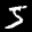

torch.Size([3, 32, 32])


In [5]:
batch_size_train = 256
batch_size_test = 256
batch_size_wm = 64

trainset = datasets.ImageFolder('./data/CIFAR10_7030/with_trigger/train/', transform=transform_train)
testset = datasets.ImageFolder('./data/CIFAR10_7030/test', transform=transform_test)
# valset = datasets.ImageFolder('./data/CIFAR10_7030/with_trigger/val/', transform=transform_test)
watermarkset = datasets.ImageFolder('./data/CIFAR10_7030/with_trigger/trigger_random/', transform=transform_test)
advwatermarkset = datasets.ImageFolder('./data/CIFAR10_7030/with_trigger/trigger_adv/', transform=transform_test)
unrelatedset = watermark_unrelated(count=100)
train_watermark_mixset = torch.utils.data.ConcatDataset((trainset,unrelatedset))

testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size_test, shuffle=False, num_workers=8)

# valloader = torch.utils.data.DataLoader(
# valset, batch_size=batch_size_test, shuffle=False, num_workers=8)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size_train, shuffle=True, num_workers=8, drop_last=False)

wmloader = torch.utils.data.DataLoader(
    watermarkset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)
unrelatedloader = torch.utils.data.DataLoader(
    unrelatedset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)
advwmloader = torch.utils.data.DataLoader(
    advwatermarkset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)
train_watermark_loader = torch.utils.data.DataLoader(
    train_watermark_mixset, batch_size=batch_size_train, shuffle=True, num_workers=8, drop_last=False)

In [19]:
# warm up with clean data
net = ResNet18()

lr, wd, gamma, epochs = 5e-4, 1e-4, 0.5, 10
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
criterion = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20,
                                                        gamma=gamma, verbose=True)

trainer = Trainer(net, criterion, optimizer, trainloader, trigger_loader=None, scheduler=lr_scheduler, use_trigger=False)
evaluator = Evaluator(net, criterion)
logcmt = f"resnet18_cifar10_7030 opt=Adam lr={lr} wd={wd} sched_gamma={gamma} ep={epochs}"
train(trainer, evaluator, testloader, epochs, 'checkpoints/resnet18_7030.ckpt', logdir='./runs', logcmt=logcmt)

Adjusting learning rate of group 0 to 5.0000e-04.
Start Training...


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [01:39<00:00,  1.38it/s]

Adjusting learning rate of group 0 to 5.0000e-04.


Epoch 0 | Time 106s| Train Loss 1.5057 | Train Acc 44.92| Val Loss 1.455 | Val Acc 48.92


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.36it/s]

Adjusting learning rate of group 0 to 5.0000e-04.


Epoch 1 | Time 120s| Train Loss 1.0763 | Train Acc 61.23| Val Loss 1.128 | Val Acc 61.28


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.24it/s]

Adjusting learning rate of group 0 to 5.0000e-04.


Epoch 2 | Time 134s| Train Loss 0.8840 | Train Acc 68.59| Val Loss 1.084 | Val Acc 64.15


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.19it/s]

Adjusting learning rate of group 0 to 5.0000e-04.


Epoch 3 | Time 148s| Train Loss 0.7620 | Train Acc 73.20| Val Loss 0.881 | Val Acc 70.22


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.12it/s]

Adjusting learning rate of group 0 to 5.0000e-04.


Epoch 4 | Time 162s| Train Loss 0.6821 | Train Acc 76.11| Val Loss 0.861 | Val Acc 72.33


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.11it/s]

Adjusting learning rate of group 0 to 5.0000e-04.


Epoch 5 | Time 176s| Train Loss 0.6292 | Train Acc 77.87| Val Loss 0.789 | Val Acc 73.31


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.09it/s]

Adjusting learning rate of group 0 to 5.0000e-04.


Epoch 6 | Time 190s| Train Loss 0.5850 | Train Acc 79.71| Val Loss 0.694 | Val Acc 76.22


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.09it/s]

Adjusting learning rate of group 0 to 5.0000e-04.


Epoch 7 | Time 205s| Train Loss 0.5421 | Train Acc 81.20| Val Loss 0.698 | Val Acc 76.78


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.09it/s]

Adjusting learning rate of group 0 to 5.0000e-04.


Epoch 8 | Time 219s| Train Loss 0.5063 | Train Acc 82.34| Val Loss 0.686 | Val Acc 77.88


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.11it/s]

Adjusting learning rate of group 0 to 5.0000e-04.


Epoch 9 | Time 233s| Train Loss 0.4806 | Train Acc 83.27| Val Loss 0.805 | Val Acc 74.16


{'train_acc': [44.92413398225021,
  61.225307758373894,
  68.58574291440023,
  73.20354995705696,
  76.10936158030347,
  77.87288863441168,
  79.7108502719725,
  81.1995419410249,
  82.34468937875752,
  83.26653306613227],
 'train_loss': [1.50569785084248,
  1.07626416769541,
  0.8840054659593628,
  0.761995979045477,
  0.6821026711384751,
  0.6291547257853142,
  0.5849596289075824,
  0.5420508438797554,
  0.5062765712728481,
  0.4805709550826419],
 'val_acc': [48.92,
  61.28,
  64.14999999999999,
  70.22,
  72.33000000000001,
  73.31,
  76.22,
  76.78,
  77.88000000000001,
  74.16],
 'val_loss': [1.4553463117599488,
  1.1281393892288207,
  1.083596270942688,
  0.8811180844545364,
  0.8609488399505615,
  0.7889512747764588,
  0.6938421802937984,
  0.6977508712768554,
  0.6857292370796204,
  0.805360984134674],
 'trigger_acc': [],
 'trigger_loss': []}

In [20]:
# watermark with frozen layers
net = ResNet18()
logcmt = f"resnet18_7030_trigger_finetune"
net.load_state_dict(torch.load('checkpoints/resnet18_7030.ckpt'))
frozen_layers=[net.conv1, net.bn1, net.layer1, net.layer2, net.layer3, net.layer4]
optimizer = torch.optim.Adam(params=net.parameters(), lr=2e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, verbose=True)
trainer = Trainer(net, criterion, optimizer, train_loader=trainloader, trigger_loader=wmloader, use_trigger=True, scheduler=scheduler)
evaluator = Evaluator(net, criterion)
train(trainer, evaluator, testloader, 80, 'checkpoints/resnet18_wm_frozen_7030.ckpt', frozen_layers=frozen_layers,
      logdir='./runs', logcmt=logcmt, trigger_loader=wmloader)

Adjusting learning rate of group 0 to 2.0000e-04.
Start Training...


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:09<00:00, 13.77it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 0 | Time 11s| Train Loss 1.4024 | Train Acc 70.00| Val Loss 0.662 | Val Acc 79.78| Trigger Loss 3.900 | Trigger Acc 3.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:09<00:00, 13.88it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 1 | Time 25s| Train Loss 1.1392 | Train Acc 70.12| Val Loss 0.685 | Val Acc 79.73| Trigger Loss 3.469 | Trigger Acc 5.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:11<00:00, 12.26it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 2 | Time 38s| Train Loss 0.8366 | Train Acc 75.02| Val Loss 0.663 | Val Acc 78.20| Trigger Loss 0.771 | Trigger Acc 80.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:08<00:00, 16.49it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 3 | Time 49s| Train Loss 0.4806 | Train Acc 84.67| Val Loss 0.591 | Val Acc 80.13| Trigger Loss 0.095 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:06<00:00, 19.63it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 4 | Time 58s| Train Loss 0.3826 | Train Acc 87.28| Val Loss 0.562 | Val Acc 81.35| Trigger Loss 0.034 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:06<00:00, 22.35it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 5 | Time 66s| Train Loss 0.3495 | Train Acc 87.97| Val Loss 0.558 | Val Acc 81.96| Trigger Loss 0.013 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:10<00:00, 13.17it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 6 | Time 79s| Train Loss 0.3386 | Train Acc 88.52| Val Loss 0.544 | Val Acc 82.16| Trigger Loss 0.029 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:10<00:00, 13.29it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 7 | Time 91s| Train Loss 0.3392 | Train Acc 88.46| Val Loss 0.546 | Val Acc 82.14| Trigger Loss 0.038 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:11<00:00, 11.84it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 8 | Time 105s| Train Loss 0.3494 | Train Acc 88.37| Val Loss 0.551 | Val Acc 82.41| Trigger Loss 0.058 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:08<00:00, 15.79it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 9 | Time 116s| Train Loss 0.3350 | Train Acc 88.50| Val Loss 0.531 | Val Acc 82.67| Trigger Loss 0.040 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:07<00:00, 18.87it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 10 | Time 126s| Train Loss 0.3182 | Train Acc 88.98| Val Loss 0.535 | Val Acc 82.35| Trigger Loss 0.014 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:06<00:00, 22.33it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 11 | Time 134s| Train Loss 0.2990 | Train Acc 89.59| Val Loss 0.538 | Val Acc 82.96| Trigger Loss 0.006 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:10<00:00, 13.18it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 12 | Time 147s| Train Loss 0.2852 | Train Acc 90.15| Val Loss 0.533 | Val Acc 83.30| Trigger Loss 0.012 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:10<00:00, 13.29it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 13 | Time 159s| Train Loss 0.2826 | Train Acc 90.20| Val Loss 0.531 | Val Acc 83.20| Trigger Loss 0.011 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:11<00:00, 11.85it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 14 | Time 173s| Train Loss 0.2839 | Train Acc 90.19| Val Loss 0.535 | Val Acc 83.23| Trigger Loss 0.021 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:08<00:00, 15.73it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 15 | Time 184s| Train Loss 0.2806 | Train Acc 90.36| Val Loss 0.545 | Val Acc 82.78| Trigger Loss 0.028 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:07<00:00, 18.86it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 16 | Time 193s| Train Loss 0.2857 | Train Acc 90.11| Val Loss 0.517 | Val Acc 83.45| Trigger Loss 0.010 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:06<00:00, 22.33it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 17 | Time 202s| Train Loss 0.2695 | Train Acc 90.57| Val Loss 0.544 | Val Acc 83.26| Trigger Loss 0.005 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:10<00:00, 13.15it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 18 | Time 215s| Train Loss 0.2611 | Train Acc 90.96| Val Loss 0.543 | Val Acc 83.14| Trigger Loss 0.010 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:10<00:00, 13.28it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 19 | Time 227s| Train Loss 0.2569 | Train Acc 91.16| Val Loss 0.539 | Val Acc 83.19| Trigger Loss 0.008 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:11<00:00, 11.83it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 20 | Time 241s| Train Loss 0.2544 | Train Acc 91.28| Val Loss 0.525 | Val Acc 83.66| Trigger Loss 0.010 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:08<00:00, 15.78it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 21 | Time 252s| Train Loss 0.2457 | Train Acc 91.46| Val Loss 0.518 | Val Acc 83.91| Trigger Loss 0.007 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:07<00:00, 18.80it/s]


Adjusting learning rate of group 0 to 5.0000e-05.
Epoch 22 | Time 261s| Train Loss 0.2423 | Train Acc 91.53| Val Loss 0.519 | Val Acc 83.65| Trigger Loss 0.007 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:06<00:00, 22.41it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 23 | Time 270s| Train Loss 0.2284 | Train Acc 91.95| Val Loss 0.517 | Val Acc 84.20| Trigger Loss 0.004 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:10<00:00, 13.15it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 24 | Time 282s| Train Loss 0.2197 | Train Acc 92.42| Val Loss 0.521 | Val Acc 84.22| Trigger Loss 0.004 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:10<00:00, 13.28it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 25 | Time 295s| Train Loss 0.2134 | Train Acc 92.66| Val Loss 0.519 | Val Acc 84.42| Trigger Loss 0.004 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:11<00:00, 11.88it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 26 | Time 309s| Train Loss 0.2175 | Train Acc 92.60| Val Loss 0.518 | Val Acc 84.33| Trigger Loss 0.005 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:08<00:00, 15.79it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 27 | Time 320s| Train Loss 0.2157 | Train Acc 92.62| Val Loss 0.524 | Val Acc 84.08| Trigger Loss 0.009 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:07<00:00, 18.87it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 28 | Time 329s| Train Loss 0.2191 | Train Acc 92.39| Val Loss 0.523 | Val Acc 84.24| Trigger Loss 0.006 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:06<00:00, 22.32it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 29 | Time 338s| Train Loss 0.2078 | Train Acc 92.78| Val Loss 0.525 | Val Acc 84.26| Trigger Loss 0.004 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:10<00:00, 13.18it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 30 | Time 350s| Train Loss 0.1964 | Train Acc 93.20| Val Loss 0.514 | Val Acc 84.54| Trigger Loss 0.004 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:10<00:00, 13.28it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 31 | Time 363s| Train Loss 0.1947 | Train Acc 93.25| Val Loss 0.514 | Val Acc 84.52| Trigger Loss 0.003 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:11<00:00, 11.83it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 32 | Time 377s| Train Loss 0.1964 | Train Acc 93.30| Val Loss 0.512 | Val Acc 84.46| Trigger Loss 0.004 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:08<00:00, 15.78it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 33 | Time 388s| Train Loss 0.1875 | Train Acc 93.47| Val Loss 0.507 | Val Acc 84.71| Trigger Loss 0.004 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:07<00:00, 18.84it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 34 | Time 397s| Train Loss 0.1874 | Train Acc 93.56| Val Loss 0.518 | Val Acc 84.45| Trigger Loss 0.004 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:06<00:00, 22.30it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 35 | Time 406s| Train Loss 0.1774 | Train Acc 93.94| Val Loss 0.526 | Val Acc 84.35| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:10<00:00, 13.17it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 36 | Time 418s| Train Loss 0.1735 | Train Acc 94.11| Val Loss 0.533 | Val Acc 84.19| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:10<00:00, 13.29it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 37 | Time 431s| Train Loss 0.1722 | Train Acc 94.01| Val Loss 0.532 | Val Acc 84.28| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:11<00:00, 11.83it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 38 | Time 445s| Train Loss 0.1747 | Train Acc 93.84| Val Loss 0.525 | Val Acc 84.33| Trigger Loss 0.003 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:08<00:00, 15.77it/s]


Adjusting learning rate of group 0 to 1.2500e-05.
Epoch 39 | Time 456s| Train Loss 0.1745 | Train Acc 93.91| Val Loss 0.524 | Val Acc 84.34| Trigger Loss 0.003 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:07<00:00, 18.87it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 40 | Time 465s| Train Loss 0.1717 | Train Acc 93.98| Val Loss 0.521 | Val Acc 84.60| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:06<00:00, 22.39it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 41 | Time 474s| Train Loss 0.1641 | Train Acc 94.32| Val Loss 0.530 | Val Acc 84.67| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:10<00:00, 13.16it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 42 | Time 486s| Train Loss 0.1632 | Train Acc 94.43| Val Loss 0.532 | Val Acc 84.63| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:10<00:00, 13.28it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 43 | Time 499s| Train Loss 0.1599 | Train Acc 94.36| Val Loss 0.530 | Val Acc 84.74| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:11<00:00, 11.85it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 44 | Time 513s| Train Loss 0.1599 | Train Acc 94.39| Val Loss 0.528 | Val Acc 84.80| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:08<00:00, 15.75it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 45 | Time 524s| Train Loss 0.1608 | Train Acc 94.48| Val Loss 0.530 | Val Acc 84.73| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:07<00:00, 18.46it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 46 | Time 534s| Train Loss 0.1619 | Train Acc 94.45| Val Loss 0.533 | Val Acc 84.55| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:06<00:00, 22.30it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 47 | Time 542s| Train Loss 0.1586 | Train Acc 94.59| Val Loss 0.527 | Val Acc 84.97| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:10<00:00, 13.15it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 48 | Time 555s| Train Loss 0.1529 | Train Acc 94.76| Val Loss 0.529 | Val Acc 84.86| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:10<00:00, 13.29it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 49 | Time 567s| Train Loss 0.1508 | Train Acc 94.77| Val Loss 0.528 | Val Acc 84.96| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:11<00:00, 11.85it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 50 | Time 581s| Train Loss 0.1513 | Train Acc 94.77| Val Loss 0.529 | Val Acc 84.96| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:08<00:00, 15.80it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 51 | Time 592s| Train Loss 0.1497 | Train Acc 94.74| Val Loss 0.528 | Val Acc 84.80| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:07<00:00, 18.83it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 52 | Time 602s| Train Loss 0.1515 | Train Acc 94.77| Val Loss 0.522 | Val Acc 85.09| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:06<00:00, 22.36it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 53 | Time 610s| Train Loss 0.1487 | Train Acc 94.84| Val Loss 0.527 | Val Acc 85.06| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:10<00:00, 13.18it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 54 | Time 623s| Train Loss 0.1499 | Train Acc 94.85| Val Loss 0.526 | Val Acc 85.11| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:10<00:00, 13.29it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 55 | Time 635s| Train Loss 0.1464 | Train Acc 94.90| Val Loss 0.527 | Val Acc 85.12| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:11<00:00, 11.84it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 56 | Time 649s| Train Loss 0.1480 | Train Acc 94.87| Val Loss 0.529 | Val Acc 84.98| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:08<00:00, 15.77it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 57 | Time 660s| Train Loss 0.1462 | Train Acc 94.89| Val Loss 0.529 | Val Acc 84.93| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:07<00:00, 18.80it/s]


Adjusting learning rate of group 0 to 6.2500e-06.
Epoch 58 | Time 670s| Train Loss 0.1476 | Train Acc 95.02| Val Loss 0.526 | Val Acc 85.03| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:06<00:00, 22.28it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 59 | Time 678s| Train Loss 0.1445 | Train Acc 95.05| Val Loss 0.532 | Val Acc 85.29| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:10<00:00, 13.15it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 60 | Time 691s| Train Loss 0.1436 | Train Acc 95.08| Val Loss 0.532 | Val Acc 85.12| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:10<00:00, 13.29it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 61 | Time 703s| Train Loss 0.1407 | Train Acc 95.30| Val Loss 0.535 | Val Acc 85.06| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:11<00:00, 11.84it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 62 | Time 717s| Train Loss 0.1420 | Train Acc 95.15| Val Loss 0.531 | Val Acc 85.06| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:08<00:00, 15.74it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 63 | Time 728s| Train Loss 0.1442 | Train Acc 95.01| Val Loss 0.532 | Val Acc 85.21| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:07<00:00, 18.82it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 64 | Time 737s| Train Loss 0.1422 | Train Acc 94.96| Val Loss 0.533 | Val Acc 85.09| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:06<00:00, 22.36it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 65 | Time 746s| Train Loss 0.1400 | Train Acc 95.23| Val Loss 0.534 | Val Acc 84.86| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:10<00:00, 13.14it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 66 | Time 759s| Train Loss 0.1408 | Train Acc 95.16| Val Loss 0.535 | Val Acc 85.03| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:10<00:00, 13.28it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 67 | Time 771s| Train Loss 0.1420 | Train Acc 95.12| Val Loss 0.534 | Val Acc 85.00| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:11<00:00, 11.84it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 68 | Time 785s| Train Loss 0.1400 | Train Acc 95.17| Val Loss 0.533 | Val Acc 85.01| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:08<00:00, 15.75it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 69 | Time 796s| Train Loss 0.1383 | Train Acc 95.22| Val Loss 0.533 | Val Acc 85.07| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:07<00:00, 18.87it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 70 | Time 805s| Train Loss 0.1388 | Train Acc 95.31| Val Loss 0.532 | Val Acc 85.06| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:06<00:00, 22.35it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 71 | Time 814s| Train Loss 0.1374 | Train Acc 95.29| Val Loss 0.531 | Val Acc 85.27| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:10<00:00, 13.15it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 72 | Time 826s| Train Loss 0.1359 | Train Acc 95.38| Val Loss 0.537 | Val Acc 84.95| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:10<00:00, 13.27it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 73 | Time 839s| Train Loss 0.1356 | Train Acc 95.39| Val Loss 0.533 | Val Acc 85.05| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:11<00:00, 11.84it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 74 | Time 853s| Train Loss 0.1378 | Train Acc 95.24| Val Loss 0.533 | Val Acc 85.22| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:08<00:00, 15.77it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 75 | Time 864s| Train Loss 0.1363 | Train Acc 95.30| Val Loss 0.532 | Val Acc 85.13| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:07<00:00, 18.83it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 76 | Time 873s| Train Loss 0.1380 | Train Acc 95.23| Val Loss 0.534 | Val Acc 85.06| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:06<00:00, 22.36it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 77 | Time 882s| Train Loss 0.1360 | Train Acc 95.33| Val Loss 0.533 | Val Acc 85.08| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:10<00:00, 13.16it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 78 | Time 894s| Train Loss 0.1360 | Train Acc 95.37| Val Loss 0.533 | Val Acc 84.98| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:10<00:00, 13.29it/s]

Adjusting learning rate of group 0 to 7.8125e-07.


Epoch 79 | Time 907s| Train Loss 0.1374 | Train Acc 95.30| Val Loss 0.534 | Val Acc 85.12| Trigger Loss 0.001 | Trigger Acc 100.00


{'train_acc': [69.99952114159844,
  70.1177202469254,
  75.02035148206674,
  84.66695398170761,
  87.28286356893335,
  87.96956500933149,
  88.52415840635925,
  88.4600660381873,
  88.36852942584878,
  88.49595635737188,
  88.9766795958435,
  89.5894147485285,
  90.14691103986218,
  90.19715748672058,
  90.19237211082931,
  90.3605803763827,
  90.10862803273197,
  90.57280949418576,
  90.95915337834603,
  91.15787961499785,
  91.28104512609465,
  91.4619546999952,
  91.52988467244101,
  91.95339043881897,
  92.42235727616405,
  92.65684069483659,
  92.60403198774122,
  92.61600344778049,
  92.39333429105014,
  92.78360388833022,
  93.20021069769669,
  93.24544192946355,
  93.2980810642676,
  93.46556922046226,
  93.56174879088253,
  93.94244122013122,
  94.10920227783892,
  94.0094813963511,
  93.84427524780922,
  93.91060917835095,
  93.98074989225687,
  94.31834506536417,
  94.42848249772541,
  94.36144232150554,
  94.38777953359192,
  94.47528353352156,
  94.44657127817389,
  94.585

In [21]:
# rowback baseline
net = ResNet18()
logcmt = f"resnet18_7030_trigger_finetune"
net.load_state_dict(torch.load('checkpoints/resnet18_7030.ckpt'))
frozen_layers=[net.conv1, net.bn1, net.layer1, net.layer2, net.layer3, net.layer4]
optimizer = torch.optim.Adam(params=net.parameters(), lr=2e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, verbose=True)
trainer = Trainer(net, criterion, optimizer, train_loader=trainloader, trigger_loader=advwmloader, use_trigger=True, scheduler=scheduler)
evaluator = Evaluator(net, criterion)
train(trainer, evaluator, testloader, 80, 'checkpoints/resnet18_wm_rowback_7030.ckpt', frozen_layers=frozen_layers,
      logdir='./runs', logcmt=logcmt, trigger_loader=advwmloader)

Adjusting learning rate of group 0 to 2.0000e-04.
Start Training...


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:09<00:00, 13.79it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 0 | Time 11s| Train Loss 1.2529 | Train Acc 70.30| Val Loss 0.634 | Val Acc 79.62| Trigger Loss 3.500 | Trigger Acc 5.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:09<00:00, 13.91it/s]


Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 1 | Time 25s| Train Loss 1.0259 | Train Acc 70.51| Val Loss 0.655 | Val Acc 79.50| Trigger Loss 3.039 | Trigger Acc 10.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:11<00:00, 12.28it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 2 | Time 38s| Train Loss 0.7544 | Train Acc 76.66| Val Loss 0.643 | Val Acc 79.01| Trigger Loss 0.775 | Trigger Acc 82.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:08<00:00, 16.49it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 3 | Time 49s| Train Loss 0.4580 | Train Acc 85.46| Val Loss 0.570 | Val Acc 80.80| Trigger Loss 0.143 | Trigger Acc 99.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:06<00:00, 19.64it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 4 | Time 58s| Train Loss 0.3675 | Train Acc 87.54| Val Loss 0.563 | Val Acc 81.24| Trigger Loss 0.029 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:06<00:00, 22.35it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 5 | Time 66s| Train Loss 0.3343 | Train Acc 88.46| Val Loss 0.544 | Val Acc 82.65| Trigger Loss 0.014 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:10<00:00, 13.16it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 6 | Time 79s| Train Loss 0.3184 | Train Acc 89.03| Val Loss 0.538 | Val Acc 82.87| Trigger Loss 0.021 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:10<00:00, 13.30it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 7 | Time 92s| Train Loss 0.3132 | Train Acc 89.20| Val Loss 0.537 | Val Acc 83.18| Trigger Loss 0.022 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:11<00:00, 11.84it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 8 | Time 105s| Train Loss 0.3309 | Train Acc 88.78| Val Loss 0.536 | Val Acc 82.92| Trigger Loss 0.054 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:08<00:00, 15.78it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 9 | Time 116s| Train Loss 0.3250 | Train Acc 88.87| Val Loss 0.550 | Val Acc 82.38| Trigger Loss 0.035 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:07<00:00, 18.83it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 10 | Time 126s| Train Loss 0.3100 | Train Acc 89.36| Val Loss 0.522 | Val Acc 82.80| Trigger Loss 0.014 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:06<00:00, 22.37it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 11 | Time 134s| Train Loss 0.2913 | Train Acc 89.99| Val Loss 0.531 | Val Acc 83.39| Trigger Loss 0.007 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:10<00:00, 13.14it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 12 | Time 147s| Train Loss 0.2894 | Train Acc 90.06| Val Loss 0.542 | Val Acc 83.32| Trigger Loss 0.011 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:10<00:00, 13.29it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 13 | Time 159s| Train Loss 0.2821 | Train Acc 90.30| Val Loss 0.536 | Val Acc 83.26| Trigger Loss 0.012 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:11<00:00, 11.84it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 14 | Time 173s| Train Loss 0.2794 | Train Acc 90.35| Val Loss 0.530 | Val Acc 83.56| Trigger Loss 0.016 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:08<00:00, 15.75it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 15 | Time 184s| Train Loss 0.2723 | Train Acc 90.63| Val Loss 0.526 | Val Acc 83.49| Trigger Loss 0.016 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:07<00:00, 18.84it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 16 | Time 194s| Train Loss 0.2778 | Train Acc 90.38| Val Loss 0.533 | Val Acc 83.69| Trigger Loss 0.014 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:06<00:00, 22.39it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 17 | Time 202s| Train Loss 0.2699 | Train Acc 90.60| Val Loss 0.548 | Val Acc 83.19| Trigger Loss 0.007 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:10<00:00, 13.17it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 18 | Time 215s| Train Loss 0.2649 | Train Acc 90.75| Val Loss 0.530 | Val Acc 83.60| Trigger Loss 0.008 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:10<00:00, 13.25it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 19 | Time 227s| Train Loss 0.2526 | Train Acc 91.19| Val Loss 0.526 | Val Acc 83.98| Trigger Loss 0.008 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:11<00:00, 11.85it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 20 | Time 241s| Train Loss 0.2486 | Train Acc 91.39| Val Loss 0.519 | Val Acc 84.01| Trigger Loss 0.010 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:08<00:00, 15.77it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 21 | Time 252s| Train Loss 0.2425 | Train Acc 91.51| Val Loss 0.507 | Val Acc 84.39| Trigger Loss 0.007 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:07<00:00, 18.80it/s]


Adjusting learning rate of group 0 to 5.0000e-05.
Epoch 22 | Time 262s| Train Loss 0.2354 | Train Acc 91.83| Val Loss 0.514 | Val Acc 83.86| Trigger Loss 0.008 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:06<00:00, 22.35it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 23 | Time 270s| Train Loss 0.2218 | Train Acc 92.23| Val Loss 0.520 | Val Acc 84.32| Trigger Loss 0.004 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:10<00:00, 13.19it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 24 | Time 283s| Train Loss 0.2133 | Train Acc 92.57| Val Loss 0.517 | Val Acc 84.68| Trigger Loss 0.003 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:10<00:00, 13.30it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 25 | Time 295s| Train Loss 0.2121 | Train Acc 92.64| Val Loss 0.516 | Val Acc 84.65| Trigger Loss 0.004 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:11<00:00, 11.82it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 26 | Time 309s| Train Loss 0.2165 | Train Acc 92.40| Val Loss 0.517 | Val Acc 84.62| Trigger Loss 0.004 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:08<00:00, 15.79it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 27 | Time 320s| Train Loss 0.2109 | Train Acc 92.66| Val Loss 0.519 | Val Acc 84.28| Trigger Loss 0.005 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:07<00:00, 18.83it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 28 | Time 329s| Train Loss 0.2161 | Train Acc 92.50| Val Loss 0.521 | Val Acc 84.23| Trigger Loss 0.005 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:06<00:00, 22.37it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 29 | Time 338s| Train Loss 0.2031 | Train Acc 93.03| Val Loss 0.544 | Val Acc 84.24| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:10<00:00, 13.15it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 30 | Time 351s| Train Loss 0.1961 | Train Acc 93.10| Val Loss 0.521 | Val Acc 84.64| Trigger Loss 0.003 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:10<00:00, 13.29it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 31 | Time 363s| Train Loss 0.1894 | Train Acc 93.38| Val Loss 0.522 | Val Acc 84.68| Trigger Loss 0.003 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:11<00:00, 11.83it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 32 | Time 377s| Train Loss 0.1912 | Train Acc 93.40| Val Loss 0.521 | Val Acc 84.84| Trigger Loss 0.003 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:08<00:00, 15.75it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 33 | Time 388s| Train Loss 0.1873 | Train Acc 93.48| Val Loss 0.519 | Val Acc 84.61| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:07<00:00, 18.86it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 34 | Time 397s| Train Loss 0.1844 | Train Acc 93.56| Val Loss 0.527 | Val Acc 84.52| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:06<00:00, 22.39it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 35 | Time 406s| Train Loss 0.1775 | Train Acc 93.94| Val Loss 0.525 | Val Acc 84.47| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:10<00:00, 13.16it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 36 | Time 418s| Train Loss 0.1738 | Train Acc 94.02| Val Loss 0.524 | Val Acc 84.72| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:10<00:00, 13.29it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 37 | Time 431s| Train Loss 0.1717 | Train Acc 94.05| Val Loss 0.522 | Val Acc 84.84| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:11<00:00, 11.85it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 38 | Time 445s| Train Loss 0.1726 | Train Acc 93.95| Val Loss 0.527 | Val Acc 84.76| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:08<00:00, 15.78it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 39 | Time 456s| Train Loss 0.1737 | Train Acc 93.91| Val Loss 0.523 | Val Acc 84.68| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:07<00:00, 18.81it/s]


Adjusting learning rate of group 0 to 1.2500e-05.
Epoch 40 | Time 465s| Train Loss 0.1652 | Train Acc 94.36| Val Loss 0.519 | Val Acc 84.86| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:06<00:00, 22.22it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 41 | Time 474s| Train Loss 0.1607 | Train Acc 94.46| Val Loss 0.526 | Val Acc 85.04| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:10<00:00, 13.15it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 42 | Time 486s| Train Loss 0.1604 | Train Acc 94.45| Val Loss 0.527 | Val Acc 84.92| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:10<00:00, 13.29it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 43 | Time 499s| Train Loss 0.1585 | Train Acc 94.54| Val Loss 0.523 | Val Acc 85.07| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:11<00:00, 11.84it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 44 | Time 513s| Train Loss 0.1562 | Train Acc 94.60| Val Loss 0.520 | Val Acc 85.13| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:08<00:00, 15.78it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 45 | Time 524s| Train Loss 0.1578 | Train Acc 94.51| Val Loss 0.517 | Val Acc 84.99| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:07<00:00, 18.88it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 46 | Time 533s| Train Loss 0.1585 | Train Acc 94.60| Val Loss 0.522 | Val Acc 84.78| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:06<00:00, 22.28it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 47 | Time 541s| Train Loss 0.1553 | Train Acc 94.57| Val Loss 0.526 | Val Acc 84.86| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:10<00:00, 13.17it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 48 | Time 554s| Train Loss 0.1528 | Train Acc 94.72| Val Loss 0.529 | Val Acc 84.84| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:10<00:00, 13.29it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 49 | Time 567s| Train Loss 0.1509 | Train Acc 94.68| Val Loss 0.528 | Val Acc 84.94| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:11<00:00, 11.83it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 50 | Time 580s| Train Loss 0.1504 | Train Acc 94.90| Val Loss 0.526 | Val Acc 84.97| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:08<00:00, 15.75it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 51 | Time 591s| Train Loss 0.1493 | Train Acc 94.75| Val Loss 0.524 | Val Acc 85.06| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:07<00:00, 18.83it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 52 | Time 601s| Train Loss 0.1504 | Train Acc 94.82| Val Loss 0.522 | Val Acc 85.26| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:06<00:00, 22.39it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 53 | Time 609s| Train Loss 0.1469 | Train Acc 94.98| Val Loss 0.522 | Val Acc 85.33| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:10<00:00, 13.17it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 54 | Time 622s| Train Loss 0.1440 | Train Acc 95.09| Val Loss 0.523 | Val Acc 85.14| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:10<00:00, 13.27it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 55 | Time 634s| Train Loss 0.1432 | Train Acc 95.09| Val Loss 0.523 | Val Acc 85.16| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:11<00:00, 11.85it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 56 | Time 648s| Train Loss 0.1441 | Train Acc 95.01| Val Loss 0.524 | Val Acc 85.27| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:08<00:00, 15.77it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 57 | Time 659s| Train Loss 0.1421 | Train Acc 95.09| Val Loss 0.526 | Val Acc 85.36| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:07<00:00, 18.85it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 58 | Time 669s| Train Loss 0.1409 | Train Acc 95.12| Val Loss 0.526 | Val Acc 85.33| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:06<00:00, 22.19it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 59 | Time 677s| Train Loss 0.1420 | Train Acc 95.10| Val Loss 0.531 | Val Acc 85.30| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:10<00:00, 13.16it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 60 | Time 690s| Train Loss 0.1405 | Train Acc 95.05| Val Loss 0.533 | Val Acc 85.32| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:10<00:00, 13.25it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 61 | Time 702s| Train Loss 0.1398 | Train Acc 95.12| Val Loss 0.531 | Val Acc 85.40| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:11<00:00, 11.84it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 62 | Time 716s| Train Loss 0.1397 | Train Acc 95.19| Val Loss 0.529 | Val Acc 85.29| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:08<00:00, 15.76it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 63 | Time 727s| Train Loss 0.1395 | Train Acc 95.15| Val Loss 0.530 | Val Acc 85.27| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:07<00:00, 18.86it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 64 | Time 737s| Train Loss 0.1419 | Train Acc 95.09| Val Loss 0.527 | Val Acc 85.14| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:06<00:00, 22.34it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 65 | Time 745s| Train Loss 0.1390 | Train Acc 95.15| Val Loss 0.529 | Val Acc 85.37| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:10<00:00, 13.15it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 66 | Time 758s| Train Loss 0.1369 | Train Acc 95.33| Val Loss 0.529 | Val Acc 85.34| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:10<00:00, 13.29it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 67 | Time 770s| Train Loss 0.1370 | Train Acc 95.29| Val Loss 0.529 | Val Acc 85.27| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:11<00:00, 11.84it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 68 | Time 784s| Train Loss 0.1374 | Train Acc 95.19| Val Loss 0.527 | Val Acc 85.33| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:08<00:00, 15.76it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 69 | Time 795s| Train Loss 0.1330 | Train Acc 95.43| Val Loss 0.529 | Val Acc 85.40| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:07<00:00, 18.86it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 70 | Time 804s| Train Loss 0.1340 | Train Acc 95.28| Val Loss 0.528 | Val Acc 85.36| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:06<00:00, 22.21it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 71 | Time 813s| Train Loss 0.1358 | Train Acc 95.27| Val Loss 0.529 | Val Acc 85.47| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:10<00:00, 13.17it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 72 | Time 825s| Train Loss 0.1348 | Train Acc 95.30| Val Loss 0.527 | Val Acc 85.38| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:10<00:00, 13.26it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 73 | Time 838s| Train Loss 0.1337 | Train Acc 95.54| Val Loss 0.530 | Val Acc 85.39| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:11<00:00, 11.82it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 74 | Time 852s| Train Loss 0.1366 | Train Acc 95.35| Val Loss 0.525 | Val Acc 85.39| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:08<00:00, 15.76it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 75 | Time 863s| Train Loss 0.1360 | Train Acc 95.28| Val Loss 0.528 | Val Acc 85.39| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:07<00:00, 18.80it/s]


Adjusting learning rate of group 0 to 1.5625e-06.
Epoch 76 | Time 872s| Train Loss 0.1327 | Train Acc 95.37| Val Loss 0.527 | Val Acc 85.36| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:06<00:00, 22.34it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 77 | Time 881s| Train Loss 0.1345 | Train Acc 95.34| Val Loss 0.529 | Val Acc 85.46| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:10<00:00, 13.16it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 78 | Time 893s| Train Loss 0.1350 | Train Acc 95.39| Val Loss 0.527 | Val Acc 85.41| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:10<00:00, 13.31it/s]

Adjusting learning rate of group 0 to 7.8125e-07.


Epoch 79 | Time 906s| Train Loss 0.1315 | Train Acc 95.42| Val Loss 0.528 | Val Acc 85.41| Trigger Loss 0.001 | Trigger Acc 100.00


{'train_acc': [70.29956453079389,
  70.50772838206441,
  76.6580472154384,
  85.45963535435709,
  87.54127386706226,
  88.4600660381873,
  89.03431114514045,
  89.20413733658957,
  88.78034765119955,
  88.86682298894578,
  89.3573240178016,
  89.98899363545007,
  90.05650529138533,
  90.30482844427429,
  90.35028951524143,
  90.63113537327013,
  90.37900177058908,
  90.60152174953343,
  90.74606138964708,
  91.18900541109993,
  91.391108771594,
  91.51462912416798,
  91.83136335359143,
  92.22615686462171,
  92.57309661673925,
  92.63769919127147,
  92.39843039670767,
  92.65670641191399,
  92.50107743140353,
  93.03010001435614,
  93.097095276834,
  93.38182514236493,
  93.40096664593004,
  93.47992534813609,
  93.56174879088253,
  93.93932143369862,
  94.02067282385032,
  94.04779006847676,
  93.94962409615476,
  93.90892113202126,
  94.35564913623965,
  94.45853471790208,
  94.44763683378825,
  94.54467148394507,
  94.60209599464038,
  94.51228271800028,
  94.60209599464038,
  94.57

In [22]:
# normal watermark
net = ResNet18()
logcmt = f"resnet18_7030_trigger_finetune"
net.load_state_dict(torch.load('checkpoints/resnet18_7030.ckpt'))
optimizer = torch.optim.Adam(params=net.parameters(), lr=2e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, verbose=True)
trainer = Trainer(net, criterion, optimizer, train_loader=trainloader, trigger_loader=wmloader, use_trigger=True, scheduler=scheduler)
evaluator = Evaluator(net, criterion)
train(trainer, evaluator, testloader, 80, 'checkpoints/resnet18_wm_7030.ckpt',
      logdir='./runs', logcmt=logcmt, trigger_loader=wmloader)

Adjusting learning rate of group 0 to 2.0000e-04.
Start Training...


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.40it/s]


Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 0 | Time 16s| Train Loss 0.4958 | Train Acc 84.69| Val Loss 0.613 | Val Acc 80.11| Trigger Loss 0.081 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 1 | Time 34s| Train Loss 0.3313 | Train Acc 88.59| Val Loss 0.598 | Val Acc 80.23| Trigger Loss 0.052 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 2 | Time 51s| Train Loss 0.3072 | Train Acc 89.38| Val Loss 0.606 | Val Acc 80.76| Trigger Loss 0.046 | Trigger Acc 99.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.39it/s]


Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 3 | Time 67s| Train Loss 0.2857 | Train Acc 90.21| Val Loss 0.682 | Val Acc 78.64| Trigger Loss 0.090 | Trigger Acc 98.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 4 | Time 84s| Train Loss 0.2757 | Train Acc 90.32| Val Loss 0.569 | Val Acc 82.12| Trigger Loss 0.028 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.37it/s]


Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 5 | Time 101s| Train Loss 0.2550 | Train Acc 91.25| Val Loss 0.567 | Val Acc 82.67| Trigger Loss 0.020 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 6 | Time 118s| Train Loss 0.2495 | Train Acc 91.22| Val Loss 0.576 | Val Acc 82.45| Trigger Loss 0.028 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 7 | Time 135s| Train Loss 0.2349 | Train Acc 91.73| Val Loss 0.620 | Val Acc 82.22| Trigger Loss 0.116 | Trigger Acc 94.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.38it/s]


Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 8 | Time 151s| Train Loss 0.2205 | Train Acc 92.23| Val Loss 0.603 | Val Acc 81.92| Trigger Loss 0.091 | Trigger Acc 97.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 9 | Time 168s| Train Loss 0.2040 | Train Acc 92.83| Val Loss 0.570 | Val Acc 83.30| Trigger Loss 0.011 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 10 | Time 185s| Train Loss 0.1501 | Train Acc 94.86| Val Loss 0.460 | Val Acc 85.86| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 11 | Time 202s| Train Loss 0.1286 | Train Acc 95.74| Val Loss 0.461 | Val Acc 86.10| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.37it/s]


Adjusting learning rate of group 0 to 2.0000e-05.
Epoch 12 | Time 218s| Train Loss 0.1213 | Train Acc 96.02| Val Loss 0.465 | Val Acc 86.18| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 13 | Time 235s| Train Loss 0.1148 | Train Acc 96.20| Val Loss 0.472 | Val Acc 86.24| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.39it/s]


Adjusting learning rate of group 0 to 2.0000e-05.
Epoch 14 | Time 252s| Train Loss 0.1112 | Train Acc 96.21| Val Loss 0.475 | Val Acc 86.19| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 15 | Time 269s| Train Loss 0.1072 | Train Acc 96.39| Val Loss 0.480 | Val Acc 86.05| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 16 | Time 286s| Train Loss 0.1026 | Train Acc 96.53| Val Loss 0.483 | Val Acc 86.00| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.39it/s]


Adjusting learning rate of group 0 to 2.0000e-05.
Epoch 17 | Time 303s| Train Loss 0.0981 | Train Acc 96.75| Val Loss 0.487 | Val Acc 86.25| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.38it/s]


Adjusting learning rate of group 0 to 2.0000e-05.
Epoch 18 | Time 319s| Train Loss 0.0956 | Train Acc 96.82| Val Loss 0.495 | Val Acc 86.00| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 19 | Time 336s| Train Loss 0.0903 | Train Acc 97.05| Val Loss 0.491 | Val Acc 86.26| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.37it/s]


Adjusting learning rate of group 0 to 2.0000e-06.
Epoch 20 | Time 353s| Train Loss 0.0870 | Train Acc 97.19| Val Loss 0.489 | Val Acc 86.15| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 21 | Time 370s| Train Loss 0.0820 | Train Acc 97.39| Val Loss 0.491 | Val Acc 86.10| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.38it/s]


Adjusting learning rate of group 0 to 2.0000e-06.
Epoch 22 | Time 387s| Train Loss 0.0827 | Train Acc 97.33| Val Loss 0.490 | Val Acc 86.19| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.39it/s]


Adjusting learning rate of group 0 to 2.0000e-06.
Epoch 23 | Time 404s| Train Loss 0.0819 | Train Acc 97.32| Val Loss 0.489 | Val Acc 86.13| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.38it/s]


Adjusting learning rate of group 0 to 2.0000e-06.
Epoch 24 | Time 421s| Train Loss 0.0809 | Train Acc 97.34| Val Loss 0.492 | Val Acc 86.09| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.38it/s]


Adjusting learning rate of group 0 to 2.0000e-06.
Epoch 25 | Time 438s| Train Loss 0.0817 | Train Acc 97.43| Val Loss 0.491 | Val Acc 86.21| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.39it/s]


Adjusting learning rate of group 0 to 2.0000e-06.
Epoch 26 | Time 454s| Train Loss 0.0799 | Train Acc 97.48| Val Loss 0.492 | Val Acc 86.03| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 27 | Time 471s| Train Loss 0.0795 | Train Acc 97.48| Val Loss 0.492 | Val Acc 86.10| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 28 | Time 488s| Train Loss 0.0801 | Train Acc 97.36| Val Loss 0.492 | Val Acc 86.11| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 29 | Time 505s| Train Loss 0.0792 | Train Acc 97.50| Val Loss 0.492 | Val Acc 86.09| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 30 | Time 522s| Train Loss 0.0777 | Train Acc 97.50| Val Loss 0.493 | Val Acc 86.21| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.38it/s]


Adjusting learning rate of group 0 to 2.0000e-07.
Epoch 31 | Time 539s| Train Loss 0.0783 | Train Acc 97.57| Val Loss 0.495 | Val Acc 86.15| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.37it/s]


Adjusting learning rate of group 0 to 2.0000e-07.
Epoch 32 | Time 556s| Train Loss 0.0793 | Train Acc 97.52| Val Loss 0.491 | Val Acc 86.11| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.39it/s]


Adjusting learning rate of group 0 to 2.0000e-07.
Epoch 33 | Time 572s| Train Loss 0.0770 | Train Acc 97.58| Val Loss 0.493 | Val Acc 86.10| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 34 | Time 589s| Train Loss 0.0786 | Train Acc 97.45| Val Loss 0.493 | Val Acc 86.13| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.40it/s]


Adjusting learning rate of group 0 to 2.0000e-07.
Epoch 35 | Time 606s| Train Loss 0.0791 | Train Acc 97.53| Val Loss 0.495 | Val Acc 86.14| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.39it/s]


Adjusting learning rate of group 0 to 2.0000e-07.
Epoch 36 | Time 623s| Train Loss 0.0759 | Train Acc 97.58| Val Loss 0.494 | Val Acc 86.10| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 37 | Time 640s| Train Loss 0.0772 | Train Acc 97.42| Val Loss 0.494 | Val Acc 86.13| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.38it/s]


Adjusting learning rate of group 0 to 2.0000e-07.
Epoch 38 | Time 657s| Train Loss 0.0781 | Train Acc 97.56| Val Loss 0.493 | Val Acc 86.14| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 39 | Time 673s| Train Loss 0.0770 | Train Acc 97.56| Val Loss 0.494 | Val Acc 86.19| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.40it/s]


Adjusting learning rate of group 0 to 2.0000e-08.
Epoch 40 | Time 690s| Train Loss 0.0781 | Train Acc 97.50| Val Loss 0.494 | Val Acc 86.13| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.38it/s]


Adjusting learning rate of group 0 to 2.0000e-08.
Epoch 41 | Time 707s| Train Loss 0.0767 | Train Acc 97.59| Val Loss 0.494 | Val Acc 86.15| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.39it/s]


Adjusting learning rate of group 0 to 2.0000e-08.
Epoch 42 | Time 724s| Train Loss 0.0761 | Train Acc 97.56| Val Loss 0.494 | Val Acc 86.08| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 43 | Time 741s| Train Loss 0.0767 | Train Acc 97.44| Val Loss 0.493 | Val Acc 86.15| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.38it/s]


Adjusting learning rate of group 0 to 2.0000e-08.
Epoch 44 | Time 758s| Train Loss 0.0763 | Train Acc 97.61| Val Loss 0.493 | Val Acc 86.10| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 45 | Time 775s| Train Loss 0.0769 | Train Acc 97.52| Val Loss 0.494 | Val Acc 86.24| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.38it/s]


Adjusting learning rate of group 0 to 2.0000e-08.
Epoch 46 | Time 792s| Train Loss 0.0792 | Train Acc 97.42| Val Loss 0.497 | Val Acc 86.18| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 47 | Time 808s| Train Loss 0.0788 | Train Acc 97.44| Val Loss 0.493 | Val Acc 86.09| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.38it/s]


Adjusting learning rate of group 0 to 2.0000e-08.
Epoch 48 | Time 825s| Train Loss 0.0789 | Train Acc 97.46| Val Loss 0.493 | Val Acc 86.24| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.38it/s]


Adjusting learning rate of group 0 to 2.0000e-09.
Epoch 49 | Time 842s| Train Loss 0.0771 | Train Acc 97.55| Val Loss 0.494 | Val Acc 86.12| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.38it/s]


Adjusting learning rate of group 0 to 2.0000e-09.
Epoch 50 | Time 859s| Train Loss 0.0770 | Train Acc 97.60| Val Loss 0.493 | Val Acc 86.11| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.38it/s]


Adjusting learning rate of group 0 to 2.0000e-09.
Epoch 51 | Time 876s| Train Loss 0.0761 | Train Acc 97.56| Val Loss 0.494 | Val Acc 86.12| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.38it/s]


Adjusting learning rate of group 0 to 2.0000e-09.
Epoch 52 | Time 893s| Train Loss 0.0770 | Train Acc 97.47| Val Loss 0.494 | Val Acc 86.01| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.39it/s]


Adjusting learning rate of group 0 to 2.0000e-09.
Epoch 53 | Time 910s| Train Loss 0.0789 | Train Acc 97.42| Val Loss 0.495 | Val Acc 86.17| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 54 | Time 926s| Train Loss 0.0785 | Train Acc 97.47| Val Loss 0.492 | Val Acc 86.16| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 55 | Time 943s| Train Loss 0.0788 | Train Acc 97.54| Val Loss 0.494 | Val Acc 86.01| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.38it/s]


Adjusting learning rate of group 0 to 2.0000e-09.
Epoch 56 | Time 960s| Train Loss 0.0775 | Train Acc 97.49| Val Loss 0.493 | Val Acc 86.15| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 57 | Time 977s| Train Loss 0.0779 | Train Acc 97.49| Val Loss 0.491 | Val Acc 86.12| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.38it/s]


Adjusting learning rate of group 0 to 2.0000e-09.
Epoch 58 | Time 994s| Train Loss 0.0774 | Train Acc 97.55| Val Loss 0.493 | Val Acc 86.18| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 59 | Time 1011s| Train Loss 0.0764 | Train Acc 97.52| Val Loss 0.492 | Val Acc 86.11| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.38it/s]


Adjusting learning rate of group 0 to 2.0000e-10.
Epoch 60 | Time 1028s| Train Loss 0.0770 | Train Acc 97.51| Val Loss 0.493 | Val Acc 86.12| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 61 | Time 1044s| Train Loss 0.0783 | Train Acc 97.52| Val Loss 0.493 | Val Acc 86.11| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 62 | Time 1061s| Train Loss 0.0763 | Train Acc 97.58| Val Loss 0.494 | Val Acc 86.12| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 63 | Time 1078s| Train Loss 0.0762 | Train Acc 97.60| Val Loss 0.493 | Val Acc 86.14| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.37it/s]


Adjusting learning rate of group 0 to 2.0000e-10.
Epoch 64 | Time 1095s| Train Loss 0.0768 | Train Acc 97.58| Val Loss 0.494 | Val Acc 86.15| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 65 | Time 1112s| Train Loss 0.0779 | Train Acc 97.50| Val Loss 0.492 | Val Acc 86.18| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 66 | Time 1129s| Train Loss 0.0772 | Train Acc 97.54| Val Loss 0.493 | Val Acc 86.18| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 67 | Time 1146s| Train Loss 0.0755 | Train Acc 97.65| Val Loss 0.493 | Val Acc 86.18| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.37it/s]


Adjusting learning rate of group 0 to 2.0000e-10.
Epoch 68 | Time 1162s| Train Loss 0.0786 | Train Acc 97.42| Val Loss 0.494 | Val Acc 86.02| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 69 | Time 1179s| Train Loss 0.0765 | Train Acc 97.51| Val Loss 0.494 | Val Acc 86.16| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.39it/s]


Adjusting learning rate of group 0 to 2.0000e-11.
Epoch 70 | Time 1196s| Train Loss 0.0774 | Train Acc 97.56| Val Loss 0.493 | Val Acc 86.16| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 71 | Time 1213s| Train Loss 0.0769 | Train Acc 97.53| Val Loss 0.495 | Val Acc 86.09| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.38it/s]


Adjusting learning rate of group 0 to 2.0000e-11.
Epoch 72 | Time 1230s| Train Loss 0.0768 | Train Acc 97.57| Val Loss 0.494 | Val Acc 86.09| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 73 | Time 1247s| Train Loss 0.0764 | Train Acc 97.57| Val Loss 0.494 | Val Acc 86.09| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.37it/s]


Adjusting learning rate of group 0 to 2.0000e-11.
Epoch 74 | Time 1263s| Train Loss 0.0772 | Train Acc 97.53| Val Loss 0.495 | Val Acc 86.07| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 75 | Time 1280s| Train Loss 0.0769 | Train Acc 97.57| Val Loss 0.495 | Val Acc 86.18| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.39it/s]


Adjusting learning rate of group 0 to 2.0000e-11.
Epoch 76 | Time 1297s| Train Loss 0.0775 | Train Acc 97.56| Val Loss 0.493 | Val Acc 86.10| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 77 | Time 1314s| Train Loss 0.0779 | Train Acc 97.52| Val Loss 0.496 | Val Acc 86.08| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 78 | Time 1331s| Train Loss 0.0782 | Train Acc 97.50| Val Loss 0.495 | Val Acc 86.09| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.39it/s]

Adjusting learning rate of group 0 to 2.0000e-12.


Epoch 79 | Time 1348s| Train Loss 0.0801 | Train Acc 97.42| Val Loss 0.495 | Val Acc 86.14| Trigger Loss 0.000 | Trigger Acc 100.00


{'train_acc': [84.68610831777043,
  88.59359287458697,
  89.376526361155,
  90.21452856390366,
  90.3239699478394,
  91.24886271129627,
  91.2212279274537,
  91.72532682085908,
  92.23291672652397,
  92.82670114447158,
  94.85572091687801,
  95.73576593401332,
  96.01589809893215,
  96.19562616643537,
  96.21223004357611,
  96.39421926592334,
  96.53299516677035,
  96.74855145333525,
  96.82251040819256,
  97.04742307508255,
  97.18910118278025,
  97.38543312742422,
  97.33215294061348,
  97.32258218883094,
  97.3393310044504,
  97.43092467557344,
  97.48049959324305,
  97.48120480773835,
  97.35607982006987,
  97.50035914380118,
  97.49796485179333,
  97.5714217351773,
  97.5211752883189,
  97.5817650720682,
  97.4476847196284,
  97.52669635588757,
  97.57937078006034,
  97.41655892352631,
  97.5554278599818,
  97.56185098339475,
  97.49557055978548,
  97.5905632387424,
  97.5602164439975,
  97.44460927405848,
  97.60570799214672,
  97.52190777187187,
  97.41828970665645,
  97.4350385

In [6]:
net = ResNet18()
optimizer = torch.optim.SGD(net.parameters(), lr=0.05, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

train_certified_wm(
    net,
    train_watermark_loader,
    unrelatedloader,
    testloader,
    optimizer,
    scheduler,
    cert_type='random_7030',
    epochs=100,
    warmup_epochs=10
)

Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:25<00:00,  5.47it/s]
/home/cysren/anaconda3/envs/wm/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 0
Train: Train acc 36.20896374536112 | WM acc 0.0
Tests: WM acc 100.0 | WM train avg acc 13.11 | Test acc 46.129999999999995
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:24<00:00,  5.60it/s]


Epoch 1
Train: Train acc 53.30859263488439 | WM acc 0.0
Tests: WM acc 100.0 | WM train avg acc 10.28 | Test acc 56.68
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:23<00:00,  5.74it/s]


Epoch 2
Train: Train acc 61.83556951184699 | WM acc 0.0
Tests: WM acc 56.00000000000001 | WM train avg acc 10.04 | Test acc 64.0
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:24<00:00,  5.58it/s]


Epoch 3
Train: Train acc 68.16443048815302 | WM acc 0.0
Tests: WM acc 100.0 | WM train avg acc 6.2 | Test acc 59.57
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:24<00:00,  5.59it/s]


Epoch 4
Train: Train acc 72.17242363688268 | WM acc 0.0
Tests: WM acc 73.0 | WM train avg acc 8.14 | Test acc 71.92
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:24<00:00,  5.67it/s]


Epoch 5
Train: Train acc 74.95289751641451 | WM acc 0.0
Tests: WM acc 100.0 | WM train avg acc 7.89 | Test acc 71.13000000000001
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:24<00:00,  5.59it/s]


Epoch 6
Train: Train acc 77.53068798172995 | WM acc 0.0
Tests: WM acc 100.0 | WM train avg acc 12.71 | Test acc 74.36
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:24<00:00,  5.61it/s]


Epoch 7
Train: Train acc 78.81815586640023 | WM acc 0.0
Tests: WM acc 100.0 | WM train avg acc 11.8 | Test acc 76.42
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:24<00:00,  5.62it/s]


Epoch 8
Train: Train acc 80.57664858692549 | WM acc 0.0
Tests: WM acc 100.0 | WM train avg acc 4.02 | Test acc 77.08
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:24<00:00,  5.60it/s]


Epoch 9
Train: Train acc 81.53582643448473 | WM acc 0.0
Tests: WM acc 100.0 | WM train avg acc 9.52 | Test acc 79.51
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:24<00:00,  5.65it/s]


Epoch 10
Train: Train acc 82.63202968883814 | WM acc 0.0
Tests: WM acc 100.0 | WM train avg acc 9.63 | Test acc 77.45
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:24<00:00,  5.61it/s]


Epoch 11
Train: Train acc 35.127033970882096 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 0.0 | Test acc 47.83
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:23<00:00,  5.75it/s]


Epoch 12
Train: Train acc 50.65087068227234 | WM acc 36.0
Tests: WM acc 98.0 | WM train avg acc 53.69 | Test acc 63.49
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:24<00:00,  5.60it/s]


Epoch 13
Train: Train acc 67.58778190122752 | WM acc 36.0
Tests: WM acc 100.0 | WM train avg acc 68.33 | Test acc 66.9
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:24<00:00,  5.61it/s]


Epoch 14
Train: Train acc 73.77105338281473 | WM acc 100.0
Tests: WM acc 52.0 | WM train avg acc 71.95 | Test acc 71.98
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:24<00:00,  5.63it/s]


Epoch 15
Train: Train acc 77.6163288609763 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 82.38 | Test acc 75.19
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:24<00:00,  5.59it/s]


Epoch 16
Train: Train acc 79.82871824150727 | WM acc 86.0
Tests: WM acc 100.0 | WM train avg acc 80.72 | Test acc 76.16000000000001
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:23<00:00,  5.73it/s]


Epoch 17
Train: Train acc 81.13616899800171 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 85.37 | Test acc 78.77
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:24<00:00,  5.60it/s]


Epoch 18
Train: Train acc 82.78332857550672 | WM acc 97.0
Tests: WM acc 100.0 | WM train avg acc 88.6 | Test acc 79.91
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:23<00:00,  5.77it/s]


Epoch 19
Train: Train acc 83.67113902369397 | WM acc 94.0
Tests: WM acc 88.0 | WM train avg acc 76.81 | Test acc 80.67
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:24<00:00,  5.61it/s]


Epoch 20
Train: Train acc 84.75592349414788 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 89.49 | Test acc 80.85
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:24<00:00,  5.61it/s]


Epoch 21
Train: Train acc 85.10705109905795 | WM acc 100.0
Tests: WM acc 96.0 | WM train avg acc 85.65 | Test acc 80.28999999999999
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:24<00:00,  5.61it/s]


Epoch 22
Train: Train acc 85.97487867542107 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 89.91 | Test acc 79.55
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:24<00:00,  5.61it/s]


Epoch 23
Train: Train acc 81.9411932629175 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 81.8 | Test acc 79.03999999999999
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:24<00:00,  5.62it/s]


Epoch 24
Train: Train acc 84.56751355980589 | WM acc 100.0
Tests: WM acc 92.0 | WM train avg acc 81.18 | Test acc 81.43
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:24<00:00,  5.61it/s]


Epoch 25
Train: Train acc 86.8141592920354 | WM acc 97.0
Tests: WM acc 98.0 | WM train avg acc 83.98 | Test acc 81.72
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:24<00:00,  5.67it/s]


Epoch 26
Train: Train acc 87.61347416500142 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 86.55 | Test acc 82.64
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:24<00:00,  5.60it/s]


Epoch 27
Train: Train acc 87.8447045389666 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 89.32 | Test acc 82.37
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:24<00:00,  5.68it/s]


Epoch 28
Train: Train acc 88.54410505281187 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 86.05 | Test acc 82.43
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:24<00:00,  5.62it/s]


Epoch 29
Train: Train acc 89.0893519840137 | WM acc 100.0
Tests: WM acc 98.0 | WM train avg acc 89.9 | Test acc 83.28
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:23<00:00,  5.77it/s]


Epoch 30
Train: Train acc 89.7459320582358 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 87.97 | Test acc 82.39
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:24<00:00,  5.61it/s]


Epoch 31
Train: Train acc 92.91178989437626 | WM acc 99.0
Tests: WM acc 100.0 | WM train avg acc 91.12 | Test acc 86.69
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:24<00:00,  5.59it/s]


Epoch 32
Train: Train acc 94.11932629174993 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 91.7 | Test acc 86.86
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:24<00:00,  5.61it/s]


Epoch 33
Train: Train acc 94.62175278332857 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 87.9 | Test acc 86.76
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:24<00:00,  5.61it/s]


Epoch 34
Train: Train acc 94.77590636597203 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 90.28 | Test acc 86.72
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.31it/s]


Epoch 35
Train: Train acc 95.16699971453039 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 85.99 | Test acc 86.81
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.28it/s]


Epoch 36
Train: Train acc 95.35255495289752 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 94.65 | Test acc 86.58
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.28it/s]


Epoch 37
Train: Train acc 95.49528975164145 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 85.51 | Test acc 86.85000000000001
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.28it/s]


Epoch 38
Train: Train acc 95.64658863831002 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 88.33 | Test acc 86.74
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.30it/s]


Epoch 39
Train: Train acc 95.67228090208393 | WM acc 36.0
Tests: WM acc 100.0 | WM train avg acc 90.5 | Test acc 86.91
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.30it/s]


Epoch 40
Train: Train acc 96.15186982586354 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 94.69 | Test acc 86.66
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.28it/s]


Epoch 41
Train: Train acc 96.20039965743649 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 89.58 | Test acc 86.7
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.28it/s]


Epoch 42
Train: Train acc 96.2517841849843 | WM acc 37.0
Tests: WM acc 100.0 | WM train avg acc 92.46 | Test acc 86.53999999999999
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.29it/s]


Epoch 43
Train: Train acc 96.49728803882387 | WM acc 93.0
Tests: WM acc 100.0 | WM train avg acc 90.56 | Test acc 86.75
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.27it/s]


Epoch 44
Train: Train acc 96.65144162146731 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 86.33 | Test acc 86.72
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.29it/s]


Epoch 45
Train: Train acc 96.6657151013417 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 84.1 | Test acc 86.76
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.28it/s]


Epoch 46
Train: Train acc 96.91978304310591 | WM acc 66.0
Tests: WM acc 100.0 | WM train avg acc 87.3 | Test acc 86.58
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.29it/s]


Epoch 47
Train: Train acc 96.88552669140736 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 89.14 | Test acc 86.57000000000001
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.27it/s]


Epoch 48
Train: Train acc 97.0139880102769 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 91.79 | Test acc 86.74
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.30it/s]


Epoch 49
Train: Train acc 97.25092777619183 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 86.96 | Test acc 86.4
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.28it/s]


Epoch 50
Train: Train acc 97.31658578361404 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 92.0 | Test acc 86.75
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.29it/s]


Epoch 51
Train: Train acc 97.43362831858407 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 86.77 | Test acc 86.6
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.29it/s]


Epoch 52
Train: Train acc 97.63916642877534 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 84.77 | Test acc 86.57000000000001
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.28it/s]


Epoch 53
Train: Train acc 97.67342278047389 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 84.71 | Test acc 86.17
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.29it/s]


Epoch 54
Train: Train acc 97.82186697116757 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 90.37 | Test acc 86.58
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.28it/s]


Epoch 55
Train: Train acc 97.69626034827292 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 83.74 | Test acc 86.29
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.28it/s]


Epoch 56
Train: Train acc 98.0074222095347 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 90.79 | Test acc 86.72
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.29it/s]


Epoch 57
Train: Train acc 98.1244647445047 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 85.5 | Test acc 86.33
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.29it/s]


Epoch 58
Train: Train acc 98.0987724807308 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 85.36 | Test acc 86.59
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.28it/s]


Epoch 59
Train: Train acc 98.12161004852983 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 91.07 | Test acc 86.48
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.30it/s]


Epoch 60
Train: Train acc 98.19583214387669 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 89.58 | Test acc 86.48
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.29it/s]


Epoch 61
Train: Train acc 98.70967741935483 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 95.72 | Test acc 86.85000000000001
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.28it/s]


Epoch 62
Train: Train acc 98.76391664287753 | WM acc 48.0
Tests: WM acc 100.0 | WM train avg acc 88.07 | Test acc 86.98
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.27it/s]


Epoch 63
Train: Train acc 98.82671995432486 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 93.0 | Test acc 86.97
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.29it/s]


Epoch 64
Train: Train acc 98.85812161004853 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 87.42 | Test acc 87.09
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.28it/s]


Epoch 65
Train: Train acc 98.83242934627462 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 90.8 | Test acc 86.98
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.28it/s]


Epoch 66
Train: Train acc 98.96660005709393 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 86.51 | Test acc 87.01
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.28it/s]


Epoch 67
Train: Train acc 98.96660005709393 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 91.18 | Test acc 86.88
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.29it/s]


Epoch 68
Train: Train acc 98.9437624892949 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 94.29 | Test acc 86.89
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.29it/s]


Epoch 69
Train: Train acc 98.98087353696832 | WM acc 71.0
Tests: WM acc 100.0 | WM train avg acc 92.86 | Test acc 86.98
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.29it/s]


Epoch 70
Train: Train acc 98.90950613759635 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 91.43 | Test acc 87.08
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.28it/s]


Epoch 71
Train: Train acc 98.97801884099343 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 92.94 | Test acc 86.95
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.30it/s]


Epoch 72
Train: Train acc 98.9551812731944 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 89.9 | Test acc 86.96000000000001
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.26it/s]


Epoch 73
Train: Train acc 99.01798458464174 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 93.46 | Test acc 86.98
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.28it/s]


Epoch 74
Train: Train acc 99.02940336854125 | WM acc 98.0
Tests: WM acc 100.0 | WM train avg acc 95.85 | Test acc 86.99
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.30it/s]


Epoch 75
Train: Train acc 99.08078789608906 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 89.81 | Test acc 86.91
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.29it/s]


Epoch 76
Train: Train acc 99.00371110476735 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 91.88 | Test acc 86.87
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.29it/s]


Epoch 77
Train: Train acc 99.03796745646589 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 89.58 | Test acc 86.92
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.29it/s]


Epoch 78
Train: Train acc 99.00371110476735 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 90.99 | Test acc 86.94
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.28it/s]


Epoch 79
Train: Train acc 98.98658292891807 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 91.56 | Test acc 86.98
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.29it/s]


Epoch 80
Train: Train acc 99.03796745646589 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 93.67 | Test acc 86.92999999999999
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.30it/s]


Epoch 81
Train: Train acc 99.02654867256638 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 89.05 | Test acc 86.96000000000001
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.29it/s]


Epoch 82
Train: Train acc 99.15500999143592 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 88.25 | Test acc 87.06
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.29it/s]


Epoch 83
Train: Train acc 99.17499286326006 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 95.09 | Test acc 86.94
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.29it/s]


Epoch 84
Train: Train acc 99.08078789608906 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 86.71 | Test acc 87.01
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.29it/s]


Epoch 85
Train: Train acc 99.14644590351128 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 95.37 | Test acc 86.96000000000001
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.28it/s]


Epoch 86
Train: Train acc 99.10933485583784 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 91.0 | Test acc 87.15
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.30it/s]


Epoch 87
Train: Train acc 99.18641164715957 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 88.65 | Test acc 87.01
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.29it/s]


Epoch 88
Train: Train acc 99.14930059948615 | WM acc 99.0
Tests: WM acc 100.0 | WM train avg acc 93.4 | Test acc 86.85000000000001
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.29it/s]


Epoch 89
Train: Train acc 99.18641164715957 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 89.18 | Test acc 87.01
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.29it/s]


Epoch 90
Train: Train acc 99.223522694833 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 95.56 | Test acc 86.91
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.28it/s]


Epoch 91
Train: Train acc 99.16642877533542 | WM acc 65.0
Tests: WM acc 100.0 | WM train avg acc 94.27 | Test acc 86.95
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.31it/s]


Epoch 92
Train: Train acc 99.19212103910934 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 94.01 | Test acc 86.89
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.29it/s]


Epoch 93
Train: Train acc 99.24350556665715 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 91.3 | Test acc 87.02
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.29it/s]


Epoch 94
Train: Train acc 99.16357407936054 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 95.19 | Test acc 86.83
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.29it/s]


Epoch 95
Train: Train acc 99.13788181558664 | WM acc 89.0
Tests: WM acc 100.0 | WM train avg acc 85.0 | Test acc 87.0
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.30it/s]


Epoch 96
Train: Train acc 99.30059948615472 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 95.47 | Test acc 87.01
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.28it/s]


Epoch 97
Train: Train acc 99.13217242363687 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 91.63 | Test acc 86.92
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.29it/s]


Epoch 98
Train: Train acc 99.15500999143592 | WM acc 99.0
Tests: WM acc 100.0 | WM train avg acc 85.35 | Test acc 86.81
./models/wm_cifar10_certify_random_7030.pth


Normal training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:12<00:00, 11.28it/s]


Epoch 99
Train: Train acc 99.20639451898373 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 95.87 | Test acc 87.14
./models/wm_cifar10_certify_random_7030.pth


## 

For Dataset 95:05 Split

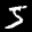

torch.Size([3, 32, 32])


In [24]:
batch_size_train = 256
batch_size_test = 256
batch_size_wm = 64

trainset = datasets.ImageFolder('./data/CIFAR10_6040/with_trigger/train/', transform=transform_train)
testset = datasets.ImageFolder('./data/CIFAR10_6040/test', transform=transform_test)
# valset = datasets.ImageFolder('./data/CIFAR10_6040/with_trigger/val/', transform=transform_test)
watermarkset = datasets.ImageFolder('./data/CIFAR10_6040/with_trigger/trigger_random/', transform=transform_test)
advwatermarkset = datasets.ImageFolder('./data/CIFAR10_6040/with_trigger/trigger_adv/', transform=transform_test)
unrelatedset = watermark_unrelated(count=100)
train_watermark_mixset = torch.utils.data.ConcatDataset((trainset,unrelatedset))

testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size_test, shuffle=False, num_workers=8)

# valloader = torch.utils.data.DataLoader(
# valset, batch_size=batch_size_test, shuffle=False, num_workers=8)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size_train, shuffle=True, num_workers=8, drop_last=False)

wmloader = torch.utils.data.DataLoader(
    watermarkset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)
unrelatedloader = torch.utils.data.DataLoader(
    unrelatedset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)
advwmloader = torch.utils.data.DataLoader(
    advwatermarkset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)
train_watermark_loader = torch.utils.data.DataLoader(
    train_watermark_mixset, batch_size=batch_size_train, shuffle=True, num_workers=8, drop_last=False)

In [25]:
# warm up with clean data
net = ResNet18()

lr, wd, gamma, epochs = 5e-4, 1e-4, 0.5, 10
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
criterion = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20,
                                                        gamma=gamma, verbose=True)

trainer = Trainer(net, criterion, optimizer, trainloader, trigger_loader=None, scheduler=lr_scheduler, use_trigger=False)
evaluator = Evaluator(net, criterion)
logcmt = f"resnet18_cifar10_6040 opt=Adam lr={lr} wd={wd} sched_gamma={gamma} ep={epochs}"
train(trainer, evaluator, testloader, epochs, 'checkpoints/resnet18_6040.ckpt', logdir='./runs', logcmt=logcmt)

Adjusting learning rate of group 0 to 5.0000e-04.
Start Training...


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [01:19<00:00,  1.47it/s]

Adjusting learning rate of group 0 to 5.0000e-04.


Epoch 0 | Time 84s| Train Loss 1.5873 | Train Acc 41.65| Val Loss 1.277 | Val Acc 52.91


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:10<00:00, 11.32it/s]


Adjusting learning rate of group 0 to 5.0000e-04.
Epoch 1 | Time 96s| Train Loss 1.1696 | Train Acc 57.69| Val Loss 1.185 | Val Acc 58.82


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:10<00:00, 11.23it/s]


Adjusting learning rate of group 0 to 5.0000e-04.
Epoch 2 | Time 108s| Train Loss 0.9813 | Train Acc 65.10| Val Loss 1.268 | Val Acc 58.92


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:10<00:00, 11.11it/s]


Adjusting learning rate of group 0 to 5.0000e-04.
Epoch 3 | Time 121s| Train Loss 0.8377 | Train Acc 70.20| Val Loss 0.876 | Val Acc 69.84


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:10<00:00, 11.09it/s]


Adjusting learning rate of group 0 to 5.0000e-04.
Epoch 4 | Time 133s| Train Loss 0.7438 | Train Acc 73.57| Val Loss 0.878 | Val Acc 69.63


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:10<00:00, 11.11it/s]


Adjusting learning rate of group 0 to 5.0000e-04.
Epoch 5 | Time 145s| Train Loss 0.6709 | Train Acc 76.54| Val Loss 0.992 | Val Acc 67.54


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:10<00:00, 11.08it/s]


Adjusting learning rate of group 0 to 5.0000e-04.
Epoch 6 | Time 157s| Train Loss 0.6222 | Train Acc 78.44| Val Loss 0.841 | Val Acc 73.14


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:10<00:00, 11.05it/s]


Adjusting learning rate of group 0 to 5.0000e-04.
Epoch 7 | Time 169s| Train Loss 0.5879 | Train Acc 79.55| Val Loss 0.763 | Val Acc 74.82


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:10<00:00, 11.07it/s]


Adjusting learning rate of group 0 to 5.0000e-04.
Epoch 8 | Time 182s| Train Loss 0.5478 | Train Acc 80.99| Val Loss 0.625 | Val Acc 78.66


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:10<00:00, 11.06it/s]


Adjusting learning rate of group 0 to 5.0000e-04.
Epoch 9 | Time 194s| Train Loss 0.5187 | Train Acc 82.02| Val Loss 0.803 | Val Acc 73.99


{'train_acc': [41.64662658650634,
  57.692050768203075,
  65.1002004008016,
  70.20040080160321,
  73.57381429525718,
  76.54308617234469,
  78.4435537742151,
  79.55243820975284,
  80.98864395457582,
  82.02404809619239],
 'train_loss': [1.5873365880810744,
  1.169594064058267,
  0.9813153510581037,
  0.8377457108430728,
  0.7437598349654683,
  0.6709080297547176,
  0.6221653513296812,
  0.587882366599285,
  0.5478106123093534,
  0.5187472681323926],
 'val_acc': [52.910000000000004,
  58.81999999999999,
  58.919999999999995,
  69.84,
  69.63000000000001,
  67.54,
  73.14,
  74.82,
  78.66,
  73.99],
 'val_loss': [1.2772723052978516,
  1.1849178830385207,
  1.2683191102981568,
  0.8759387164115906,
  0.8781294258356095,
  0.9916027745246887,
  0.8409096830368042,
  0.7629512983560562,
  0.6252857328891754,
  0.8031357885837554],
 'trigger_acc': [],
 'trigger_loss': []}

In [26]:
# watermark with frozen layers
net = ResNet18()
logcmt = f"resnet18_6040_trigger_finetune"
net.load_state_dict(torch.load('checkpoints/resnet18_6040.ckpt'))
frozen_layers=[net.conv1, net.bn1, net.layer1, net.layer2, net.layer3, net.layer4]
optimizer = torch.optim.Adam(params=net.parameters(), lr=2e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, verbose=True)
trainer = Trainer(net, criterion, optimizer, train_loader=trainloader, trigger_loader=wmloader, use_trigger=True, scheduler=scheduler)
evaluator = Evaluator(net, criterion)
train(trainer, evaluator, testloader, 80, 'checkpoints/resnet18_wm_frozen_6040.ckpt', frozen_layers=frozen_layers,
      logdir='./runs', logcmt=logcmt, trigger_loader=wmloader)

Adjusting learning rate of group 0 to 2.0000e-04.
Start Training...


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.72it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 0 | Time 10s| Train Loss 1.4413 | Train Acc 69.38| Val Loss 0.658 | Val Acc 79.63| Trigger Loss 4.132 | Trigger Acc 2.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.84it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 1 | Time 22s| Train Loss 1.1787 | Train Acc 69.21| Val Loss 0.695 | Val Acc 79.43| Trigger Loss 3.551 | Trigger Acc 2.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:09<00:00, 12.25it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 2 | Time 34s| Train Loss 0.8965 | Train Acc 73.11| Val Loss 0.708 | Val Acc 76.69| Trigger Loss 1.003 | Trigger Acc 72.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 16.43it/s]


Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 3 | Time 43s| Train Loss 0.5347 | Train Acc 83.32| Val Loss 0.639 | Val Acc 78.57| Trigger Loss 0.169 | Trigger Acc 98.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:05<00:00, 19.54it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 4 | Time 51s| Train Loss 0.4168 | Train Acc 86.17| Val Loss 0.591 | Val Acc 80.08| Trigger Loss 0.050 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:05<00:00, 22.23it/s]


Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 5 | Time 59s| Train Loss 0.3800 | Train Acc 87.03| Val Loss 0.587 | Val Acc 80.45| Trigger Loss 0.021 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.12it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 6 | Time 70s| Train Loss 0.3650 | Train Acc 87.58| Val Loss 0.579 | Val Acc 80.89| Trigger Loss 0.041 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.25it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 7 | Time 81s| Train Loss 0.3562 | Train Acc 87.86| Val Loss 0.580 | Val Acc 81.12| Trigger Loss 0.050 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:09<00:00, 11.80it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 8 | Time 93s| Train Loss 0.3791 | Train Acc 87.20| Val Loss 0.577 | Val Acc 81.03| Trigger Loss 0.078 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 15.72it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 9 | Time 103s| Train Loss 0.3719 | Train Acc 87.28| Val Loss 0.569 | Val Acc 81.02| Trigger Loss 0.082 | Trigger Acc 99.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:06<00:00, 18.81it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 10 | Time 111s| Train Loss 0.3407 | Train Acc 88.21| Val Loss 0.561 | Val Acc 81.26| Trigger Loss 0.024 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:05<00:00, 22.23it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 11 | Time 118s| Train Loss 0.3237 | Train Acc 88.75| Val Loss 0.573 | Val Acc 81.51| Trigger Loss 0.011 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.13it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 12 | Time 130s| Train Loss 0.3062 | Train Acc 89.47| Val Loss 0.581 | Val Acc 81.52| Trigger Loss 0.010 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.25it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 13 | Time 141s| Train Loss 0.3001 | Train Acc 89.62| Val Loss 0.573 | Val Acc 81.75| Trigger Loss 0.011 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:09<00:00, 11.80it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 14 | Time 153s| Train Loss 0.3073 | Train Acc 89.48| Val Loss 0.559 | Val Acc 82.24| Trigger Loss 0.017 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 15.77it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 15 | Time 163s| Train Loss 0.3008 | Train Acc 89.62| Val Loss 0.563 | Val Acc 81.71| Trigger Loss 0.027 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:06<00:00, 18.82it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 16 | Time 171s| Train Loss 0.3062 | Train Acc 89.36| Val Loss 0.580 | Val Acc 81.57| Trigger Loss 0.025 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:05<00:00, 22.27it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 17 | Time 178s| Train Loss 0.2960 | Train Acc 89.47| Val Loss 0.565 | Val Acc 82.22| Trigger Loss 0.008 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.13it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 18 | Time 190s| Train Loss 0.2784 | Train Acc 90.31| Val Loss 0.567 | Val Acc 82.38| Trigger Loss 0.007 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.25it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 19 | Time 201s| Train Loss 0.2754 | Train Acc 90.50| Val Loss 0.564 | Val Acc 82.29| Trigger Loss 0.008 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:09<00:00, 11.76it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 20 | Time 213s| Train Loss 0.2713 | Train Acc 90.50| Val Loss 0.554 | Val Acc 82.57| Trigger Loss 0.011 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 15.75it/s]


Adjusting learning rate of group 0 to 5.0000e-05.
Epoch 21 | Time 223s| Train Loss 0.2644 | Train Acc 90.73| Val Loss 0.540 | Val Acc 82.98| Trigger Loss 0.007 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:06<00:00, 18.75it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 22 | Time 231s| Train Loss 0.2596 | Train Acc 91.23| Val Loss 0.539 | Val Acc 82.73| Trigger Loss 0.007 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:05<00:00, 22.35it/s]


Adjusting learning rate of group 0 to 5.0000e-05.
Epoch 23 | Time 239s| Train Loss 0.2455 | Train Acc 91.49| Val Loss 0.549 | Val Acc 82.94| Trigger Loss 0.004 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.11it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 24 | Time 250s| Train Loss 0.2374 | Train Acc 91.70| Val Loss 0.543 | Val Acc 83.09| Trigger Loss 0.005 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.26it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 25 | Time 261s| Train Loss 0.2340 | Train Acc 91.93| Val Loss 0.542 | Val Acc 83.14| Trigger Loss 0.005 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:09<00:00, 11.80it/s]


Adjusting learning rate of group 0 to 5.0000e-05.
Epoch 26 | Time 273s| Train Loss 0.2388 | Train Acc 91.63| Val Loss 0.548 | Val Acc 83.01| Trigger Loss 0.006 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 15.76it/s]


Adjusting learning rate of group 0 to 5.0000e-05.
Epoch 27 | Time 283s| Train Loss 0.2355 | Train Acc 91.82| Val Loss 0.535 | Val Acc 83.51| Trigger Loss 0.005 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:06<00:00, 18.77it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 28 | Time 291s| Train Loss 0.2365 | Train Acc 91.70| Val Loss 0.554 | Val Acc 83.03| Trigger Loss 0.005 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:05<00:00, 22.32it/s]


Adjusting learning rate of group 0 to 2.5000e-05.
Epoch 29 | Time 299s| Train Loss 0.2245 | Train Acc 92.36| Val Loss 0.555 | Val Acc 83.65| Trigger Loss 0.003 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.15it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 30 | Time 310s| Train Loss 0.2127 | Train Acc 92.63| Val Loss 0.544 | Val Acc 83.93| Trigger Loss 0.003 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.26it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 31 | Time 321s| Train Loss 0.2084 | Train Acc 92.77| Val Loss 0.545 | Val Acc 84.00| Trigger Loss 0.003 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:09<00:00, 11.81it/s]


Adjusting learning rate of group 0 to 2.5000e-05.
Epoch 32 | Time 333s| Train Loss 0.2087 | Train Acc 92.73| Val Loss 0.544 | Val Acc 84.00| Trigger Loss 0.003 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 15.72it/s]


Adjusting learning rate of group 0 to 2.5000e-05.
Epoch 33 | Time 343s| Train Loss 0.2056 | Train Acc 92.78| Val Loss 0.543 | Val Acc 83.48| Trigger Loss 0.003 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:06<00:00, 18.78it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 34 | Time 351s| Train Loss 0.2052 | Train Acc 92.84| Val Loss 0.535 | Val Acc 83.98| Trigger Loss 0.003 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:05<00:00, 22.35it/s]


Adjusting learning rate of group 0 to 2.5000e-05.
Epoch 35 | Time 359s| Train Loss 0.1976 | Train Acc 93.12| Val Loss 0.548 | Val Acc 83.64| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.12it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 36 | Time 370s| Train Loss 0.1890 | Train Acc 93.34| Val Loss 0.552 | Val Acc 83.46| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.24it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 37 | Time 381s| Train Loss 0.1875 | Train Acc 93.54| Val Loss 0.550 | Val Acc 83.62| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:09<00:00, 11.82it/s]


Adjusting learning rate of group 0 to 2.5000e-05.
Epoch 38 | Time 393s| Train Loss 0.1933 | Train Acc 93.33| Val Loss 0.546 | Val Acc 83.63| Trigger Loss 0.003 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 15.74it/s]


Adjusting learning rate of group 0 to 1.2500e-05.
Epoch 39 | Time 403s| Train Loss 0.1901 | Train Acc 93.26| Val Loss 0.547 | Val Acc 83.50| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:06<00:00, 18.85it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 40 | Time 411s| Train Loss 0.1856 | Train Acc 93.62| Val Loss 0.542 | Val Acc 83.63| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:05<00:00, 22.21it/s]


Adjusting learning rate of group 0 to 1.2500e-05.
Epoch 41 | Time 419s| Train Loss 0.1809 | Train Acc 93.67| Val Loss 0.550 | Val Acc 83.88| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.12it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 42 | Time 430s| Train Loss 0.1737 | Train Acc 94.00| Val Loss 0.553 | Val Acc 83.98| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.24it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 43 | Time 441s| Train Loss 0.1709 | Train Acc 94.19| Val Loss 0.549 | Val Acc 83.94| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:09<00:00, 11.80it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 44 | Time 453s| Train Loss 0.1727 | Train Acc 93.98| Val Loss 0.551 | Val Acc 83.88| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 15.74it/s]


Adjusting learning rate of group 0 to 1.2500e-05.
Epoch 45 | Time 463s| Train Loss 0.1735 | Train Acc 93.97| Val Loss 0.544 | Val Acc 84.04| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:06<00:00, 18.79it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 46 | Time 471s| Train Loss 0.1725 | Train Acc 94.11| Val Loss 0.545 | Val Acc 84.15| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:05<00:00, 22.28it/s]


Adjusting learning rate of group 0 to 1.2500e-05.
Epoch 47 | Time 479s| Train Loss 0.1698 | Train Acc 94.19| Val Loss 0.552 | Val Acc 84.17| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.12it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 48 | Time 490s| Train Loss 0.1688 | Train Acc 94.10| Val Loss 0.550 | Val Acc 84.24| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.23it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 49 | Time 501s| Train Loss 0.1652 | Train Acc 94.25| Val Loss 0.549 | Val Acc 84.06| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:09<00:00, 11.83it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 50 | Time 513s| Train Loss 0.1625 | Train Acc 94.45| Val Loss 0.547 | Val Acc 84.23| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 15.72it/s]


Adjusting learning rate of group 0 to 6.2500e-06.
Epoch 51 | Time 523s| Train Loss 0.1650 | Train Acc 94.32| Val Loss 0.547 | Val Acc 84.16| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:06<00:00, 18.71it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 52 | Time 531s| Train Loss 0.1644 | Train Acc 94.30| Val Loss 0.542 | Val Acc 84.24| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:05<00:00, 22.36it/s]


Adjusting learning rate of group 0 to 6.2500e-06.
Epoch 53 | Time 539s| Train Loss 0.1639 | Train Acc 94.33| Val Loss 0.552 | Val Acc 84.03| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.15it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 54 | Time 550s| Train Loss 0.1560 | Train Acc 94.63| Val Loss 0.549 | Val Acc 84.03| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.27it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 55 | Time 561s| Train Loss 0.1572 | Train Acc 94.59| Val Loss 0.549 | Val Acc 84.06| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:09<00:00, 11.82it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 56 | Time 573s| Train Loss 0.1615 | Train Acc 94.47| Val Loss 0.555 | Val Acc 83.99| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 15.69it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 57 | Time 583s| Train Loss 0.1579 | Train Acc 94.46| Val Loss 0.550 | Val Acc 84.05| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:06<00:00, 18.78it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 58 | Time 591s| Train Loss 0.1597 | Train Acc 94.50| Val Loss 0.548 | Val Acc 84.20| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:05<00:00, 22.25it/s]


Adjusting learning rate of group 0 to 3.1250e-06.
Epoch 59 | Time 599s| Train Loss 0.1561 | Train Acc 94.62| Val Loss 0.555 | Val Acc 84.09| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.13it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 60 | Time 610s| Train Loss 0.1534 | Train Acc 94.71| Val Loss 0.558 | Val Acc 84.08| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.26it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 61 | Time 621s| Train Loss 0.1512 | Train Acc 94.64| Val Loss 0.556 | Val Acc 84.13| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:09<00:00, 11.80it/s]


Adjusting learning rate of group 0 to 3.1250e-06.
Epoch 62 | Time 633s| Train Loss 0.1546 | Train Acc 94.67| Val Loss 0.557 | Val Acc 84.07| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 15.68it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 63 | Time 643s| Train Loss 0.1557 | Train Acc 94.59| Val Loss 0.556 | Val Acc 84.07| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:06<00:00, 18.78it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 64 | Time 651s| Train Loss 0.1541 | Train Acc 94.75| Val Loss 0.556 | Val Acc 84.02| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:05<00:00, 22.34it/s]


Adjusting learning rate of group 0 to 3.1250e-06.
Epoch 65 | Time 659s| Train Loss 0.1520 | Train Acc 94.82| Val Loss 0.558 | Val Acc 84.02| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.14it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 66 | Time 670s| Train Loss 0.1520 | Train Acc 94.83| Val Loss 0.559 | Val Acc 84.18| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.27it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 67 | Time 681s| Train Loss 0.1518 | Train Acc 94.89| Val Loss 0.559 | Val Acc 83.97| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:09<00:00, 11.79it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 68 | Time 693s| Train Loss 0.1512 | Train Acc 94.71| Val Loss 0.558 | Val Acc 83.95| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 15.70it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 69 | Time 703s| Train Loss 0.1491 | Train Acc 94.80| Val Loss 0.556 | Val Acc 84.11| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:06<00:00, 18.80it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 70 | Time 711s| Train Loss 0.1499 | Train Acc 94.84| Val Loss 0.559 | Val Acc 83.85| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:05<00:00, 22.28it/s]


Adjusting learning rate of group 0 to 1.5625e-06.
Epoch 71 | Time 719s| Train Loss 0.1484 | Train Acc 94.96| Val Loss 0.558 | Val Acc 83.92| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.13it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 72 | Time 730s| Train Loss 0.1472 | Train Acc 95.01| Val Loss 0.560 | Val Acc 83.94| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.25it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 73 | Time 741s| Train Loss 0.1523 | Train Acc 94.75| Val Loss 0.559 | Val Acc 83.88| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:09<00:00, 11.81it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 74 | Time 753s| Train Loss 0.1483 | Train Acc 94.84| Val Loss 0.558 | Val Acc 83.97| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 15.75it/s]


Adjusting learning rate of group 0 to 1.5625e-06.
Epoch 75 | Time 763s| Train Loss 0.1482 | Train Acc 94.90| Val Loss 0.556 | Val Acc 83.96| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:06<00:00, 18.82it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 76 | Time 771s| Train Loss 0.1464 | Train Acc 95.00| Val Loss 0.557 | Val Acc 83.96| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:05<00:00, 22.22it/s]


Adjusting learning rate of group 0 to 1.5625e-06.
Epoch 77 | Time 779s| Train Loss 0.1479 | Train Acc 94.90| Val Loss 0.559 | Val Acc 84.03| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.14it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 78 | Time 790s| Train Loss 0.1481 | Train Acc 94.98| Val Loss 0.563 | Val Acc 84.02| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.24it/s]

Adjusting learning rate of group 0 to 7.8125e-07.


Epoch 79 | Time 801s| Train Loss 0.1497 | Train Acc 94.81| Val Loss 0.559 | Val Acc 84.11| Trigger Loss 0.001 | Trigger Acc 100.00


{'train_acc': [69.38450357781754,
  69.2073511339515,
  73.11046511627907,
  83.32122093023256,
  86.16635012847726,
  87.03496815998213,
  87.58105992844365,
  87.85610546307674,
  87.20371198568873,
  87.28354373812982,
  88.20717799642217,
  88.75265333482292,
  89.47324321304883,
  89.61568539827952,
  89.48162216512121,
  89.62432915921288,
  89.35593788403531,
  89.46765724500055,
  90.3091457960644,
  90.49921735241503,
  90.5038543179533,
  90.73121645796064,
  91.23003016422746,
  91.49257066249581,
  91.70204446430567,
  91.93386213830857,
  91.62567084078712,
  91.82412790697676,
  91.70393559928443,
  92.35800536672629,
  92.6319320214669,
  92.77455032957211,
  92.72706960116189,
  92.77734331359625,
  92.83877459749553,
  93.12108676207514,
  93.33594011842253,
  93.53756708407872,
  93.32792933810376,
  93.26052954977098,
  93.62142218246869,
  93.66614490161001,
  93.99597495527729,
  94.1944320214669,
  93.97920393559929,
  93.97274047592448,
  94.11238967713105,
  94.

In [27]:
# rowback baseline
net = ResNet18()
logcmt = f"resnet18_6040_trigger_finetune"
net.load_state_dict(torch.load('checkpoints/resnet18_6040.ckpt'))
frozen_layers=[net.conv1, net.bn1, net.layer1, net.layer2, net.layer3, net.layer4]
optimizer = torch.optim.Adam(params=net.parameters(), lr=2e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, verbose=True)
trainer = Trainer(net, criterion, optimizer, train_loader=trainloader, trigger_loader=advwmloader, use_trigger=True, scheduler=scheduler)
evaluator = Evaluator(net, criterion)
train(trainer, evaluator, testloader, 80, 'checkpoints/resnet18_wm_rowback_6040.ckpt', frozen_layers=frozen_layers,
      logdir='./runs', logcmt=logcmt, trigger_loader=advwmloader)

Adjusting learning rate of group 0 to 2.0000e-04.
Start Training...


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.75it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 0 | Time 10s| Train Loss 1.2808 | Train Acc 69.37| Val Loss 0.643 | Val Acc 78.85| Trigger Loss 3.641 | Trigger Acc 5.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.85it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 1 | Time 22s| Train Loss 1.0683 | Train Acc 69.53| Val Loss 0.665 | Val Acc 78.97| Trigger Loss 3.147 | Trigger Acc 7.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:09<00:00, 12.25it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 2 | Time 33s| Train Loss 0.8054 | Train Acc 75.54| Val Loss 0.631 | Val Acc 78.80| Trigger Loss 0.946 | Trigger Acc 74.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 16.38it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 3 | Time 43s| Train Loss 0.4955 | Train Acc 84.41| Val Loss 0.606 | Val Acc 79.44| Trigger Loss 0.132 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:05<00:00, 19.56it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 4 | Time 51s| Train Loss 0.3961 | Train Acc 86.60| Val Loss 0.595 | Val Acc 80.01| Trigger Loss 0.049 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:05<00:00, 22.28it/s]


Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 5 | Time 59s| Train Loss 0.3599 | Train Acc 87.58| Val Loss 0.577 | Val Acc 80.88| Trigger Loss 0.020 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.10it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 6 | Time 70s| Train Loss 0.3477 | Train Acc 88.09| Val Loss 0.569 | Val Acc 81.63| Trigger Loss 0.028 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.25it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 7 | Time 81s| Train Loss 0.3402 | Train Acc 88.31| Val Loss 0.571 | Val Acc 81.50| Trigger Loss 0.036 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:09<00:00, 11.83it/s]


Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 8 | Time 93s| Train Loss 0.3567 | Train Acc 87.95| Val Loss 0.588 | Val Acc 81.17| Trigger Loss 0.077 | Trigger Acc 99.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 15.73it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 9 | Time 102s| Train Loss 0.3591 | Train Acc 87.71| Val Loss 0.586 | Val Acc 81.35| Trigger Loss 0.049 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:06<00:00, 18.73it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 10 | Time 111s| Train Loss 0.3285 | Train Acc 88.67| Val Loss 0.549 | Val Acc 82.03| Trigger Loss 0.015 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:05<00:00, 22.22it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 11 | Time 119s| Train Loss 0.3156 | Train Acc 88.98| Val Loss 0.599 | Val Acc 80.93| Trigger Loss 0.010 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.11it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 12 | Time 130s| Train Loss 0.3199 | Train Acc 88.83| Val Loss 0.571 | Val Acc 81.47| Trigger Loss 0.016 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.24it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 13 | Time 141s| Train Loss 0.3015 | Train Acc 89.66| Val Loss 0.557 | Val Acc 81.81| Trigger Loss 0.013 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:09<00:00, 11.80it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 14 | Time 153s| Train Loss 0.3031 | Train Acc 89.52| Val Loss 0.547 | Val Acc 82.00| Trigger Loss 0.016 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 15.74it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 15 | Time 163s| Train Loss 0.2964 | Train Acc 89.80| Val Loss 0.593 | Val Acc 81.47| Trigger Loss 0.035 | Trigger Acc 99.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:06<00:00, 18.82it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 16 | Time 171s| Train Loss 0.2995 | Train Acc 89.49| Val Loss 0.581 | Val Acc 81.82| Trigger Loss 0.028 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:05<00:00, 22.18it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 17 | Time 178s| Train Loss 0.2887 | Train Acc 89.85| Val Loss 0.548 | Val Acc 82.56| Trigger Loss 0.005 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.14it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 18 | Time 190s| Train Loss 0.2729 | Train Acc 90.49| Val Loss 0.552 | Val Acc 82.14| Trigger Loss 0.010 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.22it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 19 | Time 201s| Train Loss 0.2732 | Train Acc 90.57| Val Loss 0.552 | Val Acc 82.20| Trigger Loss 0.011 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:09<00:00, 11.81it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 20 | Time 213s| Train Loss 0.2685 | Train Acc 90.72| Val Loss 0.539 | Val Acc 82.61| Trigger Loss 0.011 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 15.75it/s]


Adjusting learning rate of group 0 to 5.0000e-05.
Epoch 21 | Time 223s| Train Loss 0.2641 | Train Acc 90.89| Val Loss 0.533 | Val Acc 82.83| Trigger Loss 0.008 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:06<00:00, 18.77it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 22 | Time 231s| Train Loss 0.2590 | Train Acc 91.01| Val Loss 0.542 | Val Acc 82.69| Trigger Loss 0.007 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:05<00:00, 22.29it/s]


Adjusting learning rate of group 0 to 5.0000e-05.
Epoch 23 | Time 238s| Train Loss 0.2420 | Train Acc 91.53| Val Loss 0.539 | Val Acc 83.63| Trigger Loss 0.004 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.11it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 24 | Time 250s| Train Loss 0.2409 | Train Acc 91.62| Val Loss 0.546 | Val Acc 83.51| Trigger Loss 0.004 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.27it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 25 | Time 261s| Train Loss 0.2366 | Train Acc 91.84| Val Loss 0.542 | Val Acc 83.70| Trigger Loss 0.004 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:09<00:00, 11.81it/s]


Adjusting learning rate of group 0 to 5.0000e-05.
Epoch 26 | Time 273s| Train Loss 0.2340 | Train Acc 91.79| Val Loss 0.541 | Val Acc 83.49| Trigger Loss 0.007 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 15.70it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 27 | Time 283s| Train Loss 0.2341 | Train Acc 91.86| Val Loss 0.535 | Val Acc 83.54| Trigger Loss 0.005 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:06<00:00, 18.82it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 28 | Time 291s| Train Loss 0.2317 | Train Acc 91.80| Val Loss 0.547 | Val Acc 82.96| Trigger Loss 0.008 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:05<00:00, 22.27it/s]


Adjusting learning rate of group 0 to 2.5000e-05.
Epoch 29 | Time 298s| Train Loss 0.2217 | Train Acc 92.24| Val Loss 0.552 | Val Acc 83.00| Trigger Loss 0.003 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.12it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 30 | Time 310s| Train Loss 0.2081 | Train Acc 92.62| Val Loss 0.545 | Val Acc 83.72| Trigger Loss 0.003 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.26it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 31 | Time 321s| Train Loss 0.2092 | Train Acc 92.58| Val Loss 0.542 | Val Acc 83.76| Trigger Loss 0.003 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:09<00:00, 11.81it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 32 | Time 333s| Train Loss 0.2074 | Train Acc 92.74| Val Loss 0.534 | Val Acc 83.93| Trigger Loss 0.003 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 15.72it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 33 | Time 343s| Train Loss 0.2056 | Train Acc 92.74| Val Loss 0.528 | Val Acc 83.96| Trigger Loss 0.003 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:06<00:00, 18.71it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 34 | Time 351s| Train Loss 0.2018 | Train Acc 92.97| Val Loss 0.534 | Val Acc 83.84| Trigger Loss 0.003 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:05<00:00, 22.35it/s]


Adjusting learning rate of group 0 to 2.5000e-05.
Epoch 35 | Time 359s| Train Loss 0.1914 | Train Acc 93.25| Val Loss 0.541 | Val Acc 83.91| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.11it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 36 | Time 370s| Train Loss 0.1869 | Train Acc 93.39| Val Loss 0.541 | Val Acc 83.89| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.27it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 37 | Time 381s| Train Loss 0.1867 | Train Acc 93.58| Val Loss 0.543 | Val Acc 83.94| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:09<00:00, 11.83it/s]


Adjusting learning rate of group 0 to 2.5000e-05.
Epoch 38 | Time 393s| Train Loss 0.1893 | Train Acc 93.45| Val Loss 0.541 | Val Acc 84.04| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 15.73it/s]


Adjusting learning rate of group 0 to 1.2500e-05.
Epoch 39 | Time 403s| Train Loss 0.1888 | Train Acc 93.55| Val Loss 0.545 | Val Acc 84.12| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:06<00:00, 18.81it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 40 | Time 411s| Train Loss 0.1822 | Train Acc 93.79| Val Loss 0.535 | Val Acc 84.32| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:05<00:00, 22.33it/s]


Adjusting learning rate of group 0 to 1.2500e-05.
Epoch 41 | Time 419s| Train Loss 0.1802 | Train Acc 93.80| Val Loss 0.537 | Val Acc 84.48| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.14it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 42 | Time 430s| Train Loss 0.1706 | Train Acc 94.06| Val Loss 0.537 | Val Acc 84.47| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.21it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 43 | Time 441s| Train Loss 0.1679 | Train Acc 94.10| Val Loss 0.536 | Val Acc 84.45| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:09<00:00, 11.80it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 44 | Time 453s| Train Loss 0.1720 | Train Acc 94.07| Val Loss 0.537 | Val Acc 84.33| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 15.73it/s]


Adjusting learning rate of group 0 to 1.2500e-05.
Epoch 45 | Time 463s| Train Loss 0.1706 | Train Acc 94.13| Val Loss 0.536 | Val Acc 84.52| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:06<00:00, 18.75it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 46 | Time 471s| Train Loss 0.1689 | Train Acc 94.25| Val Loss 0.541 | Val Acc 84.36| Trigger Loss 0.002 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:05<00:00, 22.26it/s]


Adjusting learning rate of group 0 to 1.2500e-05.
Epoch 47 | Time 479s| Train Loss 0.1696 | Train Acc 94.12| Val Loss 0.545 | Val Acc 84.14| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.15it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 48 | Time 490s| Train Loss 0.1638 | Train Acc 94.48| Val Loss 0.549 | Val Acc 84.14| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.25it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 49 | Time 501s| Train Loss 0.1644 | Train Acc 94.41| Val Loss 0.548 | Val Acc 84.22| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:09<00:00, 11.82it/s]


Adjusting learning rate of group 0 to 6.2500e-06.
Epoch 50 | Time 513s| Train Loss 0.1622 | Train Acc 94.45| Val Loss 0.545 | Val Acc 84.36| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 15.72it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 51 | Time 523s| Train Loss 0.1647 | Train Acc 94.17| Val Loss 0.546 | Val Acc 84.25| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:06<00:00, 18.80it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 52 | Time 531s| Train Loss 0.1611 | Train Acc 94.39| Val Loss 0.545 | Val Acc 84.35| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:05<00:00, 22.33it/s]


Adjusting learning rate of group 0 to 6.2500e-06.
Epoch 53 | Time 539s| Train Loss 0.1608 | Train Acc 94.45| Val Loss 0.548 | Val Acc 84.41| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.16it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 54 | Time 550s| Train Loss 0.1553 | Train Acc 94.60| Val Loss 0.546 | Val Acc 84.46| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.26it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 55 | Time 561s| Train Loss 0.1511 | Train Acc 94.85| Val Loss 0.546 | Val Acc 84.57| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:09<00:00, 11.81it/s]


Adjusting learning rate of group 0 to 6.2500e-06.
Epoch 56 | Time 573s| Train Loss 0.1585 | Train Acc 94.50| Val Loss 0.542 | Val Acc 84.49| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 15.75it/s]


Adjusting learning rate of group 0 to 6.2500e-06.
Epoch 57 | Time 583s| Train Loss 0.1579 | Train Acc 94.59| Val Loss 0.546 | Val Acc 84.60| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:06<00:00, 18.77it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 58 | Time 591s| Train Loss 0.1535 | Train Acc 94.85| Val Loss 0.550 | Val Acc 84.40| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:05<00:00, 22.30it/s]


Adjusting learning rate of group 0 to 3.1250e-06.
Epoch 59 | Time 599s| Train Loss 0.1528 | Train Acc 94.64| Val Loss 0.549 | Val Acc 84.44| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.14it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 60 | Time 610s| Train Loss 0.1515 | Train Acc 94.79| Val Loss 0.554 | Val Acc 84.30| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.28it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 61 | Time 621s| Train Loss 0.1514 | Train Acc 94.63| Val Loss 0.549 | Val Acc 84.41| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:09<00:00, 11.82it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 62 | Time 633s| Train Loss 0.1487 | Train Acc 94.98| Val Loss 0.551 | Val Acc 84.33| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 15.70it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 63 | Time 643s| Train Loss 0.1507 | Train Acc 94.73| Val Loss 0.551 | Val Acc 84.39| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:06<00:00, 18.78it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 64 | Time 651s| Train Loss 0.1520 | Train Acc 94.78| Val Loss 0.547 | Val Acc 84.41| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:05<00:00, 22.34it/s]


Adjusting learning rate of group 0 to 3.1250e-06.
Epoch 65 | Time 659s| Train Loss 0.1481 | Train Acc 94.90| Val Loss 0.547 | Val Acc 84.46| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.11it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 66 | Time 670s| Train Loss 0.1465 | Train Acc 95.02| Val Loss 0.547 | Val Acc 84.44| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.27it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 67 | Time 681s| Train Loss 0.1479 | Train Acc 95.01| Val Loss 0.549 | Val Acc 84.55| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:09<00:00, 11.81it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 68 | Time 693s| Train Loss 0.1501 | Train Acc 94.91| Val Loss 0.548 | Val Acc 84.58| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 15.73it/s]


Adjusting learning rate of group 0 to 1.5625e-06.
Epoch 69 | Time 703s| Train Loss 0.1468 | Train Acc 94.98| Val Loss 0.549 | Val Acc 84.49| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:06<00:00, 18.81it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 70 | Time 711s| Train Loss 0.1468 | Train Acc 94.88| Val Loss 0.548 | Val Acc 84.53| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:05<00:00, 22.26it/s]


Adjusting learning rate of group 0 to 1.5625e-06.
Epoch 71 | Time 719s| Train Loss 0.1462 | Train Acc 95.03| Val Loss 0.550 | Val Acc 84.52| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.12it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 72 | Time 730s| Train Loss 0.1462 | Train Acc 94.85| Val Loss 0.549 | Val Acc 84.53| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.27it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 73 | Time 741s| Train Loss 0.1467 | Train Acc 94.94| Val Loss 0.549 | Val Acc 84.51| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:09<00:00, 11.82it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 74 | Time 753s| Train Loss 0.1458 | Train Acc 94.94| Val Loss 0.551 | Val Acc 84.49| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:07<00:00, 15.72it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 75 | Time 763s| Train Loss 0.1485 | Train Acc 94.94| Val Loss 0.550 | Val Acc 84.59| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:06<00:00, 18.79it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 76 | Time 772s| Train Loss 0.1453 | Train Acc 94.97| Val Loss 0.547 | Val Acc 84.63| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:05<00:00, 22.29it/s]


Adjusting learning rate of group 0 to 1.5625e-06.
Epoch 77 | Time 779s| Train Loss 0.1466 | Train Acc 94.99| Val Loss 0.549 | Val Acc 84.76| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.12it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 78 | Time 790s| Train Loss 0.1458 | Train Acc 94.98| Val Loss 0.550 | Val Acc 84.65| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:08<00:00, 13.25it/s]

Adjusting learning rate of group 0 to 7.8125e-07.


Epoch 79 | Time 801s| Train Loss 0.1413 | Train Acc 95.16| Val Loss 0.550 | Val Acc 84.65| Trigger Loss 0.001 | Trigger Acc 100.00


{'train_acc': [69.366551223327,
  69.53133728075075,
  75.54226296958855,
  84.4067701932745,
  86.59646966819349,
  87.57680706066361,
  88.08513015305553,
  88.30500894454383,
  87.95002236135957,
  87.71087029382191,
  88.67444978214725,
  88.98167802480171,
  88.83050089445437,
  89.66037314266563,
  89.51793095743493,
  89.80042486583184,
  89.4900011171936,
  89.85308904033069,
  90.49083184257603,
  90.56630143112702,
  90.71612110378729,
  90.89054114490162,
  91.00659144229695,
  91.52887945480953,
  91.62104792760586,
  91.83610769746397,
  91.78862696905374,
  91.85766994633273,
  91.80456171735241,
  92.24388336498716,
  92.62093620824488,
  92.57904144788291,
  92.7382415372584,
  92.73544855323428,
  92.9729427549195,
  93.25494358172271,
  93.39459278292928,
  93.57669946332737,
  93.44812164579606,
  93.54874776386404,
  93.79398949838007,
  93.79957546642834,
  94.06026386404294,
  94.09842475701039,
  94.07328790079322,
  94.12734794275492,
  94.24924589431349,
  94.1

In [28]:
# normal watermark
net = ResNet18()
logcmt = f"resnet18_6040_trigger_finetune"
net.load_state_dict(torch.load('checkpoints/resnet18_6040.ckpt'))
optimizer = torch.optim.Adam(params=net.parameters(), lr=2e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, verbose=True)
trainer = Trainer(net, criterion, optimizer, train_loader=trainloader, trigger_loader=wmloader, use_trigger=True, scheduler=scheduler)
evaluator = Evaluator(net, criterion)
train(trainer, evaluator, testloader, 80, 'checkpoints/resnet18_wm_6040.ckpt',
      logdir='./runs', logcmt=logcmt, trigger_loader=wmloader)

Adjusting learning rate of group 0 to 2.0000e-04.
Start Training...


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 0 | Time 14s| Train Loss 0.5435 | Train Acc 83.15| Val Loss 0.746 | Val Acc 76.05| Trigger Loss 0.200 | Trigger Acc 94.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 1 | Time 30s| Train Loss 0.3576 | Train Acc 87.71| Val Loss 0.595 | Val Acc 80.37| Trigger Loss 0.064 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 2 | Time 44s| Train Loss 0.3340 | Train Acc 88.56| Val Loss 0.560 | Val Acc 81.14| Trigger Loss 0.040 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.34it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 3 | Time 59s| Train Loss 0.3104 | Train Acc 89.29| Val Loss 0.552 | Val Acc 81.84| Trigger Loss 0.022 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 4 | Time 74s| Train Loss 0.2939 | Train Acc 89.73| Val Loss 0.610 | Val Acc 81.51| Trigger Loss 0.042 | Trigger Acc 99.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 5 | Time 89s| Train Loss 0.2826 | Train Acc 90.09| Val Loss 0.558 | Val Acc 82.15| Trigger Loss 0.019 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.35it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 6 | Time 103s| Train Loss 0.2586 | Train Acc 90.98| Val Loss 0.671 | Val Acc 79.86| Trigger Loss 0.027 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 7 | Time 118s| Train Loss 0.2477 | Train Acc 91.45| Val Loss 0.624 | Val Acc 81.31| Trigger Loss 0.037 | Trigger Acc 99.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.35it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 8 | Time 132s| Train Loss 0.2339 | Train Acc 91.74| Val Loss 0.613 | Val Acc 81.90| Trigger Loss 0.024 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 9 | Time 147s| Train Loss 0.2232 | Train Acc 92.18| Val Loss 0.645 | Val Acc 82.05| Trigger Loss 0.051 | Trigger Acc 98.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.34it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 10 | Time 162s| Train Loss 0.1634 | Train Acc 94.32| Val Loss 0.487 | Val Acc 84.81| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 11 | Time 176s| Train Loss 0.1401 | Train Acc 95.40| Val Loss 0.496 | Val Acc 85.05| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 12 | Time 191s| Train Loss 0.1305 | Train Acc 95.71| Val Loss 0.490 | Val Acc 85.29| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 13 | Time 206s| Train Loss 0.1226 | Train Acc 95.99| Val Loss 0.498 | Val Acc 85.14| Trigger Loss 0.001 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 14 | Time 221s| Train Loss 0.1176 | Train Acc 96.16| Val Loss 0.501 | Val Acc 85.15| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 15 | Time 235s| Train Loss 0.1132 | Train Acc 96.34| Val Loss 0.510 | Val Acc 84.94| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 16 | Time 250s| Train Loss 0.1105 | Train Acc 96.25| Val Loss 0.505 | Val Acc 85.31| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 17 | Time 265s| Train Loss 0.1033 | Train Acc 96.62| Val Loss 0.519 | Val Acc 85.17| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.35it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 18 | Time 280s| Train Loss 0.1007 | Train Acc 96.61| Val Loss 0.519 | Val Acc 84.99| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.35it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 19 | Time 294s| Train Loss 0.0958 | Train Acc 96.76| Val Loss 0.519 | Val Acc 85.36| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 20 | Time 309s| Train Loss 0.0904 | Train Acc 97.07| Val Loss 0.518 | Val Acc 85.36| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 21 | Time 324s| Train Loss 0.0874 | Train Acc 97.10| Val Loss 0.518 | Val Acc 85.39| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 22 | Time 339s| Train Loss 0.0872 | Train Acc 97.22| Val Loss 0.516 | Val Acc 85.40| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.34it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 23 | Time 353s| Train Loss 0.0859 | Train Acc 97.26| Val Loss 0.517 | Val Acc 85.33| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 24 | Time 368s| Train Loss 0.0865 | Train Acc 97.27| Val Loss 0.519 | Val Acc 85.21| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 25 | Time 383s| Train Loss 0.0850 | Train Acc 97.28| Val Loss 0.521 | Val Acc 85.31| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 26 | Time 398s| Train Loss 0.0851 | Train Acc 97.23| Val Loss 0.521 | Val Acc 85.32| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 27 | Time 412s| Train Loss 0.0844 | Train Acc 97.24| Val Loss 0.521 | Val Acc 85.27| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 28 | Time 427s| Train Loss 0.0850 | Train Acc 97.23| Val Loss 0.521 | Val Acc 85.42| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 29 | Time 442s| Train Loss 0.0827 | Train Acc 97.30| Val Loss 0.525 | Val Acc 85.34| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.35it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 30 | Time 457s| Train Loss 0.0819 | Train Acc 97.47| Val Loss 0.521 | Val Acc 85.36| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.35it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 31 | Time 471s| Train Loss 0.0808 | Train Acc 97.52| Val Loss 0.522 | Val Acc 85.42| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.35it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 32 | Time 486s| Train Loss 0.0845 | Train Acc 97.28| Val Loss 0.524 | Val Acc 85.43| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 33 | Time 501s| Train Loss 0.0821 | Train Acc 97.33| Val Loss 0.522 | Val Acc 85.38| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 34 | Time 516s| Train Loss 0.0830 | Train Acc 97.36| Val Loss 0.524 | Val Acc 85.37| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 35 | Time 530s| Train Loss 0.0848 | Train Acc 97.27| Val Loss 0.523 | Val Acc 85.38| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 36 | Time 545s| Train Loss 0.0817 | Train Acc 97.36| Val Loss 0.524 | Val Acc 85.37| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 37 | Time 560s| Train Loss 0.0817 | Train Acc 97.39| Val Loss 0.523 | Val Acc 85.37| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 38 | Time 574s| Train Loss 0.0821 | Train Acc 97.44| Val Loss 0.524 | Val Acc 85.29| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 39 | Time 589s| Train Loss 0.0826 | Train Acc 97.27| Val Loss 0.522 | Val Acc 85.45| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 40 | Time 604s| Train Loss 0.0840 | Train Acc 97.25| Val Loss 0.522 | Val Acc 85.39| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.35it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 41 | Time 619s| Train Loss 0.0822 | Train Acc 97.41| Val Loss 0.525 | Val Acc 85.43| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 42 | Time 633s| Train Loss 0.0809 | Train Acc 97.39| Val Loss 0.524 | Val Acc 85.31| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.35it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 43 | Time 648s| Train Loss 0.0819 | Train Acc 97.37| Val Loss 0.525 | Val Acc 85.40| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 44 | Time 663s| Train Loss 0.0815 | Train Acc 97.39| Val Loss 0.524 | Val Acc 85.30| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 45 | Time 678s| Train Loss 0.0817 | Train Acc 97.48| Val Loss 0.523 | Val Acc 85.40| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 46 | Time 692s| Train Loss 0.0831 | Train Acc 97.34| Val Loss 0.524 | Val Acc 85.32| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 47 | Time 707s| Train Loss 0.0824 | Train Acc 97.30| Val Loss 0.525 | Val Acc 85.27| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 48 | Time 722s| Train Loss 0.0829 | Train Acc 97.34| Val Loss 0.525 | Val Acc 85.34| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 49 | Time 737s| Train Loss 0.0807 | Train Acc 97.48| Val Loss 0.524 | Val Acc 85.39| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 50 | Time 751s| Train Loss 0.0838 | Train Acc 97.34| Val Loss 0.523 | Val Acc 85.34| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 51 | Time 766s| Train Loss 0.0808 | Train Acc 97.38| Val Loss 0.526 | Val Acc 85.36| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 52 | Time 781s| Train Loss 0.0806 | Train Acc 97.40| Val Loss 0.523 | Val Acc 85.28| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 53 | Time 796s| Train Loss 0.0805 | Train Acc 97.38| Val Loss 0.523 | Val Acc 85.30| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 54 | Time 810s| Train Loss 0.0810 | Train Acc 97.48| Val Loss 0.524 | Val Acc 85.39| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 55 | Time 825s| Train Loss 0.0793 | Train Acc 97.57| Val Loss 0.525 | Val Acc 85.27| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 56 | Time 840s| Train Loss 0.0822 | Train Acc 97.42| Val Loss 0.525 | Val Acc 85.30| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 57 | Time 855s| Train Loss 0.0828 | Train Acc 97.27| Val Loss 0.524 | Val Acc 85.37| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 58 | Time 869s| Train Loss 0.0812 | Train Acc 97.47| Val Loss 0.524 | Val Acc 85.40| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.35it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 59 | Time 884s| Train Loss 0.0830 | Train Acc 97.32| Val Loss 0.524 | Val Acc 85.32| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 60 | Time 899s| Train Loss 0.0824 | Train Acc 97.36| Val Loss 0.525 | Val Acc 85.36| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 61 | Time 914s| Train Loss 0.0805 | Train Acc 97.46| Val Loss 0.525 | Val Acc 85.25| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 62 | Time 928s| Train Loss 0.0846 | Train Acc 97.34| Val Loss 0.522 | Val Acc 85.41| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 63 | Time 943s| Train Loss 0.0794 | Train Acc 97.52| Val Loss 0.523 | Val Acc 85.35| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.35it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 64 | Time 958s| Train Loss 0.0812 | Train Acc 97.41| Val Loss 0.526 | Val Acc 85.33| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 65 | Time 973s| Train Loss 0.0818 | Train Acc 97.41| Val Loss 0.525 | Val Acc 85.31| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 66 | Time 987s| Train Loss 0.0808 | Train Acc 97.46| Val Loss 0.524 | Val Acc 85.27| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 67 | Time 1002s| Train Loss 0.0804 | Train Acc 97.38| Val Loss 0.525 | Val Acc 85.38| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.34it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 68 | Time 1017s| Train Loss 0.0801 | Train Acc 97.45| Val Loss 0.525 | Val Acc 85.31| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 69 | Time 1032s| Train Loss 0.0832 | Train Acc 97.31| Val Loss 0.525 | Val Acc 85.48| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.38it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 70 | Time 1046s| Train Loss 0.0810 | Train Acc 97.31| Val Loss 0.522 | Val Acc 85.31| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 71 | Time 1061s| Train Loss 0.0820 | Train Acc 97.42| Val Loss 0.525 | Val Acc 85.38| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 72 | Time 1076s| Train Loss 0.0799 | Train Acc 97.46| Val Loss 0.524 | Val Acc 85.35| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 73 | Time 1090s| Train Loss 0.0820 | Train Acc 97.43| Val Loss 0.524 | Val Acc 85.33| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 74 | Time 1105s| Train Loss 0.0831 | Train Acc 97.33| Val Loss 0.523 | Val Acc 85.37| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 75 | Time 1120s| Train Loss 0.0821 | Train Acc 97.32| Val Loss 0.524 | Val Acc 85.32| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 76 | Time 1135s| Train Loss 0.0821 | Train Acc 97.33| Val Loss 0.523 | Val Acc 85.46| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.36it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 77 | Time 1149s| Train Loss 0.0795 | Train Acc 97.50| Val Loss 0.522 | Val Acc 85.41| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 78 | Time 1164s| Train Loss 0.0817 | Train Acc 97.49| Val Loss 0.524 | Val Acc 85.38| Trigger Loss 0.000 | Trigger Acc 100.00


100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:12<00:00,  9.37it/s]

Adjusting learning rate of group 0 to 2.0000e-12.


Epoch 79 | Time 1179s| Train Loss 0.0816 | Train Acc 97.45| Val Loss 0.525 | Val Acc 85.34| Trigger Loss 0.000 | Trigger Acc 100.00


{'train_acc': [83.14792039355993,
  87.71243291592128,
  88.56216457960645,
  89.28611359570662,
  89.73299072729304,
  90.09391771019678,
  90.97866160205564,
  91.4523703041145,
  91.73747763864043,
  92.18190966010734,
  94.3218634789409,
  95.40194543828264,
  95.71220930232558,
  95.99206792537147,
  96.16223166368515,
  96.33839794436376,
  96.24902245559154,
  96.62063953488372,
  96.61211037872863,
  96.75734554798346,
  97.0706618962433,
  97.10420393559929,
  97.22377388001341,
  97.26287565635124,
  97.27404759244777,
  97.27750447227191,
  97.2321528320858,
  97.23557692307693,
  97.2321528320858,
  97.29986583184258,
  97.47037119856887,
  97.51983018657133,
  97.27963356049604,
  97.32781753130591,
  97.35856440071557,
  97.27470930232558,
  97.36415474060823,
  97.3949016100179,
  97.43962432915922,
  97.27404759244777,
  97.25234794275492,
  97.40531784158195,
  97.3949016100179,
  97.3662160652441,
  97.3865161001789,
  97.48434704830053,
  97.34107920902693,
  97.2991

In [29]:
net = ResNet18()
optimizer = torch.optim.SGD(net.parameters(), lr=0.05, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

train_certified_wm(
    net,
    train_watermark_loader,
    unrelatedloader,
    testloader,
    optimizer,
    scheduler,
    cert_type='random_6040',
    epochs=100,
    warmup_epochs=10
)

Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.35it/s]


Epoch 0
Train: Train acc 32.29693741677763 | WM acc 0.0
Tests: WM acc 39.0 | WM train avg acc 7.65 | Test acc 40.88
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.56it/s]


Epoch 1
Train: Train acc 49.0878828229028 | WM acc 0.0
Tests: WM acc 15.0 | WM train avg acc 8.38 | Test acc 50.629999999999995
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.60it/s]


Epoch 2
Train: Train acc 57.46338215712383 | WM acc 0.0
Tests: WM acc 88.0 | WM train avg acc 9.73 | Test acc 59.79
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.56it/s]


Epoch 3
Train: Train acc 64.2410119840213 | WM acc 0.0
Tests: WM acc 38.0 | WM train avg acc 9.25 | Test acc 59.99
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.60it/s]


Epoch 4
Train: Train acc 68.22237017310253 | WM acc 0.0
Tests: WM acc 100.0 | WM train avg acc 12.86 | Test acc 61.06
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.58it/s]


Epoch 5
Train: Train acc 71.04527296937417 | WM acc 0.0
Tests: WM acc 54.0 | WM train avg acc 5.47 | Test acc 68.66
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.58it/s]


Epoch 6
Train: Train acc 74.22103861517975 | WM acc 0.0
Tests: WM acc 90.0 | WM train avg acc 8.97 | Test acc 72.83
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.57it/s]


Epoch 7
Train: Train acc 75.94873501997337 | WM acc 0.0
Tests: WM acc 100.0 | WM train avg acc 10.93 | Test acc 69.94
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.56it/s]


Epoch 8
Train: Train acc 77.9161118508655 | WM acc 0.0
Tests: WM acc 100.0 | WM train avg acc 14.83 | Test acc 70.98
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.56it/s]


Epoch 9
Train: Train acc 78.8948069241012 | WM acc 0.0
Tests: WM acc 100.0 | WM train avg acc 6.95 | Test acc 74.86
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.58it/s]


Epoch 10
Train: Train acc 80.74234354194407 | WM acc 0.0
Tests: WM acc 42.0 | WM train avg acc 5.67 | Test acc 73.3
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.32it/s]


Epoch 11
Train: Train acc 22.72636484687084 | WM acc 100.0
Tests: WM acc 93.0 | WM train avg acc 0.0 | Test acc 28.610000000000003
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.36it/s]


Epoch 12
Train: Train acc 29.84354194407457 | WM acc 74.0
Tests: WM acc 0.0 | WM train avg acc 77.69 | Test acc 35.08
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.33it/s]


Epoch 13
Train: Train acc 45.05992010652463 | WM acc 100.0
Tests: WM acc 34.0 | WM train avg acc 76.81 | Test acc 48.449999999999996
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.35it/s]


Epoch 14
Train: Train acc 57.15712383488681 | WM acc 34.0
Tests: WM acc 99.0 | WM train avg acc 70.81 | Test acc 60.419999999999995
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.36it/s]


Epoch 15
Train: Train acc 65.61251664447404 | WM acc 68.0
Tests: WM acc 100.0 | WM train avg acc 88.02 | Test acc 65.72
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.34it/s]


Epoch 16
Train: Train acc 71.79760319573901 | WM acc 100.0
Tests: WM acc 76.0 | WM train avg acc 80.08 | Test acc 71.19
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.37it/s]


Epoch 17
Train: Train acc 75.07656458055926 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 76.09 | Test acc 74.37
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.33it/s]


Epoch 18
Train: Train acc 77.17709720372837 | WM acc 100.0
Tests: WM acc 99.0 | WM train avg acc 84.21 | Test acc 75.6
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.36it/s]


Epoch 19
Train: Train acc 79.49400798934754 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 82.0 | Test acc 75.47
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.33it/s]


Epoch 20
Train: Train acc 80.06324900133156 | WM acc 95.0
Tests: WM acc 100.0 | WM train avg acc 84.88 | Test acc 76.92999999999999
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.33it/s]


Epoch 21
Train: Train acc 80.96205059920106 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 82.4 | Test acc 77.85
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.35it/s]


Epoch 22
Train: Train acc 82.36684420772303 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 86.27 | Test acc 77.25999999999999
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.35it/s]


Epoch 23
Train: Train acc 83.13914780292943 | WM acc 100.0
Tests: WM acc 95.0 | WM train avg acc 83.5 | Test acc 80.16
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.36it/s]


Epoch 24
Train: Train acc 83.07256990679095 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 84.2 | Test acc 79.41
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.35it/s]


Epoch 25
Train: Train acc 84.72703062583223 | WM acc 37.0
Tests: WM acc 92.0 | WM train avg acc 86.81 | Test acc 78.72
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.33it/s]


Epoch 26
Train: Train acc 84.92010652463382 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 84.66 | Test acc 82.03
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.36it/s]


Epoch 27
Train: Train acc 85.98202396804261 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 86.19 | Test acc 79.64
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.36it/s]


Epoch 28
Train: Train acc 86.53794940079894 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 82.84 | Test acc 80.45
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.35it/s]


Epoch 29
Train: Train acc 87.1404793608522 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 81.65 | Test acc 81.17999999999999
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.33it/s]


Epoch 30
Train: Train acc 86.91411451398136 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 89.97 | Test acc 81.89999999999999
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.36it/s]


Epoch 31
Train: Train acc 91.22503328894807 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 88.5 | Test acc 85.25
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.35it/s]


Epoch 32
Train: Train acc 92.42010652463381 | WM acc 97.0
Tests: WM acc 100.0 | WM train avg acc 92.76 | Test acc 85.19
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.35it/s]


Epoch 33
Train: Train acc 92.60652463382158 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 86.98 | Test acc 85.21
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.33it/s]


Epoch 34
Train: Train acc 93.288948069241 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 89.31 | Test acc 85.58
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.34it/s]


Epoch 35
Train: Train acc 93.23901464713715 | WM acc 98.0
Tests: WM acc 100.0 | WM train avg acc 88.08 | Test acc 85.44
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.34it/s]


Epoch 36
Train: Train acc 93.88814913448735 | WM acc 59.0
Tests: WM acc 100.0 | WM train avg acc 90.45 | Test acc 85.21
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.34it/s]


Epoch 37
Train: Train acc 93.94474034620505 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 90.12 | Test acc 85.56
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.35it/s]


Epoch 38
Train: Train acc 94.13781624500666 | WM acc 63.0
Tests: WM acc 100.0 | WM train avg acc 87.59 | Test acc 85.48
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.33it/s]


Epoch 39
Train: Train acc 94.31424766977364 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 87.59 | Test acc 85.39
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.36it/s]


Epoch 40
Train: Train acc 94.53395472703062 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 92.33 | Test acc 85.17
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.37it/s]


Epoch 41
Train: Train acc 94.93675099866844 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 90.35 | Test acc 85.31
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.36it/s]


Epoch 42
Train: Train acc 94.94340878828228 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 88.43 | Test acc 85.53
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.37it/s]


Epoch 43
Train: Train acc 95.03328894806924 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 87.84 | Test acc 85.21
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.35it/s]


Epoch 44
Train: Train acc 95.29960053262317 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 86.18 | Test acc 85.2
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.38it/s]


Epoch 45
Train: Train acc 95.50932090545939 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 85.82 | Test acc 85.16
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.36it/s]


Epoch 46
Train: Train acc 95.48268974700399 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 81.6 | Test acc 85.07000000000001
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.39it/s]


Epoch 47
Train: Train acc 95.80559254327564 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 89.99 | Test acc 85.25
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.39it/s]


Epoch 48
Train: Train acc 95.96537949400799 | WM acc 90.0
Tests: WM acc 100.0 | WM train avg acc 82.79 | Test acc 85.07000000000001
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.40it/s]


Epoch 49
Train: Train acc 96.16178428761651 | WM acc 70.0
Tests: WM acc 100.0 | WM train avg acc 87.07 | Test acc 85.13
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.37it/s]


Epoch 50
Train: Train acc 96.21837549933421 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 86.33 | Test acc 85.08
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.34it/s]


Epoch 51
Train: Train acc 96.45805592543276 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 90.3 | Test acc 85.19
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.34it/s]


Epoch 52
Train: Train acc 96.36151797603196 | WM acc 64.0
Tests: WM acc 100.0 | WM train avg acc 92.06 | Test acc 85.52
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.37it/s]


Epoch 53
Train: Train acc 96.74101198402131 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 89.95 | Test acc 85.38
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.37it/s]


Epoch 54
Train: Train acc 96.84087882822902 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 87.9 | Test acc 85.28
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.38it/s]


Epoch 55
Train: Train acc 96.9607190412783 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 89.5 | Test acc 85.0
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.37it/s]


Epoch 56
Train: Train acc 96.90412782956058 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 83.37 | Test acc 84.75
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.38it/s]


Epoch 57
Train: Train acc 97.09054593874833 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 88.29 | Test acc 85.35000000000001
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.38it/s]


Epoch 58
Train: Train acc 97.34021304926765 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 91.54 | Test acc 85.33
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.36it/s]


Epoch 59
Train: Train acc 97.43009320905459 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 85.31 | Test acc 85.28999999999999
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.37it/s]


Epoch 60
Train: Train acc 97.45339547270306 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 86.98 | Test acc 84.95
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.36it/s]


Epoch 61
Train: Train acc 97.92609853528629 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 81.33 | Test acc 85.55
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.38it/s]


Epoch 62
Train: Train acc 98.20239680426099 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 89.71 | Test acc 85.54
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.36it/s]


Epoch 63
Train: Train acc 98.22569906790946 | WM acc 73.0
Tests: WM acc 100.0 | WM train avg acc 86.83 | Test acc 85.48
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.36it/s]


Epoch 64
Train: Train acc 98.17243675099867 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 87.25 | Test acc 85.50999999999999
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.39it/s]


Epoch 65
Train: Train acc 98.21238348868175 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 89.06 | Test acc 85.61
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.38it/s]


Epoch 66
Train: Train acc 98.23901464713714 | WM acc 99.0
Tests: WM acc 100.0 | WM train avg acc 90.04 | Test acc 85.59
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.39it/s]


Epoch 67
Train: Train acc 98.36884154460719 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 90.07 | Test acc 85.61999999999999
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.35it/s]


Epoch 68
Train: Train acc 98.48535286284952 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 89.92 | Test acc 85.59
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.39it/s]


Epoch 69
Train: Train acc 98.25233022636485 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 88.34 | Test acc 85.68
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.36it/s]


Epoch 70
Train: Train acc 98.43209054593875 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 88.89 | Test acc 85.64
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.36it/s]


Epoch 71
Train: Train acc 98.39547270306258 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 86.8 | Test acc 85.65
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.37it/s]


Epoch 72
Train: Train acc 98.36884154460719 | WM acc 98.0
Tests: WM acc 100.0 | WM train avg acc 86.89 | Test acc 85.42999999999999
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.35it/s]


Epoch 73
Train: Train acc 98.54527296937417 | WM acc 79.0
Tests: WM acc 100.0 | WM train avg acc 93.71 | Test acc 85.5
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.38it/s]


Epoch 74
Train: Train acc 98.50199733688414 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 88.72 | Test acc 85.59
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.37it/s]


Epoch 75
Train: Train acc 98.48535286284952 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 89.75 | Test acc 85.57000000000001
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.39it/s]


Epoch 76
Train: Train acc 98.53195739014647 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 91.7 | Test acc 85.34
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.38it/s]


Epoch 77
Train: Train acc 98.47203728362184 | WM acc 87.0
Tests: WM acc 100.0 | WM train avg acc 90.18 | Test acc 85.45
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.39it/s]


Epoch 78
Train: Train acc 98.68841544607191 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 91.55 | Test acc 85.49
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.36it/s]


Epoch 79
Train: Train acc 98.64181091877496 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 87.77 | Test acc 85.41
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.37it/s]


Epoch 80
Train: Train acc 98.51864181091877 | WM acc 78.0
Tests: WM acc 100.0 | WM train avg acc 86.31 | Test acc 85.42999999999999
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.39it/s]


Epoch 81
Train: Train acc 98.63515312916113 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 88.13 | Test acc 85.38
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.39it/s]


Epoch 82
Train: Train acc 98.64846870838882 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 86.35 | Test acc 85.31
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.36it/s]


Epoch 83
Train: Train acc 98.60186418109188 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 98.31 | Test acc 85.41
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.38it/s]


Epoch 84
Train: Train acc 98.64181091877496 | WM acc 64.0
Tests: WM acc 100.0 | WM train avg acc 94.27 | Test acc 85.35000000000001
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.37it/s]


Epoch 85
Train: Train acc 98.65179760319573 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 87.9 | Test acc 85.65
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.38it/s]


Epoch 86
Train: Train acc 98.66511318242344 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 95.05 | Test acc 85.41
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.36it/s]


Epoch 87
Train: Train acc 98.66844207723035 | WM acc 77.0
Tests: WM acc 100.0 | WM train avg acc 91.93 | Test acc 85.38
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.35it/s]


Epoch 88
Train: Train acc 98.69174434087883 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 89.39 | Test acc 85.42999999999999
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.37it/s]


Epoch 89
Train: Train acc 98.74833555259653 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 91.43 | Test acc 85.57000000000001
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.38it/s]


Epoch 90
Train: Train acc 98.77496671105193 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 94.43 | Test acc 85.42999999999999
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.36it/s]


Epoch 91
Train: Train acc 98.72503328894807 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 92.88 | Test acc 85.47
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.35it/s]


Epoch 92
Train: Train acc 98.78162450066577 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 96.14 | Test acc 85.22999999999999
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.36it/s]


Epoch 93
Train: Train acc 98.728362183755 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 91.83 | Test acc 85.53
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.37it/s]


Epoch 94
Train: Train acc 98.86484687083889 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 89.45 | Test acc 85.49
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.36it/s]


Epoch 95
Train: Train acc 98.61185086551265 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 83.86 | Test acc 85.57000000000001
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.35it/s]


Epoch 96
Train: Train acc 98.87150466045273 | WM acc 97.0
Tests: WM acc 100.0 | WM train avg acc 85.99 | Test acc 85.34
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.39it/s]


Epoch 97
Train: Train acc 98.80825565912117 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 89.26 | Test acc 85.33
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.36it/s]


Epoch 98
Train: Train acc 98.728362183755 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 86.2 | Test acc 85.28
./models/wm_cifar10_certify_random_6040.pth


Normal training: 100%|████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.38it/s]


Epoch 99
Train: Train acc 98.85486018641811 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 90.34 | Test acc 85.33
./models/wm_cifar10_certify_random_6040.pth


For Dataset 85:15 Split

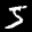

torch.Size([3, 32, 32])


In [30]:
batch_size_train = 256
batch_size_test = 256
batch_size_wm = 64

trainset = datasets.ImageFolder('./data/CIFAR10_5050/with_trigger/train/', transform=transform_train)
testset = datasets.ImageFolder('./data/CIFAR10_5050/test', transform=transform_test)
# valset = datasets.ImageFolder('./data/CIFAR10_5050/with_trigger/val/', transform=transform_test)
watermarkset = datasets.ImageFolder('./data/CIFAR10_5050/with_trigger/trigger_random/', transform=transform_test)
advwatermarkset = datasets.ImageFolder('./data/CIFAR10_5050/with_trigger/trigger_adv/', transform=transform_test)
unrelatedset = watermark_unrelated(count=100)
train_watermark_mixset = torch.utils.data.ConcatDataset((trainset,unrelatedset))

testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size_test, shuffle=False, num_workers=8)

# valloader = torch.utils.data.DataLoader(
# valset, batch_size=batch_size_test, shuffle=False, num_workers=8)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size_train, shuffle=True, num_workers=8, drop_last=False)

wmloader = torch.utils.data.DataLoader(
    watermarkset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)
unrelatedloader = torch.utils.data.DataLoader(
    unrelatedset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)
advwmloader = torch.utils.data.DataLoader(
    advwatermarkset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)
train_watermark_loader = torch.utils.data.DataLoader(
    train_watermark_mixset, batch_size=batch_size_train, shuffle=True, num_workers=8, drop_last=False)

In [31]:
# warm up with clean data
net = ResNet18()

lr, wd, gamma, epochs = 5e-4, 1e-4, 0.5, 10
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
criterion = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20,
                                                        gamma=gamma, verbose=True)

trainer = Trainer(net, criterion, optimizer, trainloader, trigger_loader=None, scheduler=lr_scheduler, use_trigger=False)
evaluator = Evaluator(net, criterion)
logcmt = f"resnet18_cifar10_5050 opt=Adam lr={lr} wd={wd} sched_gamma={gamma} ep={epochs}"
train(trainer, evaluator, testloader, epochs, 'checkpoints/resnet18_5050.ckpt', logdir='./runs', logcmt=logcmt)

Adjusting learning rate of group 0 to 5.0000e-04.
Start Training...


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:57<00:00,  1.71it/s]

Adjusting learning rate of group 0 to 5.0000e-04.


Epoch 0 | Time 62s| Train Loss 1.5866 | Train Acc 41.42| Val Loss 1.344 | Val Acc 50.47


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.43it/s]

Adjusting learning rate of group 0 to 5.0000e-04.


Epoch 1 | Time 72s| Train Loss 1.1971 | Train Acc 56.85| Val Loss 1.355 | Val Acc 55.21


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.33it/s]

Adjusting learning rate of group 0 to 5.0000e-04.


Epoch 2 | Time 82s| Train Loss 0.9957 | Train Acc 64.76| Val Loss 0.986 | Val Acc 65.96


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.27it/s]

Adjusting learning rate of group 0 to 5.0000e-04.


Epoch 3 | Time 93s| Train Loss 0.8639 | Train Acc 69.13| Val Loss 0.862 | Val Acc 70.41


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.20it/s]

Adjusting learning rate of group 0 to 5.0000e-04.


Epoch 4 | Time 103s| Train Loss 0.7622 | Train Acc 73.17| Val Loss 0.872 | Val Acc 69.97


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.19it/s]

Adjusting learning rate of group 0 to 5.0000e-04.


Epoch 5 | Time 113s| Train Loss 0.7013 | Train Acc 75.40| Val Loss 0.918 | Val Acc 70.10


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.18it/s]

Adjusting learning rate of group 0 to 5.0000e-04.


Epoch 6 | Time 124s| Train Loss 0.6545 | Train Acc 77.10| Val Loss 0.706 | Val Acc 75.13


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.11it/s]

Adjusting learning rate of group 0 to 5.0000e-04.


Epoch 7 | Time 134s| Train Loss 0.6072 | Train Acc 78.70| Val Loss 0.944 | Val Acc 69.41


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.16it/s]

Adjusting learning rate of group 0 to 5.0000e-04.


Epoch 8 | Time 145s| Train Loss 0.5744 | Train Acc 79.69| Val Loss 0.747 | Val Acc 75.09


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.11it/s]

Adjusting learning rate of group 0 to 5.0000e-04.


Epoch 9 | Time 155s| Train Loss 0.5460 | Train Acc 80.67| Val Loss 0.947 | Val Acc 71.60


{'train_acc': [41.4188376753507,
  56.84569138276553,
  64.76152304609218,
  69.13026052104209,
  73.16633266533066,
  75.40280561122245,
  77.09819639278557,
  78.70140280561122,
  79.69138276553106,
  80.67334669338678],
 'train_loss': [1.5866036542097408,
  1.1971381818698739,
  0.9956767437787716,
  0.8638532607732172,
  0.7621963812210756,
  0.7013098120402717,
  0.6545272543435107,
  0.6071811193789174,
  0.5743919541171653,
  0.5460414205906625],
 'val_acc': [50.470000000000006,
  55.21,
  65.96,
  70.41,
  69.97,
  70.1,
  75.13,
  69.41000000000001,
  75.09,
  71.6],
 'val_loss': [1.3442271944999695,
  1.35455669965744,
  0.9864886875391007,
  0.8617766108989715,
  0.8723752591133118,
  0.9182836715221405,
  0.706381413269043,
  0.9440269170761109,
  0.7471664171695709,
  0.9469182952165603],
 'trigger_acc': [],
 'trigger_loss': []}

In [32]:
# watermark with frozen layers
net = ResNet18()
logcmt = f"resnet18_5050_trigger_finetune"
net.load_state_dict(torch.load('checkpoints/resnet18_5050.ckpt'))
frozen_layers=[net.conv1, net.bn1, net.layer1, net.layer2, net.layer3, net.layer4]
optimizer = torch.optim.Adam(params=net.parameters(), lr=2e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, verbose=True)
trainer = Trainer(net, criterion, optimizer, train_loader=trainloader, trigger_loader=wmloader, use_trigger=True, scheduler=scheduler)
evaluator = Evaluator(net, criterion)
train(trainer, evaluator, testloader, 80, 'checkpoints/resnet18_wm_frozen_5050.ckpt', frozen_layers=frozen_layers,
      logdir='./runs', logcmt=logcmt, trigger_loader=wmloader)

Adjusting learning rate of group 0 to 2.0000e-04.
Start Training...


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.77it/s]


Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 0 | Time 9s| Train Loss 1.4619 | Train Acc 66.09| Val Loss 0.724 | Val Acc 77.02| Trigger Loss 4.153 | Trigger Acc 0.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.91it/s]


Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 1 | Time 19s| Train Loss 1.2541 | Train Acc 66.08| Val Loss 0.761 | Val Acc 76.76| Trigger Loss 3.603 | Trigger Acc 3.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 12.34it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 2 | Time 29s| Train Loss 1.0157 | Train Acc 69.35| Val Loss 0.779 | Val Acc 74.31| Trigger Loss 1.350 | Trigger Acc 60.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:05<00:00, 16.54it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 3 | Time 37s| Train Loss 0.6450 | Train Acc 79.60| Val Loss 0.733 | Val Acc 74.35| Trigger Loss 0.192 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:04<00:00, 19.74it/s]


Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 4 | Time 44s| Train Loss 0.5052 | Train Acc 83.02| Val Loss 0.666 | Val Acc 77.34| Trigger Loss 0.060 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:04<00:00, 22.51it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 5 | Time 51s| Train Loss 0.4617 | Train Acc 84.26| Val Loss 0.667 | Val Acc 77.41| Trigger Loss 0.025 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.21it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 6 | Time 61s| Train Loss 0.4467 | Train Acc 84.65| Val Loss 0.650 | Val Acc 78.69| Trigger Loss 0.044 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.31it/s]


Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 7 | Time 70s| Train Loss 0.4341 | Train Acc 85.14| Val Loss 0.648 | Val Acc 78.81| Trigger Loss 0.051 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.85it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 8 | Time 81s| Train Loss 0.4569 | Train Acc 84.65| Val Loss 0.638 | Val Acc 78.62| Trigger Loss 0.097 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:06<00:00, 15.81it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 9 | Time 89s| Train Loss 0.4475 | Train Acc 84.66| Val Loss 0.671 | Val Acc 77.90| Trigger Loss 0.060 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:05<00:00, 18.88it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 10 | Time 97s| Train Loss 0.4102 | Train Acc 85.85| Val Loss 0.642 | Val Acc 78.39| Trigger Loss 0.037 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:04<00:00, 22.40it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 11 | Time 103s| Train Loss 0.3927 | Train Acc 86.55| Val Loss 0.621 | Val Acc 79.93| Trigger Loss 0.012 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.18it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 12 | Time 113s| Train Loss 0.3980 | Train Acc 86.49| Val Loss 0.637 | Val Acc 79.30| Trigger Loss 0.025 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.32it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 13 | Time 123s| Train Loss 0.3813 | Train Acc 86.94| Val Loss 0.628 | Val Acc 79.46| Trigger Loss 0.023 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.87it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 14 | Time 133s| Train Loss 0.3824 | Train Acc 86.81| Val Loss 0.610 | Val Acc 80.05| Trigger Loss 0.044 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:06<00:00, 15.85it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 15 | Time 142s| Train Loss 0.3677 | Train Acc 87.34| Val Loss 0.597 | Val Acc 80.35| Trigger Loss 0.028 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:05<00:00, 18.92it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 16 | Time 149s| Train Loss 0.3708 | Train Acc 87.11| Val Loss 0.649 | Val Acc 78.88| Trigger Loss 0.028 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:04<00:00, 22.44it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 17 | Time 156s| Train Loss 0.3561 | Train Acc 87.65| Val Loss 0.624 | Val Acc 80.07| Trigger Loss 0.009 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.22it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 18 | Time 165s| Train Loss 0.3499 | Train Acc 88.04| Val Loss 0.625 | Val Acc 79.84| Trigger Loss 0.019 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.32it/s]


Adjusting learning rate of group 0 to 5.0000e-05.
Epoch 19 | Time 175s| Train Loss 0.3446 | Train Acc 88.23| Val Loss 0.621 | Val Acc 79.93| Trigger Loss 0.018 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.89it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 20 | Time 185s| Train Loss 0.3379 | Train Acc 88.36| Val Loss 0.603 | Val Acc 80.66| Trigger Loss 0.017 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:06<00:00, 15.81it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 21 | Time 194s| Train Loss 0.3312 | Train Acc 88.61| Val Loss 0.604 | Val Acc 80.60| Trigger Loss 0.012 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:05<00:00, 18.89it/s]


Adjusting learning rate of group 0 to 5.0000e-05.
Epoch 22 | Time 201s| Train Loss 0.3194 | Train Acc 88.89| Val Loss 0.604 | Val Acc 80.62| Trigger Loss 0.010 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:04<00:00, 22.44it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 23 | Time 208s| Train Loss 0.3069 | Train Acc 89.31| Val Loss 0.609 | Val Acc 80.64| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.19it/s]


Adjusting learning rate of group 0 to 5.0000e-05.
Epoch 24 | Time 217s| Train Loss 0.3109 | Train Acc 89.14| Val Loss 0.615 | Val Acc 80.69| Trigger Loss 0.007 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.32it/s]


Adjusting learning rate of group 0 to 5.0000e-05.
Epoch 25 | Time 227s| Train Loss 0.3014 | Train Acc 89.48| Val Loss 0.614 | Val Acc 80.81| Trigger Loss 0.007 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.87it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 26 | Time 238s| Train Loss 0.3047 | Train Acc 89.54| Val Loss 0.604 | Val Acc 81.34| Trigger Loss 0.015 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:06<00:00, 15.89it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 27 | Time 246s| Train Loss 0.2988 | Train Acc 89.48| Val Loss 0.603 | Val Acc 81.26| Trigger Loss 0.010 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:05<00:00, 18.92it/s]


Adjusting learning rate of group 0 to 5.0000e-05.
Epoch 28 | Time 254s| Train Loss 0.2917 | Train Acc 89.75| Val Loss 0.597 | Val Acc 81.30| Trigger Loss 0.008 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:04<00:00, 22.48it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 29 | Time 261s| Train Loss 0.2797 | Train Acc 90.15| Val Loss 0.604 | Val Acc 81.31| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.22it/s]


Adjusting learning rate of group 0 to 2.5000e-05.
Epoch 30 | Time 270s| Train Loss 0.2650 | Train Acc 90.91| Val Loss 0.594 | Val Acc 81.56| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.35it/s]


Adjusting learning rate of group 0 to 2.5000e-05.
Epoch 31 | Time 280s| Train Loss 0.2613 | Train Acc 91.02| Val Loss 0.593 | Val Acc 81.55| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.91it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 32 | Time 290s| Train Loss 0.2634 | Train Acc 90.82| Val Loss 0.592 | Val Acc 81.64| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:06<00:00, 15.84it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 33 | Time 299s| Train Loss 0.2600 | Train Acc 91.10| Val Loss 0.591 | Val Acc 81.70| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:05<00:00, 18.98it/s]


Adjusting learning rate of group 0 to 2.5000e-05.
Epoch 34 | Time 306s| Train Loss 0.2558 | Train Acc 91.02| Val Loss 0.595 | Val Acc 81.50| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:04<00:00, 22.47it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 35 | Time 313s| Train Loss 0.2502 | Train Acc 91.28| Val Loss 0.600 | Val Acc 81.58| Trigger Loss 0.003 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.16it/s]


Adjusting learning rate of group 0 to 2.5000e-05.
Epoch 36 | Time 322s| Train Loss 0.2475 | Train Acc 91.29| Val Loss 0.604 | Val Acc 81.75| Trigger Loss 0.003 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.33it/s]


Adjusting learning rate of group 0 to 2.5000e-05.
Epoch 37 | Time 332s| Train Loss 0.2430 | Train Acc 91.53| Val Loss 0.603 | Val Acc 81.66| Trigger Loss 0.003 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.90it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 38 | Time 342s| Train Loss 0.2450 | Train Acc 91.36| Val Loss 0.595 | Val Acc 82.02| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:06<00:00, 15.85it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 39 | Time 351s| Train Loss 0.2465 | Train Acc 91.45| Val Loss 0.590 | Val Acc 82.00| Trigger Loss 0.004 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:05<00:00, 18.90it/s]


Adjusting learning rate of group 0 to 1.2500e-05.
Epoch 40 | Time 358s| Train Loss 0.2359 | Train Acc 91.73| Val Loss 0.587 | Val Acc 82.07| Trigger Loss 0.004 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:04<00:00, 22.52it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 41 | Time 365s| Train Loss 0.2325 | Train Acc 91.84| Val Loss 0.588 | Val Acc 81.96| Trigger Loss 0.003 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.24it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 42 | Time 375s| Train Loss 0.2241 | Train Acc 92.41| Val Loss 0.596 | Val Acc 81.89| Trigger Loss 0.003 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.32it/s]


Adjusting learning rate of group 0 to 1.2500e-05.
Epoch 43 | Time 384s| Train Loss 0.2235 | Train Acc 92.39| Val Loss 0.592 | Val Acc 81.95| Trigger Loss 0.003 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.88it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 44 | Time 395s| Train Loss 0.2229 | Train Acc 92.13| Val Loss 0.592 | Val Acc 82.08| Trigger Loss 0.003 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:06<00:00, 15.82it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 45 | Time 403s| Train Loss 0.2219 | Train Acc 92.24| Val Loss 0.588 | Val Acc 82.28| Trigger Loss 0.003 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:05<00:00, 18.81it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 46 | Time 411s| Train Loss 0.2219 | Train Acc 92.31| Val Loss 0.590 | Val Acc 81.97| Trigger Loss 0.003 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:04<00:00, 22.53it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 47 | Time 417s| Train Loss 0.2190 | Train Acc 92.40| Val Loss 0.595 | Val Acc 81.95| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.16it/s]


Adjusting learning rate of group 0 to 1.2500e-05.
Epoch 48 | Time 427s| Train Loss 0.2085 | Train Acc 92.84| Val Loss 0.593 | Val Acc 82.20| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.34it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 49 | Time 436s| Train Loss 0.2137 | Train Acc 92.72| Val Loss 0.596 | Val Acc 82.04| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.88it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 50 | Time 447s| Train Loss 0.2114 | Train Acc 92.45| Val Loss 0.593 | Val Acc 82.15| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:06<00:00, 15.82it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 51 | Time 455s| Train Loss 0.2088 | Train Acc 92.59| Val Loss 0.589 | Val Acc 82.19| Trigger Loss 0.003 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:05<00:00, 18.96it/s]


Adjusting learning rate of group 0 to 6.2500e-06.
Epoch 52 | Time 463s| Train Loss 0.2076 | Train Acc 92.84| Val Loss 0.591 | Val Acc 82.44| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:04<00:00, 22.46it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 53 | Time 469s| Train Loss 0.2091 | Train Acc 92.79| Val Loss 0.598 | Val Acc 82.21| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.20it/s]


Adjusting learning rate of group 0 to 6.2500e-06.
Epoch 54 | Time 479s| Train Loss 0.2064 | Train Acc 92.85| Val Loss 0.595 | Val Acc 82.25| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.30it/s]


Adjusting learning rate of group 0 to 6.2500e-06.
Epoch 55 | Time 489s| Train Loss 0.2012 | Train Acc 92.96| Val Loss 0.592 | Val Acc 82.24| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.86it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 56 | Time 499s| Train Loss 0.2055 | Train Acc 92.68| Val Loss 0.593 | Val Acc 82.26| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:06<00:00, 15.86it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 57 | Time 508s| Train Loss 0.2019 | Train Acc 92.94| Val Loss 0.595 | Val Acc 82.19| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:05<00:00, 18.84it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 58 | Time 515s| Train Loss 0.2062 | Train Acc 92.76| Val Loss 0.591 | Val Acc 82.31| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:04<00:00, 22.42it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 59 | Time 522s| Train Loss 0.1987 | Train Acc 92.94| Val Loss 0.597 | Val Acc 82.34| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.22it/s]


Adjusting learning rate of group 0 to 3.1250e-06.
Epoch 60 | Time 531s| Train Loss 0.1992 | Train Acc 93.17| Val Loss 0.598 | Val Acc 82.25| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.30it/s]


Adjusting learning rate of group 0 to 3.1250e-06.
Epoch 61 | Time 541s| Train Loss 0.1986 | Train Acc 93.03| Val Loss 0.598 | Val Acc 82.23| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.91it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 62 | Time 551s| Train Loss 0.1993 | Train Acc 92.95| Val Loss 0.601 | Val Acc 82.25| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:06<00:00, 15.87it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 63 | Time 560s| Train Loss 0.1971 | Train Acc 93.17| Val Loss 0.599 | Val Acc 82.26| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:05<00:00, 18.92it/s]


Adjusting learning rate of group 0 to 3.1250e-06.
Epoch 64 | Time 567s| Train Loss 0.1948 | Train Acc 93.20| Val Loss 0.598 | Val Acc 82.48| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:04<00:00, 22.48it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 65 | Time 574s| Train Loss 0.2005 | Train Acc 93.25| Val Loss 0.597 | Val Acc 82.42| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.21it/s]


Adjusting learning rate of group 0 to 3.1250e-06.
Epoch 66 | Time 584s| Train Loss 0.1979 | Train Acc 93.22| Val Loss 0.600 | Val Acc 82.45| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.32it/s]


Adjusting learning rate of group 0 to 3.1250e-06.
Epoch 67 | Time 593s| Train Loss 0.1948 | Train Acc 93.36| Val Loss 0.598 | Val Acc 82.33| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.87it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 68 | Time 604s| Train Loss 0.1957 | Train Acc 93.28| Val Loss 0.595 | Val Acc 82.49| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:06<00:00, 15.83it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 69 | Time 612s| Train Loss 0.1958 | Train Acc 93.24| Val Loss 0.596 | Val Acc 82.40| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:05<00:00, 18.95it/s]


Adjusting learning rate of group 0 to 1.5625e-06.
Epoch 70 | Time 619s| Train Loss 0.1930 | Train Acc 93.30| Val Loss 0.595 | Val Acc 82.55| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:04<00:00, 22.45it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 71 | Time 626s| Train Loss 0.1928 | Train Acc 93.37| Val Loss 0.596 | Val Acc 82.47| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.21it/s]


Adjusting learning rate of group 0 to 1.5625e-06.
Epoch 72 | Time 636s| Train Loss 0.1920 | Train Acc 93.38| Val Loss 0.599 | Val Acc 82.49| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.32it/s]


Adjusting learning rate of group 0 to 1.5625e-06.
Epoch 73 | Time 645s| Train Loss 0.1933 | Train Acc 93.47| Val Loss 0.598 | Val Acc 82.55| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.88it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 74 | Time 656s| Train Loss 0.1901 | Train Acc 93.40| Val Loss 0.598 | Val Acc 82.35| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:06<00:00, 15.86it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 75 | Time 664s| Train Loss 0.1937 | Train Acc 93.38| Val Loss 0.597 | Val Acc 82.56| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:05<00:00, 18.87it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 76 | Time 672s| Train Loss 0.1919 | Train Acc 93.43| Val Loss 0.598 | Val Acc 82.47| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:04<00:00, 22.48it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 77 | Time 678s| Train Loss 0.1927 | Train Acc 93.26| Val Loss 0.598 | Val Acc 82.65| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.20it/s]


Adjusting learning rate of group 0 to 1.5625e-06.
Epoch 78 | Time 688s| Train Loss 0.1914 | Train Acc 93.28| Val Loss 0.600 | Val Acc 82.47| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.33it/s]


Adjusting learning rate of group 0 to 7.8125e-07.
Epoch 79 | Time 698s| Train Loss 0.1934 | Train Acc 93.27| Val Loss 0.601 | Val Acc 82.45| Trigger Loss 0.002 | Trigger Acc 100.00


{'train_acc': [66.09380234505863,
  66.07705192629815,
  69.3534338358459,
  79.60134003350083,
  83.01842546063651,
  84.26130653266331,
  84.6532663316583,
  85.14237855946398,
  84.6532663316583,
  84.66331658291458,
  85.85259631490787,
  86.55276381909547,
  86.4857621440536,
  86.94137353433837,
  86.8140703517588,
  87.34338358458962,
  87.10887772194305,
  87.65494137353433,
  88.04020100502512,
  88.23115577889448,
  88.36180904522612,
  88.60971524288107,
  88.88777219430486,
  89.30653266331659,
  89.1356783919598,
  89.48408710217755,
  89.53768844221106,
  89.48073701842546,
  89.75209380234506,
  90.14740368509213,
  90.91122278056952,
  91.0217755443886,
  90.82077051926298,
  91.09547738693468,
  91.0217755443886,
  91.27638190954774,
  91.29313232830822,
  91.53433835845897,
  91.356783919598,
  91.45058626465662,
  91.7286432160804,
  91.8391959798995,
  92.40871021775544,
  92.3852596314908,
  92.12730318257957,
  92.24455611390285,
  92.30820770519263,
  92.40201005

In [33]:
# rowback baseline
net = ResNet18()
logcmt = f"resnet18_5050_trigger_finetune"
net.load_state_dict(torch.load('checkpoints/resnet18_5050.ckpt'))
frozen_layers=[net.conv1, net.bn1, net.layer1, net.layer2, net.layer3, net.layer4]
optimizer = torch.optim.Adam(params=net.parameters(), lr=2e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, verbose=True)
trainer = Trainer(net, criterion, optimizer, train_loader=trainloader, trigger_loader=advwmloader, use_trigger=True, scheduler=scheduler)
evaluator = Evaluator(net, criterion)
train(trainer, evaluator, testloader, 80, 'checkpoints/resnet18_wm_rowback_5050.ckpt', frozen_layers=frozen_layers,
      logdir='./runs', logcmt=logcmt, trigger_loader=advwmloader)

Adjusting learning rate of group 0 to 2.0000e-04.
Start Training...


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.82it/s]


Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 0 | Time 9s| Train Loss 1.3611 | Train Acc 65.79| Val Loss 0.722 | Val Acc 75.75| Trigger Loss 3.793 | Trigger Acc 3.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.96it/s]


Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 1 | Time 19s| Train Loss 1.1843 | Train Acc 65.95| Val Loss 0.754 | Val Acc 75.30| Trigger Loss 3.295 | Trigger Acc 5.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 12.36it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 2 | Time 29s| Train Loss 0.9362 | Train Acc 71.12| Val Loss 0.757 | Val Acc 74.17| Trigger Loss 1.054 | Trigger Acc 69.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:05<00:00, 16.56it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 3 | Time 37s| Train Loss 0.6032 | Train Acc 80.98| Val Loss 0.664 | Val Acc 77.24| Trigger Loss 0.186 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:04<00:00, 19.69it/s]


Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 4 | Time 45s| Train Loss 0.4860 | Train Acc 83.82| Val Loss 0.638 | Val Acc 78.24| Trigger Loss 0.051 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:04<00:00, 22.42it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 5 | Time 51s| Train Loss 0.4464 | Train Acc 84.56| Val Loss 0.647 | Val Acc 78.80| Trigger Loss 0.018 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.21it/s]


Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 6 | Time 61s| Train Loss 0.4368 | Train Acc 85.03| Val Loss 0.621 | Val Acc 79.65| Trigger Loss 0.041 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.34it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 7 | Time 70s| Train Loss 0.4322 | Train Acc 85.15| Val Loss 0.629 | Val Acc 79.08| Trigger Loss 0.046 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.90it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 8 | Time 81s| Train Loss 0.4481 | Train Acc 84.84| Val Loss 0.631 | Val Acc 78.79| Trigger Loss 0.076 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:06<00:00, 15.85it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 9 | Time 89s| Train Loss 0.4353 | Train Acc 85.07| Val Loss 0.635 | Val Acc 78.31| Trigger Loss 0.149 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:05<00:00, 18.90it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 10 | Time 96s| Train Loss 0.4003 | Train Acc 86.16| Val Loss 0.629 | Val Acc 78.86| Trigger Loss 0.019 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:04<00:00, 22.47it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 11 | Time 103s| Train Loss 0.3860 | Train Acc 86.58| Val Loss 0.594 | Val Acc 80.40| Trigger Loss 0.011 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.15it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 12 | Time 113s| Train Loss 0.3747 | Train Acc 86.96| Val Loss 0.608 | Val Acc 80.19| Trigger Loss 0.014 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.34it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 13 | Time 122s| Train Loss 0.3670 | Train Acc 87.39| Val Loss 0.601 | Val Acc 80.31| Trigger Loss 0.016 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.92it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 14 | Time 133s| Train Loss 0.3691 | Train Acc 87.31| Val Loss 0.596 | Val Acc 80.50| Trigger Loss 0.027 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:06<00:00, 15.83it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 15 | Time 141s| Train Loss 0.3647 | Train Acc 87.37| Val Loss 0.613 | Val Acc 80.33| Trigger Loss 0.033 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:05<00:00, 18.77it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 16 | Time 149s| Train Loss 0.3630 | Train Acc 87.28| Val Loss 0.615 | Val Acc 79.85| Trigger Loss 0.025 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:04<00:00, 22.43it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 17 | Time 155s| Train Loss 0.3538 | Train Acc 87.51| Val Loss 0.626 | Val Acc 79.82| Trigger Loss 0.019 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.21it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 18 | Time 165s| Train Loss 0.3470 | Train Acc 88.00| Val Loss 0.595 | Val Acc 80.32| Trigger Loss 0.014 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.36it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 19 | Time 174s| Train Loss 0.3354 | Train Acc 88.34| Val Loss 0.596 | Val Acc 80.58| Trigger Loss 0.012 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.82it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 20 | Time 185s| Train Loss 0.3311 | Train Acc 88.57| Val Loss 0.586 | Val Acc 81.02| Trigger Loss 0.014 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:06<00:00, 15.81it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 21 | Time 193s| Train Loss 0.3247 | Train Acc 88.77| Val Loss 0.603 | Val Acc 80.42| Trigger Loss 0.013 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:05<00:00, 18.93it/s]


Adjusting learning rate of group 0 to 5.0000e-05.
Epoch 22 | Time 201s| Train Loss 0.3152 | Train Acc 89.14| Val Loss 0.581 | Val Acc 81.02| Trigger Loss 0.008 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:04<00:00, 22.44it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 23 | Time 207s| Train Loss 0.2983 | Train Acc 89.48| Val Loss 0.584 | Val Acc 81.64| Trigger Loss 0.007 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.24it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 24 | Time 217s| Train Loss 0.2869 | Train Acc 89.86| Val Loss 0.591 | Val Acc 81.32| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.36it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 25 | Time 227s| Train Loss 0.2849 | Train Acc 89.88| Val Loss 0.589 | Val Acc 81.59| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.89it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 26 | Time 237s| Train Loss 0.2898 | Train Acc 89.88| Val Loss 0.593 | Val Acc 81.56| Trigger Loss 0.007 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:06<00:00, 15.86it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 27 | Time 246s| Train Loss 0.2894 | Train Acc 89.88| Val Loss 0.610 | Val Acc 80.84| Trigger Loss 0.011 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:05<00:00, 18.95it/s]


Adjusting learning rate of group 0 to 5.0000e-05.
Epoch 28 | Time 253s| Train Loss 0.2862 | Train Acc 90.05| Val Loss 0.607 | Val Acc 81.21| Trigger Loss 0.007 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:04<00:00, 22.44it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 29 | Time 260s| Train Loss 0.2789 | Train Acc 90.28| Val Loss 0.627 | Val Acc 81.15| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.22it/s]


Adjusting learning rate of group 0 to 2.5000e-05.
Epoch 30 | Time 269s| Train Loss 0.2660 | Train Acc 90.79| Val Loss 0.594 | Val Acc 81.65| Trigger Loss 0.004 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.35it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 31 | Time 279s| Train Loss 0.2653 | Train Acc 90.70| Val Loss 0.593 | Val Acc 81.74| Trigger Loss 0.004 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.91it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 32 | Time 290s| Train Loss 0.2662 | Train Acc 90.70| Val Loss 0.591 | Val Acc 81.91| Trigger Loss 0.005 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:06<00:00, 15.86it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 33 | Time 298s| Train Loss 0.2597 | Train Acc 90.96| Val Loss 0.581 | Val Acc 81.87| Trigger Loss 0.004 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:05<00:00, 18.97it/s]


Adjusting learning rate of group 0 to 2.5000e-05.
Epoch 34 | Time 305s| Train Loss 0.2538 | Train Acc 91.30| Val Loss 0.576 | Val Acc 82.23| Trigger Loss 0.004 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:04<00:00, 22.52it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 35 | Time 312s| Train Loss 0.2465 | Train Acc 91.38| Val Loss 0.594 | Val Acc 82.23| Trigger Loss 0.003 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.19it/s]


Adjusting learning rate of group 0 to 2.5000e-05.
Epoch 36 | Time 322s| Train Loss 0.2423 | Train Acc 91.50| Val Loss 0.586 | Val Acc 81.97| Trigger Loss 0.003 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.30it/s]


Adjusting learning rate of group 0 to 2.5000e-05.
Epoch 37 | Time 331s| Train Loss 0.2357 | Train Acc 91.88| Val Loss 0.585 | Val Acc 82.13| Trigger Loss 0.003 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.90it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


Epoch 38 | Time 342s| Train Loss 0.2367 | Train Acc 91.93| Val Loss 0.578 | Val Acc 82.27| Trigger Loss 0.003 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:06<00:00, 15.85it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 39 | Time 350s| Train Loss 0.2358 | Train Acc 91.74| Val Loss 0.577 | Val Acc 82.20| Trigger Loss 0.004 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:05<00:00, 18.91it/s]


Adjusting learning rate of group 0 to 1.2500e-05.
Epoch 40 | Time 358s| Train Loss 0.2322 | Train Acc 91.94| Val Loss 0.568 | Val Acc 82.65| Trigger Loss 0.003 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:04<00:00, 22.48it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 41 | Time 364s| Train Loss 0.2238 | Train Acc 92.23| Val Loss 0.585 | Val Acc 82.29| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.24it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 42 | Time 374s| Train Loss 0.2217 | Train Acc 92.29| Val Loss 0.586 | Val Acc 82.52| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.35it/s]


Adjusting learning rate of group 0 to 1.2500e-05.
Epoch 43 | Time 383s| Train Loss 0.2184 | Train Acc 92.41| Val Loss 0.586 | Val Acc 82.42| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.87it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 44 | Time 394s| Train Loss 0.2212 | Train Acc 92.19| Val Loss 0.583 | Val Acc 82.56| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:06<00:00, 15.83it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 45 | Time 402s| Train Loss 0.2217 | Train Acc 92.26| Val Loss 0.585 | Val Acc 82.60| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:05<00:00, 18.94it/s]


Adjusting learning rate of group 0 to 1.2500e-05.
Epoch 46 | Time 410s| Train Loss 0.2174 | Train Acc 92.47| Val Loss 0.586 | Val Acc 82.35| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:04<00:00, 22.47it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 47 | Time 416s| Train Loss 0.2125 | Train Acc 92.70| Val Loss 0.590 | Val Acc 82.28| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.24it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


Epoch 48 | Time 426s| Train Loss 0.2083 | Train Acc 92.68| Val Loss 0.590 | Val Acc 82.40| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.34it/s]


Adjusting learning rate of group 0 to 6.2500e-06.
Epoch 49 | Time 436s| Train Loss 0.2075 | Train Acc 92.75| Val Loss 0.587 | Val Acc 82.52| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.86it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 50 | Time 446s| Train Loss 0.2103 | Train Acc 92.61| Val Loss 0.585 | Val Acc 82.42| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:06<00:00, 15.80it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 51 | Time 455s| Train Loss 0.2030 | Train Acc 92.98| Val Loss 0.585 | Val Acc 82.52| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:05<00:00, 18.93it/s]


Adjusting learning rate of group 0 to 6.2500e-06.
Epoch 52 | Time 462s| Train Loss 0.2049 | Train Acc 92.88| Val Loss 0.583 | Val Acc 82.48| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:04<00:00, 22.45it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 53 | Time 469s| Train Loss 0.2023 | Train Acc 92.96| Val Loss 0.587 | Val Acc 82.61| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.21it/s]


Adjusting learning rate of group 0 to 6.2500e-06.
Epoch 54 | Time 478s| Train Loss 0.1971 | Train Acc 93.29| Val Loss 0.592 | Val Acc 82.49| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.31it/s]


Adjusting learning rate of group 0 to 6.2500e-06.
Epoch 55 | Time 488s| Train Loss 0.1987 | Train Acc 93.19| Val Loss 0.589 | Val Acc 82.46| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.86it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 56 | Time 498s| Train Loss 0.2031 | Train Acc 92.89| Val Loss 0.588 | Val Acc 82.59| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:06<00:00, 15.78it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


Epoch 57 | Time 507s| Train Loss 0.1965 | Train Acc 93.26| Val Loss 0.587 | Val Acc 82.59| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:05<00:00, 18.94it/s]


Adjusting learning rate of group 0 to 6.2500e-06.
Epoch 58 | Time 514s| Train Loss 0.2007 | Train Acc 93.01| Val Loss 0.590 | Val Acc 82.72| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:04<00:00, 22.38it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 59 | Time 521s| Train Loss 0.1979 | Train Acc 93.04| Val Loss 0.591 | Val Acc 82.69| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.21it/s]


Adjusting learning rate of group 0 to 3.1250e-06.
Epoch 60 | Time 531s| Train Loss 0.1929 | Train Acc 93.34| Val Loss 0.589 | Val Acc 82.65| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.35it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 61 | Time 540s| Train Loss 0.1921 | Train Acc 93.24| Val Loss 0.589 | Val Acc 82.64| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.92it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 62 | Time 551s| Train Loss 0.1943 | Train Acc 93.18| Val Loss 0.588 | Val Acc 82.56| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:06<00:00, 15.87it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 63 | Time 559s| Train Loss 0.1916 | Train Acc 93.46| Val Loss 0.587 | Val Acc 82.53| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:05<00:00, 18.95it/s]


Adjusting learning rate of group 0 to 3.1250e-06.
Epoch 64 | Time 566s| Train Loss 0.1946 | Train Acc 93.20| Val Loss 0.586 | Val Acc 82.60| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:04<00:00, 22.38it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 65 | Time 573s| Train Loss 0.1899 | Train Acc 93.35| Val Loss 0.587 | Val Acc 82.58| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.23it/s]


Adjusting learning rate of group 0 to 3.1250e-06.
Epoch 66 | Time 583s| Train Loss 0.1896 | Train Acc 93.32| Val Loss 0.586 | Val Acc 82.73| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.34it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 67 | Time 592s| Train Loss 0.1917 | Train Acc 93.27| Val Loss 0.587 | Val Acc 82.77| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.87it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


Epoch 68 | Time 603s| Train Loss 0.1909 | Train Acc 93.24| Val Loss 0.587 | Val Acc 82.74| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:06<00:00, 15.89it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 69 | Time 611s| Train Loss 0.1899 | Train Acc 93.44| Val Loss 0.588 | Val Acc 82.85| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:05<00:00, 18.94it/s]


Adjusting learning rate of group 0 to 1.5625e-06.
Epoch 70 | Time 619s| Train Loss 0.1903 | Train Acc 93.32| Val Loss 0.585 | Val Acc 82.79| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:04<00:00, 22.38it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 71 | Time 625s| Train Loss 0.1915 | Train Acc 93.33| Val Loss 0.589 | Val Acc 82.67| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.22it/s]


Adjusting learning rate of group 0 to 1.5625e-06.
Epoch 72 | Time 635s| Train Loss 0.1859 | Train Acc 93.59| Val Loss 0.589 | Val Acc 82.87| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.36it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 73 | Time 644s| Train Loss 0.1894 | Train Acc 93.28| Val Loss 0.591 | Val Acc 82.86| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.92it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 74 | Time 655s| Train Loss 0.1872 | Train Acc 93.38| Val Loss 0.589 | Val Acc 82.83| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:06<00:00, 15.83it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 75 | Time 663s| Train Loss 0.1881 | Train Acc 93.66| Val Loss 0.588 | Val Acc 82.82| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:05<00:00, 18.96it/s]


Adjusting learning rate of group 0 to 1.5625e-06.
Epoch 76 | Time 671s| Train Loss 0.1882 | Train Acc 93.43| Val Loss 0.589 | Val Acc 82.79| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:04<00:00, 22.44it/s]

Adjusting learning rate of group 0 to 1.5625e-06.


Epoch 77 | Time 677s| Train Loss 0.1919 | Train Acc 93.40| Val Loss 0.588 | Val Acc 82.78| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.23it/s]


Adjusting learning rate of group 0 to 1.5625e-06.
Epoch 78 | Time 687s| Train Loss 0.1874 | Train Acc 93.39| Val Loss 0.589 | Val Acc 82.67| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.30it/s]


Adjusting learning rate of group 0 to 7.8125e-07.
Epoch 79 | Time 697s| Train Loss 0.1860 | Train Acc 93.49| Val Loss 0.591 | Val Acc 82.68| Trigger Loss 0.001 | Trigger Acc 100.00


{'train_acc': [65.79229480737018,
  65.9530988274707,
  71.11557788944724,
  80.98492462311557,
  83.81574539363484,
  84.55946398659967,
  85.02512562814071,
  85.15242881072027,
  84.84422110552764,
  85.06867671691792,
  86.1574539363484,
  86.58291457286433,
  86.96482412060301,
  87.39363484087103,
  87.30653266331659,
  87.36683417085428,
  87.27973199329983,
  87.50753768844221,
  88.0033500837521,
  88.34170854271358,
  88.57286432160804,
  88.77051926298158,
  89.1356783919598,
  89.48408710217755,
  89.85594639865997,
  89.87939698492463,
  89.87939698492463,
  89.87939698492463,
  90.05025125628141,
  90.28140703517587,
  90.79396984924624,
  90.7035175879397,
  90.69681742043552,
  90.96482412060301,
  91.30318257956449,
  91.37688442211055,
  91.50083752093803,
  91.87939698492463,
  91.93299832495812,
  91.74204355108878,
  91.94304857621441,
  92.23115577889448,
  92.29145728643216,
  92.41206030150754,
  92.18760469011725,
  92.26465661641541,
  92.47236180904522,
  92.

In [34]:
# normal watermark
net = ResNet18()
logcmt = f"resnet18_5050_trigger_finetune"
net.load_state_dict(torch.load('checkpoints/resnet18_5050.ckpt'))
optimizer = torch.optim.Adam(params=net.parameters(), lr=2e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, verbose=True)
trainer = Trainer(net, criterion, optimizer, train_loader=trainloader, trigger_loader=wmloader, use_trigger=True, scheduler=scheduler)
evaluator = Evaluator(net, criterion)
train(trainer, evaluator, testloader, 80, 'checkpoints/resnet18_wm_5050.ckpt',
      logdir='./runs', logcmt=logcmt, trigger_loader=wmloader)

Adjusting learning rate of group 0 to 2.0000e-04.
Start Training...


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.43it/s]


Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 0 | Time 12s| Train Loss 0.6424 | Train Acc 79.78| Val Loss 0.701 | Val Acc 76.77| Trigger Loss 0.162 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.43it/s]


Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 1 | Time 26s| Train Loss 0.4372 | Train Acc 85.18| Val Loss 0.665 | Val Acc 78.21| Trigger Loss 0.069 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.44it/s]


Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 2 | Time 38s| Train Loss 0.4069 | Train Acc 85.92| Val Loss 0.684 | Val Acc 77.76| Trigger Loss 0.066 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.42it/s]


Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 3 | Time 51s| Train Loss 0.3777 | Train Acc 86.84| Val Loss 0.845 | Val Acc 73.94| Trigger Loss 0.150 | Trigger Acc 97.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.42it/s]


Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 4 | Time 63s| Train Loss 0.3539 | Train Acc 87.82| Val Loss 0.698 | Val Acc 77.75| Trigger Loss 0.077 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.41it/s]

Adjusting learning rate of group 0 to 2.0000e-04.


Epoch 5 | Time 76s| Train Loss 0.3439 | Train Acc 87.93| Val Loss 0.725 | Val Acc 77.24| Trigger Loss 0.071 | Trigger Acc 99.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.41it/s]


Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 6 | Time 88s| Train Loss 0.3137 | Train Acc 89.05| Val Loss 0.756 | Val Acc 76.95| Trigger Loss 0.067 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.42it/s]


Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 7 | Time 101s| Train Loss 0.3050 | Train Acc 89.52| Val Loss 0.647 | Val Acc 79.67| Trigger Loss 0.116 | Trigger Acc 98.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.40it/s]


Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 8 | Time 113s| Train Loss 0.2861 | Train Acc 89.79| Val Loss 0.581 | Val Acc 81.33| Trigger Loss 0.012 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.42it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 9 | Time 126s| Train Loss 0.2684 | Train Acc 90.49| Val Loss 0.659 | Val Acc 79.87| Trigger Loss 0.030 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.40it/s]


Adjusting learning rate of group 0 to 2.0000e-05.
Epoch 10 | Time 138s| Train Loss 0.2053 | Train Acc 92.89| Val Loss 0.507 | Val Acc 83.82| Trigger Loss 0.002 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.43it/s]


Adjusting learning rate of group 0 to 2.0000e-05.
Epoch 11 | Time 151s| Train Loss 0.1804 | Train Acc 93.91| Val Loss 0.507 | Val Acc 84.07| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.43it/s]


Adjusting learning rate of group 0 to 2.0000e-05.
Epoch 12 | Time 164s| Train Loss 0.1668 | Train Acc 94.49| Val Loss 0.511 | Val Acc 84.08| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.42it/s]


Adjusting learning rate of group 0 to 2.0000e-05.
Epoch 13 | Time 176s| Train Loss 0.1595 | Train Acc 94.69| Val Loss 0.511 | Val Acc 84.17| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.42it/s]


Adjusting learning rate of group 0 to 2.0000e-05.
Epoch 14 | Time 189s| Train Loss 0.1586 | Train Acc 94.73| Val Loss 0.510 | Val Acc 83.85| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.42it/s]


Adjusting learning rate of group 0 to 2.0000e-05.
Epoch 15 | Time 202s| Train Loss 0.1506 | Train Acc 95.02| Val Loss 0.517 | Val Acc 83.84| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.43it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 16 | Time 214s| Train Loss 0.1440 | Train Acc 95.14| Val Loss 0.518 | Val Acc 84.09| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.42it/s]


Adjusting learning rate of group 0 to 2.0000e-05.
Epoch 17 | Time 227s| Train Loss 0.1396 | Train Acc 95.36| Val Loss 0.528 | Val Acc 84.02| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.42it/s]

Adjusting learning rate of group 0 to 2.0000e-05.


Epoch 18 | Time 240s| Train Loss 0.1351 | Train Acc 95.52| Val Loss 0.527 | Val Acc 83.95| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.42it/s]


Adjusting learning rate of group 0 to 2.0000e-06.
Epoch 19 | Time 252s| Train Loss 0.1294 | Train Acc 95.65| Val Loss 0.535 | Val Acc 83.87| Trigger Loss 0.001 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.43it/s]


Adjusting learning rate of group 0 to 2.0000e-06.
Epoch 20 | Time 265s| Train Loss 0.1192 | Train Acc 96.14| Val Loss 0.527 | Val Acc 83.96| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.42it/s]


Adjusting learning rate of group 0 to 2.0000e-06.
Epoch 21 | Time 278s| Train Loss 0.1184 | Train Acc 96.18| Val Loss 0.527 | Val Acc 84.05| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.41it/s]


Adjusting learning rate of group 0 to 2.0000e-06.
Epoch 22 | Time 290s| Train Loss 0.1168 | Train Acc 96.20| Val Loss 0.527 | Val Acc 84.16| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.44it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 23 | Time 303s| Train Loss 0.1176 | Train Acc 96.18| Val Loss 0.527 | Val Acc 84.10| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.43it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 24 | Time 316s| Train Loss 0.1152 | Train Acc 96.31| Val Loss 0.528 | Val Acc 84.15| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.42it/s]


Adjusting learning rate of group 0 to 2.0000e-06.
Epoch 25 | Time 328s| Train Loss 0.1154 | Train Acc 96.16| Val Loss 0.527 | Val Acc 84.11| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.43it/s]


Adjusting learning rate of group 0 to 2.0000e-06.
Epoch 26 | Time 341s| Train Loss 0.1159 | Train Acc 96.22| Val Loss 0.527 | Val Acc 84.23| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.42it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 27 | Time 353s| Train Loss 0.1141 | Train Acc 96.28| Val Loss 0.528 | Val Acc 84.14| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.41it/s]

Adjusting learning rate of group 0 to 2.0000e-06.


Epoch 28 | Time 366s| Train Loss 0.1114 | Train Acc 96.39| Val Loss 0.529 | Val Acc 84.22| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.41it/s]


Adjusting learning rate of group 0 to 2.0000e-07.
Epoch 29 | Time 379s| Train Loss 0.1124 | Train Acc 96.34| Val Loss 0.530 | Val Acc 84.18| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.41it/s]


Adjusting learning rate of group 0 to 2.0000e-07.
Epoch 30 | Time 391s| Train Loss 0.1158 | Train Acc 96.26| Val Loss 0.529 | Val Acc 84.09| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.43it/s]


Adjusting learning rate of group 0 to 2.0000e-07.
Epoch 31 | Time 404s| Train Loss 0.1113 | Train Acc 96.32| Val Loss 0.529 | Val Acc 84.12| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.43it/s]


Adjusting learning rate of group 0 to 2.0000e-07.
Epoch 32 | Time 417s| Train Loss 0.1126 | Train Acc 96.31| Val Loss 0.531 | Val Acc 84.14| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.42it/s]


Adjusting learning rate of group 0 to 2.0000e-07.
Epoch 33 | Time 429s| Train Loss 0.1118 | Train Acc 96.33| Val Loss 0.530 | Val Acc 84.22| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.44it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 34 | Time 442s| Train Loss 0.1124 | Train Acc 96.38| Val Loss 0.530 | Val Acc 84.21| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.43it/s]


Adjusting learning rate of group 0 to 2.0000e-07.
Epoch 35 | Time 455s| Train Loss 0.1140 | Train Acc 96.38| Val Loss 0.529 | Val Acc 84.16| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.42it/s]


Adjusting learning rate of group 0 to 2.0000e-07.
Epoch 36 | Time 467s| Train Loss 0.1107 | Train Acc 96.43| Val Loss 0.530 | Val Acc 84.19| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.43it/s]

Adjusting learning rate of group 0 to 2.0000e-07.


Epoch 37 | Time 480s| Train Loss 0.1118 | Train Acc 96.32| Val Loss 0.529 | Val Acc 84.17| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.42it/s]


Adjusting learning rate of group 0 to 2.0000e-07.
Epoch 38 | Time 492s| Train Loss 0.1150 | Train Acc 96.22| Val Loss 0.530 | Val Acc 84.21| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.42it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 39 | Time 505s| Train Loss 0.1115 | Train Acc 96.43| Val Loss 0.529 | Val Acc 84.15| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.44it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 40 | Time 518s| Train Loss 0.1116 | Train Acc 96.36| Val Loss 0.529 | Val Acc 84.09| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.42it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 41 | Time 530s| Train Loss 0.1117 | Train Acc 96.43| Val Loss 0.530 | Val Acc 84.28| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.44it/s]


Adjusting learning rate of group 0 to 2.0000e-08.
Epoch 42 | Time 543s| Train Loss 0.1078 | Train Acc 96.62| Val Loss 0.529 | Val Acc 84.18| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.43it/s]


Adjusting learning rate of group 0 to 2.0000e-08.
Epoch 43 | Time 556s| Train Loss 0.1100 | Train Acc 96.46| Val Loss 0.529 | Val Acc 84.12| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.43it/s]


Adjusting learning rate of group 0 to 2.0000e-08.
Epoch 44 | Time 568s| Train Loss 0.1112 | Train Acc 96.41| Val Loss 0.529 | Val Acc 84.21| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.42it/s]


Adjusting learning rate of group 0 to 2.0000e-08.
Epoch 45 | Time 581s| Train Loss 0.1108 | Train Acc 96.44| Val Loss 0.529 | Val Acc 84.12| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.44it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 46 | Time 594s| Train Loss 0.1090 | Train Acc 96.46| Val Loss 0.530 | Val Acc 84.18| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.45it/s]


Adjusting learning rate of group 0 to 2.0000e-08.
Epoch 47 | Time 606s| Train Loss 0.1102 | Train Acc 96.57| Val Loss 0.532 | Val Acc 84.15| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.43it/s]

Adjusting learning rate of group 0 to 2.0000e-08.


Epoch 48 | Time 619s| Train Loss 0.1117 | Train Acc 96.43| Val Loss 0.530 | Val Acc 84.23| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.42it/s]


Adjusting learning rate of group 0 to 2.0000e-09.
Epoch 49 | Time 631s| Train Loss 0.1126 | Train Acc 96.41| Val Loss 0.530 | Val Acc 84.21| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.44it/s]


Adjusting learning rate of group 0 to 2.0000e-09.
Epoch 50 | Time 644s| Train Loss 0.1115 | Train Acc 96.34| Val Loss 0.529 | Val Acc 84.21| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.43it/s]


Adjusting learning rate of group 0 to 2.0000e-09.
Epoch 51 | Time 657s| Train Loss 0.1128 | Train Acc 96.36| Val Loss 0.529 | Val Acc 84.16| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.43it/s]


Adjusting learning rate of group 0 to 2.0000e-09.
Epoch 52 | Time 669s| Train Loss 0.1110 | Train Acc 96.45| Val Loss 0.529 | Val Acc 84.23| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.42it/s]


Adjusting learning rate of group 0 to 2.0000e-09.
Epoch 53 | Time 682s| Train Loss 0.1096 | Train Acc 96.52| Val Loss 0.530 | Val Acc 84.19| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.43it/s]


Adjusting learning rate of group 0 to 2.0000e-09.
Epoch 54 | Time 695s| Train Loss 0.1136 | Train Acc 96.25| Val Loss 0.529 | Val Acc 84.17| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.42it/s]


Adjusting learning rate of group 0 to 2.0000e-09.
Epoch 55 | Time 707s| Train Loss 0.1121 | Train Acc 96.36| Val Loss 0.529 | Val Acc 84.11| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.44it/s]

Adjusting learning rate of group 0 to 2.0000e-09.


Epoch 56 | Time 720s| Train Loss 0.1080 | Train Acc 96.64| Val Loss 0.530 | Val Acc 84.15| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.42it/s]


Adjusting learning rate of group 0 to 2.0000e-09.
Epoch 57 | Time 733s| Train Loss 0.1106 | Train Acc 96.42| Val Loss 0.529 | Val Acc 84.21| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.42it/s]


Adjusting learning rate of group 0 to 2.0000e-09.
Epoch 58 | Time 745s| Train Loss 0.1141 | Train Acc 96.34| Val Loss 0.530 | Val Acc 84.19| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.42it/s]


Adjusting learning rate of group 0 to 2.0000e-10.
Epoch 59 | Time 758s| Train Loss 0.1109 | Train Acc 96.41| Val Loss 0.530 | Val Acc 84.19| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.43it/s]


Adjusting learning rate of group 0 to 2.0000e-10.
Epoch 60 | Time 771s| Train Loss 0.1107 | Train Acc 96.47| Val Loss 0.530 | Val Acc 84.15| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.42it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 61 | Time 783s| Train Loss 0.1134 | Train Acc 96.27| Val Loss 0.529 | Val Acc 84.12| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.44it/s]


Adjusting learning rate of group 0 to 2.0000e-10.
Epoch 62 | Time 796s| Train Loss 0.1106 | Train Acc 96.51| Val Loss 0.528 | Val Acc 84.12| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.44it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 63 | Time 809s| Train Loss 0.1149 | Train Acc 96.22| Val Loss 0.530 | Val Acc 84.19| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.42it/s]


Adjusting learning rate of group 0 to 2.0000e-10.
Epoch 64 | Time 821s| Train Loss 0.1117 | Train Acc 96.45| Val Loss 0.529 | Val Acc 84.17| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.42it/s]


Adjusting learning rate of group 0 to 2.0000e-10.
Epoch 65 | Time 834s| Train Loss 0.1112 | Train Acc 96.50| Val Loss 0.528 | Val Acc 84.18| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.42it/s]


Adjusting learning rate of group 0 to 2.0000e-10.
Epoch 66 | Time 847s| Train Loss 0.1100 | Train Acc 96.45| Val Loss 0.529 | Val Acc 84.25| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.43it/s]

Adjusting learning rate of group 0 to 2.0000e-10.


Epoch 67 | Time 859s| Train Loss 0.1121 | Train Acc 96.41| Val Loss 0.530 | Val Acc 84.16| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.42it/s]


Adjusting learning rate of group 0 to 2.0000e-10.
Epoch 68 | Time 872s| Train Loss 0.1099 | Train Acc 96.35| Val Loss 0.528 | Val Acc 84.19| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.44it/s]


Adjusting learning rate of group 0 to 2.0000e-11.
Epoch 69 | Time 884s| Train Loss 0.1124 | Train Acc 96.31| Val Loss 0.529 | Val Acc 84.15| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.43it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 70 | Time 897s| Train Loss 0.1151 | Train Acc 96.31| Val Loss 0.529 | Val Acc 84.21| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.43it/s]


Adjusting learning rate of group 0 to 2.0000e-11.
Epoch 71 | Time 910s| Train Loss 0.1110 | Train Acc 96.38| Val Loss 0.529 | Val Acc 84.24| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.44it/s]


Adjusting learning rate of group 0 to 2.0000e-11.
Epoch 72 | Time 922s| Train Loss 0.1127 | Train Acc 96.23| Val Loss 0.529 | Val Acc 84.21| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.43it/s]


Adjusting learning rate of group 0 to 2.0000e-11.
Epoch 73 | Time 935s| Train Loss 0.1112 | Train Acc 96.40| Val Loss 0.530 | Val Acc 84.05| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.43it/s]

Adjusting learning rate of group 0 to 2.0000e-11.


Epoch 74 | Time 948s| Train Loss 0.1102 | Train Acc 96.43| Val Loss 0.530 | Val Acc 84.12| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.42it/s]


Adjusting learning rate of group 0 to 2.0000e-11.
Epoch 75 | Time 960s| Train Loss 0.1088 | Train Acc 96.49| Val Loss 0.529 | Val Acc 84.16| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.42it/s]


Adjusting learning rate of group 0 to 2.0000e-11.
Epoch 76 | Time 973s| Train Loss 0.1124 | Train Acc 96.37| Val Loss 0.530 | Val Acc 84.18| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.44it/s]


Adjusting learning rate of group 0 to 2.0000e-11.
Epoch 77 | Time 986s| Train Loss 0.1131 | Train Acc 96.39| Val Loss 0.528 | Val Acc 84.14| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.41it/s]


Adjusting learning rate of group 0 to 2.0000e-11.
Epoch 78 | Time 998s| Train Loss 0.1142 | Train Acc 96.27| Val Loss 0.530 | Val Acc 84.14| Trigger Loss 0.000 | Trigger Acc 100.00


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.41it/s]


Adjusting learning rate of group 0 to 2.0000e-12.
Epoch 79 | Time 1011s| Train Loss 0.1121 | Train Acc 96.46| Val Loss 0.530 | Val Acc 84.08| Trigger Loss 0.000 | Trigger Acc 100.00


{'train_acc': [79.77554438860972,
  85.17922948073702,
  85.91624790619765,
  86.84422110552764,
  87.81574539363484,
  87.93299832495812,
  89.05192629815745,
  89.52428810720268,
  89.79229480737018,
  90.49246231155779,
  92.89447236180905,
  93.90954773869346,
  94.48911222780569,
  94.68676716917923,
  94.73031825795644,
  95.01507537688441,
  95.1356783919598,
  95.36348408710218,
  95.51758793969849,
  95.65159128978225,
  96.14405360134003,
  96.17755443886097,
  96.19765494137353,
  96.18425460636516,
  96.31490787269682,
  96.15745393634842,
  96.2211055276382,
  96.28140703517587,
  96.39195979899498,
  96.33500837520938,
  96.26465661641541,
  96.31825795644892,
  96.30820770519263,
  96.33165829145729,
  96.3785594639866,
  96.3785594639866,
  96.428810720268,
  96.31825795644892,
  96.22445561139028,
  96.42546063651591,
  96.35510887772195,
  96.4321608040201,
  96.62311557788945,
  96.46231155778895,
  96.40536013400335,
  96.4355108877722,
  96.46231155778895,
  96.569

In [37]:
net = ResNet18()
optimizer = torch.optim.SGD(net.parameters(), lr=0.05, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

train_certified_wm(
    net,
    train_watermark_loader,
    unrelatedloader,
    testloader,
    optimizer,
    scheduler,
    cert_type='random_5050',
    epochs=100,
    warmup_epochs=10
)

Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.71it/s]


Epoch 0
Train: Train acc 32.538922155688624 | WM acc 0.0
Tests: WM acc 100.0 | WM train avg acc 7.66 | Test acc 43.18
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:16<00:00,  5.88it/s]


Epoch 1
Train: Train acc 46.930139720558884 | WM acc 0.0
Tests: WM acc 100.0 | WM train avg acc 12.07 | Test acc 46.63
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:16<00:00,  5.90it/s]


Epoch 2
Train: Train acc 55.49700598802395 | WM acc 0.0
Tests: WM acc 100.0 | WM train avg acc 11.01 | Test acc 59.5
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:16<00:00,  5.83it/s]


Epoch 3
Train: Train acc 60.89021956087824 | WM acc 0.0
Tests: WM acc 100.0 | WM train avg acc 9.56 | Test acc 60.370000000000005
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:16<00:00,  5.89it/s]


Epoch 4
Train: Train acc 66.49500998003992 | WM acc 0.0
Tests: WM acc 100.0 | WM train avg acc 14.45 | Test acc 63.63999999999999
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.54it/s]


Epoch 5
Train: Train acc 70.39920159680638 | WM acc 0.0
Tests: WM acc 100.0 | WM train avg acc 7.72 | Test acc 69.16
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:18<00:00,  5.43it/s]


Epoch 6
Train: Train acc 72.22754491017965 | WM acc 0.0
Tests: WM acc 100.0 | WM train avg acc 13.97 | Test acc 70.09
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:18<00:00,  5.44it/s]


Epoch 7
Train: Train acc 75.06187624750498 | WM acc 0.0
Tests: WM acc 99.0 | WM train avg acc 10.71 | Test acc 69.49
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:18<00:00,  5.43it/s]


Epoch 8
Train: Train acc 76.99800399201597 | WM acc 0.0
Tests: WM acc 100.0 | WM train avg acc 6.47 | Test acc 72.78
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:18<00:00,  5.43it/s]


Epoch 9
Train: Train acc 78.58283433133732 | WM acc 0.0
Tests: WM acc 100.0 | WM train avg acc 16.24 | Test acc 75.0
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:18<00:00,  5.43it/s]


Epoch 10
Train: Train acc 79.79241516966069 | WM acc 0.0
Tests: WM acc 100.0 | WM train avg acc 7.87 | Test acc 74.26
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:16<00:00,  5.79it/s]


Epoch 11
Train: Train acc 24.131736526946106 | WM acc 84.0
Tests: WM acc 98.0 | WM train avg acc 0.0 | Test acc 29.160000000000004
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:16<00:00,  5.80it/s]


Epoch 12
Train: Train acc 37.181636726546905 | WM acc 36.0
Tests: WM acc 0.0 | WM train avg acc 65.52 | Test acc 37.35
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:16<00:00,  5.96it/s]


Epoch 13
Train: Train acc 54.59081836327345 | WM acc 100.0
Tests: WM acc 59.0 | WM train avg acc 65.72 | Test acc 52.66
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:16<00:00,  5.90it/s]


Epoch 14
Train: Train acc 63.41317365269461 | WM acc 55.00000000000001
Tests: WM acc 91.0 | WM train avg acc 79.88 | Test acc 59.230000000000004
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:16<00:00,  5.91it/s]


Epoch 15
Train: Train acc 69.1377245508982 | WM acc 100.0
Tests: WM acc 99.0 | WM train avg acc 77.91 | Test acc 68.10000000000001
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.62it/s]


Epoch 16
Train: Train acc 71.88822355289422 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 77.66 | Test acc 67.23
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.45it/s]


Epoch 17
Train: Train acc 75.07784431137725 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 82.59 | Test acc 72.36
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:18<00:00,  5.44it/s]


Epoch 18
Train: Train acc 76.27145708582835 | WM acc 70.0
Tests: WM acc 100.0 | WM train avg acc 78.93 | Test acc 73.04
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:18<00:00,  5.44it/s]


Epoch 19
Train: Train acc 78.21157684630738 | WM acc 100.0
Tests: WM acc 97.0 | WM train avg acc 82.69 | Test acc 72.06
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.45it/s]


Epoch 20
Train: Train acc 79.437125748503 | WM acc 100.0
Tests: WM acc 91.0 | WM train avg acc 81.21 | Test acc 77.86999999999999
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.48it/s]


Epoch 21
Train: Train acc 80.33532934131736 | WM acc 100.0
Tests: WM acc 98.0 | WM train avg acc 82.56 | Test acc 74.63
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:16<00:00,  5.77it/s]


Epoch 22
Train: Train acc 80.10778443113773 | WM acc 100.0
Tests: WM acc 95.0 | WM train avg acc 79.53 | Test acc 75.22999999999999
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.75it/s]


Epoch 23
Train: Train acc 81.4810379241517 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 86.15 | Test acc 75.73
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:16<00:00,  5.91it/s]


Epoch 24
Train: Train acc 82.07185628742515 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 78.44 | Test acc 77.84
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:16<00:00,  5.89it/s]


Epoch 25
Train: Train acc 83.46906187624751 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 84.47 | Test acc 77.25999999999999
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.52it/s]


Epoch 26
Train: Train acc 84.69061876247504 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 93.84 | Test acc 79.03
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:18<00:00,  5.42it/s]


Epoch 27
Train: Train acc 84.12375249500998 | WM acc 100.0
Tests: WM acc 96.0 | WM train avg acc 84.86 | Test acc 79.64
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:18<00:00,  5.43it/s]


Epoch 28
Train: Train acc 85.41716566866268 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 86.97 | Test acc 78.94
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:18<00:00,  5.44it/s]


Epoch 29
Train: Train acc 85.96806387225548 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 88.69 | Test acc 79.75
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.62it/s]


Epoch 30
Train: Train acc 86.45109780439122 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 92.25 | Test acc 80.04
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:16<00:00,  5.88it/s]


Epoch 31
Train: Train acc 89.74051896207584 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 88.2 | Test acc 83.52000000000001
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:16<00:00,  5.90it/s]


Epoch 32
Train: Train acc 91.13373253493015 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 86.35 | Test acc 83.52000000000001
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:16<00:00,  5.90it/s]


Epoch 33
Train: Train acc 91.76846307385229 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 82.55 | Test acc 83.43
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.68it/s]


Epoch 34
Train: Train acc 92.04790419161677 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 83.02 | Test acc 83.71
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:16<00:00,  6.02it/s]


Epoch 35
Train: Train acc 92.3433133732535 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 91.04 | Test acc 83.84
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:18<00:00,  5.35it/s]


Epoch 36
Train: Train acc 92.59081836327346 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 84.16 | Test acc 83.73
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.29it/s]


Epoch 37
Train: Train acc 92.86227544910179 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 91.42 | Test acc 84.24000000000001
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.67it/s]


Epoch 38
Train: Train acc 93.30938123752495 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 89.8 | Test acc 83.93
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.65it/s]


Epoch 39
Train: Train acc 93.22554890219561 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 87.89 | Test acc 84.15
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.64it/s]


Epoch 40
Train: Train acc 93.35329341317366 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 88.14 | Test acc 84.17999999999999
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.65it/s]


Epoch 41
Train: Train acc 93.68463073852296 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 88.18 | Test acc 84.05
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.61it/s]


Epoch 42
Train: Train acc 93.83233532934132 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 88.53 | Test acc 83.85000000000001
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.64it/s]


Epoch 43
Train: Train acc 93.87225548902197 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 90.95 | Test acc 83.61
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.65it/s]


Epoch 44
Train: Train acc 94.28343313373253 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 87.77 | Test acc 83.96000000000001
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.62it/s]


Epoch 45
Train: Train acc 94.42714570858284 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 90.0 | Test acc 84.1
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.62it/s]


Epoch 46
Train: Train acc 94.53493013972056 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 95.39 | Test acc 84.25
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.65it/s]


Epoch 47
Train: Train acc 94.64271457085829 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 85.74 | Test acc 84.11999999999999
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.63it/s]


Epoch 48
Train: Train acc 94.74650698602794 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 82.38 | Test acc 84.3
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.62it/s]


Epoch 49
Train: Train acc 94.92215568862275 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 79.23 | Test acc 83.93
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.64it/s]


Epoch 50
Train: Train acc 95.13373253493013 | WM acc 82.0
Tests: WM acc 100.0 | WM train avg acc 84.84 | Test acc 83.86
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:16<00:00,  5.96it/s]


Epoch 51
Train: Train acc 95.42115768463074 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 91.01 | Test acc 83.89
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:12<00:00,  7.87it/s]


Epoch 52
Train: Train acc 95.40119760479043 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 87.35 | Test acc 83.77
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.49it/s]


Epoch 53
Train: Train acc 95.68063872255489 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 91.67 | Test acc 83.94
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.39it/s]


Epoch 54
Train: Train acc 95.88023952095809 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 87.92 | Test acc 83.75
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.35it/s]


Epoch 55
Train: Train acc 95.76846307385229 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 89.86 | Test acc 83.81
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.36it/s]


Epoch 56
Train: Train acc 96.23153692614771 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 92.46 | Test acc 84.24000000000001
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.41it/s]


Epoch 57
Train: Train acc 96.08383233532935 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 89.69 | Test acc 84.53
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.46it/s]


Epoch 58
Train: Train acc 96.31137724550898 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 85.67 | Test acc 83.55
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.21it/s]


Epoch 59
Train: Train acc 96.43512974051896 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 88.56 | Test acc 83.23
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.46it/s]


Epoch 60
Train: Train acc 96.7065868263473 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 91.79 | Test acc 83.64
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:18<00:00,  5.36it/s]


Epoch 61
Train: Train acc 97.08582834331338 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 87.77 | Test acc 84.06
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.59it/s]


Epoch 62
Train: Train acc 97.3373253493014 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 91.3 | Test acc 84.19
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.66it/s]


Epoch 63
Train: Train acc 97.47305389221556 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 89.08 | Test acc 84.28999999999999
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.66it/s]


Epoch 64
Train: Train acc 97.58083832335329 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 94.68 | Test acc 84.21
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.66it/s]


Epoch 65
Train: Train acc 97.68862275449102 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 91.42 | Test acc 84.13000000000001
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.64it/s]


Epoch 66
Train: Train acc 97.624750499002 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 88.8 | Test acc 84.1
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.65it/s]


Epoch 67
Train: Train acc 97.64071856287426 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 92.88 | Test acc 84.27
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.65it/s]


Epoch 68
Train: Train acc 97.624750499002 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 92.13 | Test acc 84.19
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.64it/s]


Epoch 69
Train: Train acc 97.77644710578842 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 90.12 | Test acc 84.26
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.64it/s]


Epoch 70
Train: Train acc 97.9880239520958 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 94.11 | Test acc 84.22
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.63it/s]


Epoch 71
Train: Train acc 97.64471057884232 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 86.6 | Test acc 83.96000000000001
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.63it/s]


Epoch 72
Train: Train acc 97.84031936127745 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 98.21 | Test acc 83.87
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.63it/s]


Epoch 73
Train: Train acc 98.0119760479042 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 95.29 | Test acc 84.08
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.63it/s]


Epoch 74
Train: Train acc 97.86027944111775 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 94.6 | Test acc 84.00999999999999
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.62it/s]


Epoch 75
Train: Train acc 97.91217564870259 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 87.46 | Test acc 84.16
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.63it/s]


Epoch 76
Train: Train acc 97.94810379241517 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 91.4 | Test acc 84.19
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.64it/s]


Epoch 77
Train: Train acc 97.85229540918164 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 95.53 | Test acc 83.97
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.63it/s]


Epoch 78
Train: Train acc 97.87624750499002 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 90.52 | Test acc 84.1
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.62it/s]


Epoch 79
Train: Train acc 97.9001996007984 | WM acc 97.0
Tests: WM acc 100.0 | WM train avg acc 91.59 | Test acc 83.95
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.62it/s]


Epoch 80
Train: Train acc 97.92415169660678 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 90.57 | Test acc 83.87
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:16<00:00,  5.91it/s]


Epoch 81
Train: Train acc 98.17964071856288 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 91.59 | Test acc 83.91999999999999
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:12<00:00,  7.79it/s]


Epoch 82
Train: Train acc 98.00399201596807 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 90.48 | Test acc 83.99
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.04it/s]


Epoch 83
Train: Train acc 98.05988023952096 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 92.86 | Test acc 84.08
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.36it/s]


Epoch 84
Train: Train acc 97.97604790419162 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 92.12 | Test acc 83.96000000000001
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.37it/s]


Epoch 85
Train: Train acc 98.03992015968063 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 87.15 | Test acc 84.04
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.39it/s]


Epoch 86
Train: Train acc 98.1117764471058 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 89.04 | Test acc 83.82
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.39it/s]


Epoch 87
Train: Train acc 98.06387225548903 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 85.97 | Test acc 84.00999999999999
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.27it/s]


Epoch 88
Train: Train acc 98.11976047904191 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 96.04 | Test acc 83.99
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.53it/s]


Epoch 89
Train: Train acc 98.16766467065868 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 89.09 | Test acc 83.91
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:18<00:00,  5.37it/s]


Epoch 90
Train: Train acc 98.26347305389221 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 88.96 | Test acc 83.86
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.47it/s]


Epoch 91
Train: Train acc 98.15968063872256 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 94.35 | Test acc 83.99
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.64it/s]


Epoch 92
Train: Train acc 98.23952095808383 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 89.68 | Test acc 84.04
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.65it/s]


Epoch 93
Train: Train acc 98.2874251497006 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 89.95 | Test acc 84.21
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.66it/s]


Epoch 94
Train: Train acc 98.19560878243513 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 91.13 | Test acc 83.93
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.65it/s]


Epoch 95
Train: Train acc 98.37524950099801 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 93.75 | Test acc 83.99
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.65it/s]


Epoch 96
Train: Train acc 98.15968063872256 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 93.28 | Test acc 83.95
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.66it/s]


Epoch 97
Train: Train acc 98.17964071856288 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 93.45 | Test acc 84.16
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.64it/s]


Epoch 98
Train: Train acc 98.28343313373253 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 88.44 | Test acc 84.0
./models/wm_cifar10_certify_random_5050.pth


Normal training: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.63it/s]


Epoch 99
Train: Train acc 98.25948103792416 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 88.55 | Test acc 83.73
./models/wm_cifar10_certify_random_5050.pth


In [36]:
stop

NameError: name 'stop' is not defined

For Dataset 75:25 Split

In [ ]:
batch_size_train = 256
batch_size_test = 256
batch_size_wm = 64

trainset = datasets.ImageFolder('./data/CIFAR10_7525/with_trigger/train/', transform=transform_train)
testset = datasets.ImageFolder('./data/CIFAR10_7525/test', transform=transform_test)
# valset = datasets.ImageFolder('./data/CIFAR10_7525/with_trigger/val/', transform=transform_test)
watermarkset = datasets.ImageFolder('./data/CIFAR10_7525/with_trigger/trigger_random/', transform=transform_test)
advwatermarkset = datasets.ImageFolder('./data/CIFAR10_7525/with_trigger/trigger_adv/', transform=transform_test)
unrelatedset = watermark_unrelated(count=100)
train_watermark_mixset = torch.utils.data.ConcatDataset((trainset,unrelatedset))

testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size_test, shuffle=False, num_workers=8)

# valloader = torch.utils.data.DataLoader(
# valset, batch_size=batch_size_test, shuffle=False, num_workers=8)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size_train, shuffle=True, num_workers=8, drop_last=False)

wmloader = torch.utils.data.DataLoader(
    watermarkset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)
unrelatedloader = torch.utils.data.DataLoader(
    unrelatedset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)
advwmloader = torch.utils.data.DataLoader(
    advwatermarkset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)
train_watermark_loader = torch.utils.data.DataLoader(
    train_watermark_mixset, batch_size=batch_size_train, shuffle=True, num_workers=8, drop_last=False)

In [ ]:
# warm up with clean data
net = ResNet18()

lr, wd, gamma, epochs = 5e-4, 1e-4, 0.5, 10
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
criterion = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20,
                                                        gamma=gamma, verbose=True)

trainer = Trainer(net, criterion, optimizer, trainloader, trigger_loader=None, scheduler=lr_scheduler, use_trigger=False)
evaluator = Evaluator(net, criterion)
logcmt = f"resnet18_cifar10_7525 opt=Adam lr={lr} wd={wd} sched_gamma={gamma} ep={epochs}"
train(trainer, evaluator, testloader, epochs, 'checkpoints/resnet18_7525.ckpt', logdir='./runs', logcmt=logcmt)

In [ ]:
# watermark with frozen layers
net = ResNet18()
logcmt = f"resnet18_7525_trigger_finetune"
net.load_state_dict(torch.load('checkpoints/resnet18_7525.ckpt'))
frozen_layers=[net.conv1, net.bn1, net.layer1, net.layer2, net.layer3, net.layer4]
optimizer = torch.optim.Adam(params=net.parameters(), lr=2e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, verbose=True)
trainer = Trainer(net, criterion, optimizer, train_loader=trainloader, trigger_loader=wmloader, use_trigger=True, scheduler=scheduler)
evaluator = Evaluator(net, criterion)
train(trainer, evaluator, testloader, 80, 'checkpoints/resnet18_wm_frozen_7525.ckpt', frozen_layers=frozen_layers,
      logdir='./runs', logcmt=logcmt, trigger_loader=wmloader)

In [ ]:
# rowback baseline
net = ResNet18()
logcmt = f"resnet18_7525_trigger_finetune"
net.load_state_dict(torch.load('checkpoints/resnet18_7525.ckpt'))
frozen_layers=[net.conv1, net.bn1, net.layer1, net.layer2, net.layer3, net.layer4]
optimizer = torch.optim.Adam(params=net.parameters(), lr=2e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, verbose=True)
trainer = Trainer(net, criterion, optimizer, train_loader=trainloader, trigger_loader=advwmloader, use_trigger=True, scheduler=scheduler)
evaluator = Evaluator(net, criterion)
train(trainer, evaluator, testloader, 80, 'checkpoints/resnet18_wm_rowback_7525.ckpt', frozen_layers=frozen_layers,
      logdir='./runs', logcmt=logcmt, trigger_loader=advwmloader)

In [ ]:
# normal watermark
net = ResNet18()
logcmt = f"resnet18_7525_trigger_finetune"
net.load_state_dict(torch.load('checkpoints/resnet18_7525.ckpt'))
optimizer = torch.optim.Adam(params=net.parameters(), lr=2e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, verbose=True)
trainer = Trainer(net, criterion, optimizer, train_loader=trainloader, trigger_loader=wmloader, use_trigger=True, scheduler=scheduler)
evaluator = Evaluator(net, criterion)
train(trainer, evaluator, testloader, 80, 'checkpoints/resnet18_wm_7525.ckpt',
      logdir='./runs', logcmt=logcmt, trigger_loader=wmloader)

In [ ]:
net = ResNet18()
optimizer = torch.optim.SGD(net.parameters(), lr=0.05, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

train_certified_wm(
    net,
    train_watermark_loader,
    unrelatedloader,
    testloader,
    optimizer,
    scheduler,
    cert_type='random_7525',
    epochs=100,
    warmup_epochs=10
)